In [68]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [70]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [71]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [72]:
df = pd.read_csv('MVP_Candidates.csv')
df.fillna(0)

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [73]:
'''
1990-91 to 1998-99
1999-00 to 2011-12
2012-13 to 2021-22
'''
e1 = ('2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13')
e2 = ('2011-12', '2010-09', '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03', '2001-02', '2000-01', '1999-00')
e3 = ('1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91')


df1 = df[(df['Year'] == '2021-22') | (df['Year'] == '2020-21') | (df['Year'] == '2019-20') | (df['Year'] == '2018-19') | (df['Year'] == '2017-18') | (df['Year'] == '2016-17') | (df['Year'] == '2015-16') | (df['Year'] == '2014-15') | (df['Year'] == '2013-14') | (df['Year'] == '2012-13')]


In [74]:
df1

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,125,125,Kevin Garnett,C,5,36,BOS,68,68,16,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,126,126,Marc Gasol,C,5,28,MEM,80,80,6,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,127,127,Ty Lawson,PG,1,25,DEN,73,71,4,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,128,128,David Lee,PF,4,29,GSW,79,79,10,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [75]:
df1.drop(df1.columns[[0, 1]], axis = 1, inplace=True)
df1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,2476,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,2297,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,0.621951,2204,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,Devin Booker,SG,2,25,PHO,68,68,1,0.780488,2345,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,Luka Dončić,PG,1,22,DAL,65,65,5,0.634146,2301,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Kevin Garnett,C,5,36,BOS,68,68,16,0.506173,2022,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,Marc Gasol,C,5,28,MEM,80,80,6,0.682927,2796,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,Ty Lawson,PG,1,25,DEN,73,71,4,0.695122,2513,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,David Lee,PF,4,29,GSW,79,79,10,0.573171,2907,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [76]:
df1.to_csv('ModernEra.csv', index=False)

In [77]:
def calc_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [78]:
seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13']

In [79]:
col_to_drop = []
for i in df1.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)

In [80]:
season_metrics = {season:[] for season in seasons}
all_results = pd.DataFrame(columns = ['Year', 'Player', 'MVP Share', 'MVP Rank', 'Predicted MVP Share'])

In [81]:
for season in seasons:

    training_data = df1[(df1['Year'] != season)].copy()
    train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    train_labels = training_data['MVP Share']

    train.fillna(0)

    scaler = StandardScaler()
    normed_train_data = scaler.fit_transform(train)


In [82]:
def build_model1_two_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This is a Keras model wiTh multiple hidden layers.

    # Input Layer with 10 Neurons
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be mentioned
#     model.add(Activation('relu')) # relu or sigmoid.

    model.add(Dense(50,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 50)


    model.add(Dense(50, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 50)


    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem

    #Activation: sigmoid, softmax, tanh, relu, LeakyReLU.
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed

    return model

model = build_model1_two_hidden_layers()
print('summary of this model: ')
model.summary()

summary of this model: 
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 10)                800       
                                                                 
 dense_110 (Dense)           (None, 50)                550       
                                                                 
 dense_111 (Dense)           (None, 50)                2550      
                                                                 
 dense_112 (Dense)           (None, 1)                 51        
                                                                 
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
_________________________________________________________________


In [83]:
def build_model3_five_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This Keras model with multiple hidden layers.

    # Input Layer with 32 Neurons
    model.add(Dense(32, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be explicitly designated
#     model.add(Activation('relu')) # relu or sigmoid.

    model.add(Dense(64,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 64)


    model.add(Dense(64, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 64)


    model.add(Dense(64, Activation('relu')))                         # Hidden layer 3 => only output dimension should be designated (output dimension = # of Neurons = 64)


    model.add(Dense(64, Activation('relu')))                         # Hidden layer 4 => only output dimension should be designated (output dimension = # of Neurons = 64)


    model.add(Dense(64, Activation('relu')))                         # Hidden layer 5 => only output dimension should be designated (output dimension = # of Neurons = 64)


    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem

    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU.
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed

    return model

model3 = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model3.summary()

Here is a summary of this model: 
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_113 (Dense)           (None, 32)                2560      
                                                                 
 dense_114 (Dense)           (None, 64)                2112      
                                                                 
 dense_115 (Dense)           (None, 64)                4160      
                                                                 
 dense_116 (Dense)           (None, 64)                4160      
                                                                 
 dense_117 (Dense)           (None, 64)                4160      
                                                                 
 dense_118 (Dense)           (None, 64)                4160      
                                                                 
 dense_119 (Dense) 

In [84]:
example_batch = normed_train_data[:10] # take the first 10 data points from the training data.
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 125ms/step


array([[ 0.0776062 ],
       [-0.03540149],
       [-0.35969183],
       [-0.40274185],
       [ 0.01285082],
       [ 0.08517694],
       [-0.11938997],
       [-0.32304433],
       [-0.728802  ],
       [-0.505067  ]], dtype=float32)

In [85]:
checkpoint_path = r".\models\NBA_Prediction.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

# epoch

In [86]:
for season in seasons:
  testing_data = df1[(df1['Year'] == season)].copy()
  test = testing_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
  test_labels = testing_data['MVP Share']

  test.fillna(0)
  scaler = StandardScaler()
  normed_test_data = scaler.fit_transform(test)

  EPOCHS = 80
  batch_size = 40

  model = build_model3_five_hidden_layers()
  print('Here is a summary of this model: ')
  model.summary()


  with tf.device('/CPU:0'):
      history = model.fit(
          normed_train_data,
          train_labels,
          batch_size = batch_size,
          epochs=EPOCHS,
          verbose=1,
          shuffle=True,
          steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
          callbacks=[tfdocs.modeling.EpochDots(),
                  ckpt_callback
                    ],

      )
  Y_pred = model.predict(normed_test_data)

  rmse, r2 = calc_metrics(test_labels, Y_pred)

  season_metrics[season] += [rmse, r2]
  print(rmse,r2)

  initial_results = testing_data[['Year', 'Player', 'MVP Share', 'MVP Rank']]
  results = initial_results.copy()
  results['Predicted MVP Share'] = Y_pred
  results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

  print(results)
  all_results = pd.concat([all_results, results])


Here is a summary of this model: 
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 32)                2560      
                                                                 
 dense_121 (Dense)           (None, 64)                2112      
                                                                 
 dense_122 (Dense)           (None, 64)                4160      
                                                                 
 dense_123 (Dense)           (None, 64)                4160      
                                                                 
 dense_124 (Dense)           (None, 64)                4160      
                                                                 
 dense_125 (Dense)           (None, 64)                4160      
                                                                 
 dense_126 (Dense) 

2/2 [==============================] - 3s 21ms/step - loss: 1.4288 - mae: 0.8443 - mse: 1.4288 - mape: 11731.1113
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0599 - mae: 0.2224 - mse: 0.0599 - mape: 3921.4819.

2/2 [==============================] - 0s 17ms/step - loss: 0.0801 - mae: 0.2121 - mse: 0.0801 - mape: 2092.2488
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1880 - mae: 0.3077 - mse: 0.1880 - mape: 1516.2009.

2/2 [==============================] - 0s 15ms/step - loss: 0.1536 - mae: 0.2552 - mse: 0.1536 - mape: 1310.0938
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1204 - mae: 0.2127 - mse: 0.1204 - mape: 802.4976.

2/2 [==============================] - 0s 18ms/step - loss: 0.0977 - mae: 0.2114 - mse: 0.0977 - mape: 2040.7496
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0458 - mae: 0.1852 - mse: 0.0458 - mape: 4821.7944.

2/2 [==============================] - 0s 28ms/step - loss: 0.0442 - mae: 0.1801 - mse: 0.0442 - mape: 4537.2363
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0613 - mae: 0.2015 - mse: 0.0613 - mape: 4495.9507.

2/2 [==============================] - 0s 16ms/step - loss: 0.0445 - mae: 0.1657 - mse: 0.0445 - mape: 2964.7747
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0340 - mae: 0.1392 - mse: 0.0340 - mape: 1878.0432.

2/2 [==============================] - 0s 14ms/step - loss: 0.0263 - mae: 0.1231 - mse: 0.0263 - mape: 1637.9703
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0273 - mae: 0.1170 - mse: 0.0273 - mape: 1077.0398.

2/2 [==============================] - 0s 17ms/step - loss: 0.0230 - mae: 0.1077 - mse: 0.0230 - mape: 908.0449
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0216 - mae: 0.0913 - mse: 0.0216 - mape: 975.8765.

2/2 [==============================] - 0s 15ms/step - loss: 0.0191 - mae: 0.0872 - mse: 0.0191 - mape: 1058.0734
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0332 - mae: 0.1247 - mse: 0.0332 - mape: 1005.6149.

2/2 [==============================] - 0s 21ms/step - loss: 0.0254 - mae: 0.1073 - mse: 0.0254 - mape: 953.0334
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0139 - mae: 0.0841 - mse: 0.0139 - mape: 1005.4293.

2/2 [==============================] - 0s 15ms/step - loss: 0.0224 - mae: 0.1029 - mse: 0.0224 - mape: 1513.0330
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0238 - mae: 0.1099 - mse: 0.0238 - mape: 686.8656.

2/2 [==============================] - 0s 19ms/step - loss: 0.0197 - mae: 0.1001 - mse: 0.0197 - mape: 764.5882
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0291 - mae: 0.1084 - mse: 0.0291 - mape: 443.7443.

2/2 [==============================] - 0s 15ms/step - loss: 0.0312 - mae: 0.1149 - mse: 0.0312 - mape: 543.3048
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - mae: 0.0799 - mse: 0.0143 - mape: 873.4529.

2/2 [==============================] - 0s 16ms/step - loss: 0.0125 - mae: 0.0742 - mse: 0.0125 - mape: 918.2059
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0178 - mae: 0.0992 - mse: 0.0178 - mape: 485.2344.

2/2 [==============================] - 0s 16ms/step - loss: 0.0164 - mae: 0.0935 - mse: 0.0164 - mape: 476.5200
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0673 - mse: 0.0087 - mape: 783.6542.

2/2 [==============================] - 0s 16ms/step - loss: 0.0091 - mae: 0.0640 - mse: 0.0091 - mape: 702.0348
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0162 - mae: 0.0959 - mse: 0.0162 - mape: 970.9500.

2/2 [==============================] - 0s 16ms/step - loss: 0.0142 - mae: 0.0814 - mse: 0.0142 - mape: 759.6086
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - mae: 0.0668 - mse: 0.0101 - mape: 441.6938.

2/2 [==============================] - 0s 17ms/step - loss: 0.0093 - mae: 0.0651 - mse: 0.0093 - mape: 465.3273
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0097 - mae: 0.0680 - mse: 0.0097 - mape: 436.0466.

2/2 [==============================] - 0s 19ms/step - loss: 0.0091 - mae: 0.0628 - mse: 0.0091 - mape: 556.2814
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0461 - mse: 0.0045 - mape: 323.3435.

2/2 [==============================] - 0s 17ms/step - loss: 0.0047 - mae: 0.0474 - mse: 0.0047 - mape: 424.5172
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0443 - mse: 0.0041 - mape: 519.3602.

2/2 [==============================] - 0s 15ms/step - loss: 0.0062 - mae: 0.0555 - mse: 0.0062 - mape: 493.7723
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0513 - mse: 0.0051 - mape: 602.4358.

2/2 [==============================] - 0s 16ms/step - loss: 0.0063 - mae: 0.0578 - mse: 0.0063 - mape: 571.2756
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0462 - mse: 0.0039 - mape: 946.2638.

2/2 [==============================] - 0s 20ms/step - loss: 0.0036 - mae: 0.0450 - mse: 0.0036 - mape: 844.6215
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - mae: 0.0570 - mse: 0.0059 - mape: 511.1859.

2/2 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0484 - mse: 0.0045 - mape: 449.3976
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0406 - mse: 0.0035 - mape: 503.9014.

2/2 [==============================] - 0s 15ms/step - loss: 0.0034 - mae: 0.0429 - mse: 0.0034 - mape: 387.8058
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0377 - mse: 0.0029 - mape: 435.9814.

2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0323 - mse: 0.0022 - mape: 430.4692
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0357 - mse: 0.0030 - mape: 334.3260.

2/2 [==============================] - 0s 19ms/step - loss: 0.0034 - mae: 0.0417 - mse: 0.0034 - mape: 327.4417
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0371 - mse: 0.0026 - mape: 245.4931.

2/2 [==============================] - 0s 18ms/step - loss: 0.0025 - mae: 0.0357 - mse: 0.0025 - mape: 430.4309
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0291 - mse: 0.0020 - mape: 267.4106.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0273 - mse: 0.0016 - mape: 277.3163
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0422 - mse: 0.0036 - mape: 386.9424.

2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0359 - mse: 0.0027 - mape: 383.0526
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7434e-04 - mae: 0.0237 - mse: 9.7434e-04 - mape: 323.0201.

2/2 [==============================] - 0s 25ms/step - loss: 0.0021 - mae: 0.0322 - mse: 0.0021 - mape: 268.8777   
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0370 - mse: 0.0031 - mape: 320.9101.

2/2 [==============================] - 0s 32ms/step - loss: 0.0025 - mae: 0.0348 - mse: 0.0025 - mape: 304.2961
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0333 - mse: 0.0023 - mape: 349.8749.

2/2 [==============================] - 0s 34ms/step - loss: 0.0018 - mae: 0.0301 - mse: 0.0018 - mape: 343.0131
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0267 - mse: 0.0015 - mape: 277.6963.

2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mae: 0.0225 - mse: 0.0010 - mape: 417.3429
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0448 - mse: 0.0035 - mape: 174.7155.

2/2 [==============================] - 0s 39ms/step - loss: 0.0024 - mae: 0.0346 - mse: 0.0024 - mape: 220.7993
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0287 - mse: 0.0017 - mape: 349.4063.

2/2 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0280 - mse: 0.0015 - mape: 323.8472
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0288 - mse: 0.0020 - mape: 288.3472.

2/2 [==============================] - 0s 21ms/step - loss: 0.0017 - mae: 0.0287 - mse: 0.0017 - mape: 232.1318
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4033e-04 - mae: 0.0203 - mse: 8.4033e-04 - mape: 253.2663.

2/2 [==============================] - 0s 23ms/step - loss: 0.0017 - mae: 0.0298 - mse: 0.0017 - mape: 262.0827   
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0259 - mse: 0.0015 - mape: 152.0855.

2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mae: 0.0217 - mse: 0.0010 - mape: 188.9102
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7808e-04 - mae: 0.0202 - mse: 9.7808e-04 - mape: 204.6269.

2/2 [==============================] - 0s 31ms/step - loss: 0.0015 - mae: 0.0245 - mse: 0.0015 - mape: 246.6514   
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0226 - mse: 0.0010 - mape: 224.3872.

2/2 [==============================] - 0s 20ms/step - loss: 8.2781e-04 - mae: 0.0199 - mse: 8.2781e-04 - mape: 267.5383
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0418 - mse: 0.0037 - mape: 160.2283.

2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - mae: 0.0318 - mse: 0.0025 - mape: 179.4135
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8347e-04 - mae: 0.0230 - mse: 9.8347e-04 - mape: 146.2840.

2/2 [==============================] - 0s 23ms/step - loss: 0.0014 - mae: 0.0261 - mse: 0.0014 - mape: 262.3373   
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0295 - mse: 0.0027 - mape: 220.7733.

2/2 [==============================] - 0s 25ms/step - loss: 0.0016 - mae: 0.0221 - mse: 0.0016 - mape: 241.3266
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0324 - mse: 0.0023 - mape: 116.7805.

2/2 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.0317 - mse: 0.0022 - mape: 204.4612
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0262 - mse: 0.0012 - mape: 219.5706.

2/2 [==============================] - 0s 34ms/step - loss: 9.7923e-04 - mae: 0.0223 - mse: 9.7923e-04 - mape: 236.8846
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0262 - mse: 0.0018 - mape: 198.5453.

2/2 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0291 - mse: 0.0022 - mape: 257.9780
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0278 - mse: 0.0016 - mape: 168.0143.

2/2 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012 - mape: 189.9006
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0412 - mse: 0.0043 - mape: 218.5489.

2/2 [==============================] - 0s 21ms/step - loss: 0.0037 - mae: 0.0373 - mse: 0.0037 - mape: 184.9279
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7217e-04 - mae: 0.0151 - mse: 4.7217e-04 - mape: 218.8708.

2/2 [==============================] - 0s 22ms/step - loss: 6.8110e-04 - mae: 0.0200 - mse: 6.8110e-04 - mape: 255.4234
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0282 - mse: 0.0021 - mape: 221.0287.

2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mae: 0.0334 - mse: 0.0029 - mape: 207.5078
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 8.1589e-04 - mae: 0.0176 - mse: 8.1589e-04 - mape: 87.4857.

2/2 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0210 - mse: 0.0011 - mape: 129.2355  
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0344 - mse: 0.0032 - mape: 251.5241.

2/2 [==============================] - 0s 32ms/step - loss: 0.0035 - mae: 0.0363 - mse: 0.0035 - mape: 212.9373
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7726e-04 - mae: 0.0138 - mse: 3.7726e-04 - mape: 133.5494.

2/2 [==============================] - 0s 20ms/step - loss: 9.7800e-04 - mae: 0.0196 - mse: 9.7800e-04 - mape: 219.2699
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0419 - mse: 0.0034 - mape: 152.8792.

2/2 [==============================] - 0s 29ms/step - loss: 0.0024 - mae: 0.0328 - mse: 0.0024 - mape: 163.2794
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4838e-04 - mae: 0.0111 - mse: 2.4838e-04 - mape: 202.1065.

2/2 [==============================] - 0s 66ms/step - loss: 0.0029 - mae: 0.0280 - mse: 0.0029 - mape: 149.6461   
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0246 - mse: 0.0024 - mape: 185.5397.

2/2 [==============================] - 0s 22ms/step - loss: 0.0021 - mae: 0.0253 - mse: 0.0021 - mape: 145.7267
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0245 - mse: 0.0016 - mape: 225.6958.

2/2 [==============================] - 0s 29ms/step - loss: 0.0013 - mae: 0.0220 - mse: 0.0013 - mape: 198.6154
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1473e-04 - mae: 0.0148 - mse: 4.1473e-04 - mape: 134.6890.

2/2 [==============================] - 0s 31ms/step - loss: 5.1270e-04 - mae: 0.0168 - mse: 5.1270e-04 - mape: 162.3974
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0227 - mse: 0.0011 - mape: 232.5398.

2/2 [==============================] - 0s 30ms/step - loss: 7.9862e-04 - mae: 0.0190 - mse: 7.9862e-04 - mape: 233.1996
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1026e-04 - mae: 0.0154 - mse: 5.1026e-04 - mape: 243.8861.

2/2 [==============================] - 0s 24ms/step - loss: 4.0441e-04 - mae: 0.0137 - mse: 4.0441e-04 - mape: 143.6076
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7486e-04 - mae: 0.0144 - mse: 3.7486e-04 - mape: 265.7729.

2/2 [==============================] - 0s 26ms/step - loss: 3.5574e-04 - mae: 0.0134 - mse: 3.5574e-04 - mape: 203.7008
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0275 - mse: 0.0019 - mape: 130.6257.

2/2 [==============================] - 0s 41ms/step - loss: 0.0011 - mae: 0.0195 - mse: 0.0011 - mape: 138.8007
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5205e-04 - mae: 0.0176 - mse: 6.5205e-04 - mape: 226.1960.

2/2 [==============================] - 0s 24ms/step - loss: 8.8426e-04 - mae: 0.0189 - mse: 8.8426e-04 - mape: 161.8886
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0236 - mse: 0.0014 - mape: 120.8013.

2/2 [==============================] - 0s 27ms/step - loss: 8.3573e-04 - mae: 0.0166 - mse: 8.3573e-04 - mape: 133.0456
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0356 - mse: 0.0028 - mape: 141.5648.

2/2 [==============================] - 0s 24ms/step - loss: 0.0018 - mae: 0.0267 - mse: 0.0018 - mape: 153.4454
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3274e-04 - mae: 0.0089 - mse: 1.3274e-04 - mape: 148.8741.

2/2 [==============================] - 0s 20ms/step - loss: 4.9108e-04 - mae: 0.0137 - mse: 4.9108e-04 - mape: 145.5700
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0236 - mse: 0.0013 - mape: 89.6566.

2/2 [==============================] - 0s 24ms/step - loss: 9.8477e-04 - mae: 0.0205 - mse: 9.8477e-04 - mape: 153.0457
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3264e-04 - mae: 0.0117 - mse: 4.3264e-04 - mape: 55.4116.

2/2 [==============================] - 0s 29ms/step - loss: 8.5896e-04 - mae: 0.0167 - mse: 8.5896e-04 - mape: 99.5344
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1645e-04 - mae: 0.0164 - mse: 7.1645e-04 - mape: 234.5943.

2/2 [==============================] - 0s 46ms/step - loss: 6.7436e-04 - mae: 0.0163 - mse: 6.7436e-04 - mape: 188.8805
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1634e-04 - mae: 0.0094 - mse: 2.1634e-04 - mape: 90.0115.

2/2 [==============================] - 0s 37ms/step - loss: 9.3466e-04 - mae: 0.0181 - mse: 9.3466e-04 - mape: 83.0622
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3834e-04 - mae: 0.0167 - mse: 7.3834e-04 - mape: 136.3908.

2/2 [==============================] - 0s 23ms/step - loss: 4.9897e-04 - mae: 0.0132 - mse: 4.9897e-04 - mape: 112.7830
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7342e-04 - mae: 0.0138 - mse: 4.7342e-04 - mape: 113.2326.

2/2 [==============================] - 0s 22ms/step - loss: 5.0482e-04 - mae: 0.0152 - mse: 5.0482e-04 - mape: 107.8820
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7360e-04 - mae: 0.0182 - mse: 8.7360e-04 - mape: 91.9266.

2/2 [==============================] - 0s 29ms/step - loss: 4.6992e-04 - mae: 0.0128 - mse: 4.6992e-04 - mape: 61.9672
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1401e-04 - mae: 0.0114 - mse: 4.1401e-04 - mape: 157.7827.

2/2 [==============================] - 0s 34ms/step - loss: 6.3018e-04 - mae: 0.0146 - mse: 6.3018e-04 - mape: 125.6972
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5856e-04 - mae: 0.0129 - mse: 3.5856e-04 - mape: 36.3199.

2/2 [==============================] - 0s 31ms/step - loss: 2.9445e-04 - mae: 0.0109 - mse: 2.9445e-04 - mape: 92.4260
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3920e-04 - mae: 0.0142 - mse: 4.3920e-04 - mape: 188.5332.

2/2 [==============================] - 0s 29ms/step - loss: 6.4038e-04 - mae: 0.0157 - mse: 6.4038e-04 - mape: 166.6915
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1681e-04 - mae: 0.0108 - mse: 3.1681e-04 - mape: 72.3984.

2/2 [==============================] - 0s 30ms/step - loss: 2.9146e-04 - mae: 0.0111 - mse: 2.9146e-04 - mape: 82.2413
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0194 - mse: 0.0010 - mape: 75.3807.

2/2 [==============================] - 0s 33ms/step - loss: 5.7582e-04 - mae: 0.0136 - mse: 5.7582e-04 - mape: 90.5016
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6585e-04 - mae: 0.0141 - mse: 4.6585e-04 - mape: 117.4143.

1/1 [==============================] - 0s 206ms/step
0.06261749706028084 0.9581652434370767
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875         1             1.052408
1   2021-22            Joel Embiid      0.706         2             0.660823
2   2021-22  Giannis Antetokounmpo      0.595         3             0.490516
3   2021-22           Devin Booker      0.216         4             0.183680
4   2021-22            Luka Dončić      0.146         5             0.165053
5   2021-22             Chris Paul      0.002         9             0.026042
6   2021-22           Jayson Tatum      0.043         6             0.023506
7   2021-22          Stephen Curry      0.004         8             0.013874
8   2021-22           Kevin Durant      0.001        10             0.008492
9   2021-22           LeBron James      0.001        10             0.002736
10  2021-22          DeMar DeRozan      0.001        10      

2/2 [==============================] - 6s 41ms/step - loss: 0.9391 - mae: 0.7484 - mse: 0.9391 - mape: 11766.5898
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0409 - mae: 0.1625 - mse: 0.0409 - mape: 1793.5126.

2/2 [==============================] - 0s 29ms/step - loss: 0.0965 - mae: 0.2224 - mse: 0.0965 - mape: 2824.5330
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.2126 - mae: 0.3509 - mse: 0.2126 - mape: 1673.6598.

2/2 [==============================] - 0s 32ms/step - loss: 0.2080 - mae: 0.3166 - mse: 0.2080 - mape: 1680.2008
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1463 - mae: 0.2515 - mse: 0.1463 - mape: 1195.9492.

2/2 [==============================] - 0s 27ms/step - loss: 0.1176 - mae: 0.2417 - mse: 0.1176 - mape: 2505.6165
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0738 - mae: 0.2286 - mse: 0.0738 - mape: 4368.4102.

2/2 [==============================] - 0s 26ms/step - loss: 0.0636 - mae: 0.2155 - mse: 0.0636 - mape: 4643.7280
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0600 - mae: 0.2040 - mse: 0.0600 - mape: 3440.1926.

2/2 [==============================] - 0s 59ms/step - loss: 0.0659 - mae: 0.2021 - mse: 0.0659 - mape: 2310.6458
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0511 - mae: 0.1663 - mse: 0.0511 - mape: 1117.7313.

2/2 [==============================] - 0s 32ms/step - loss: 0.0405 - mae: 0.1523 - mse: 0.0405 - mape: 1452.0254
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0692 - mae: 0.1916 - mse: 0.0692 - mape: 5466.5200.

2/2 [==============================] - 0s 28ms/step - loss: 0.0542 - mae: 0.1684 - mse: 0.0542 - mape: 3411.3733
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0172 - mae: 0.0902 - mse: 0.0172 - mape: 557.0288.

2/2 [==============================] - 0s 38ms/step - loss: 0.0144 - mae: 0.0805 - mse: 0.0144 - mape: 583.3500
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0207 - mae: 0.1028 - mse: 0.0207 - mape: 418.8089.

2/2 [==============================] - 0s 34ms/step - loss: 0.0317 - mae: 0.1160 - mse: 0.0317 - mape: 446.0121
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0138 - mae: 0.0780 - mse: 0.0138 - mape: 1032.1534.

2/2 [==============================] - 0s 34ms/step - loss: 0.0192 - mae: 0.0858 - mse: 0.0192 - mape: 715.2086
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0187 - mae: 0.0902 - mse: 0.0187 - mape: 760.5374.

2/2 [==============================] - 0s 44ms/step - loss: 0.0240 - mae: 0.0959 - mse: 0.0240 - mape: 545.7074
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - mae: 0.0908 - mse: 0.0209 - mape: 630.0012.

2/2 [==============================] - 0s 38ms/step - loss: 0.0213 - mae: 0.0875 - mse: 0.0213 - mape: 463.2901
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0172 - mae: 0.0765 - mse: 0.0172 - mape: 198.8744.

2/2 [==============================] - 0s 39ms/step - loss: 0.0264 - mae: 0.1016 - mse: 0.0264 - mape: 650.1734
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0157 - mae: 0.0869 - mse: 0.0157 - mape: 538.3998.

2/2 [==============================] - 0s 33ms/step - loss: 0.0126 - mae: 0.0728 - mse: 0.0126 - mape: 531.3192
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - mae: 0.0889 - mse: 0.0209 - mape: 402.5211.

2/2 [==============================] - 0s 35ms/step - loss: 0.0162 - mae: 0.0791 - mse: 0.0162 - mape: 727.3964
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0180 - mae: 0.0949 - mse: 0.0180 - mape: 853.6004.

2/2 [==============================] - 0s 32ms/step - loss: 0.0138 - mae: 0.0858 - mse: 0.0138 - mape: 729.3492
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0129 - mae: 0.0857 - mse: 0.0129 - mape: 1333.7966.

2/2 [==============================] - 0s 27ms/step - loss: 0.0163 - mae: 0.0939 - mse: 0.0163 - mape: 1236.7085
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0165 - mae: 0.0906 - mse: 0.0165 - mape: 916.2371.

2/2 [==============================] - 0s 32ms/step - loss: 0.0135 - mae: 0.0813 - mse: 0.0135 - mape: 990.6969
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0698 - mse: 0.0076 - mape: 749.2162.

2/2 [==============================] - 0s 72ms/step - loss: 0.0086 - mae: 0.0710 - mse: 0.0086 - mape: 642.3657
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0095 - mae: 0.0759 - mse: 0.0095 - mape: 580.2440.

2/2 [==============================] - 0s 37ms/step - loss: 0.0099 - mae: 0.0732 - mse: 0.0099 - mape: 1016.9420
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0629 - mse: 0.0076 - mape: 917.3002.

2/2 [==============================] - 0s 30ms/step - loss: 0.0083 - mae: 0.0627 - mse: 0.0083 - mape: 790.7194
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0128 - mae: 0.0768 - mse: 0.0128 - mape: 343.3201.

2/2 [==============================] - 0s 25ms/step - loss: 0.0094 - mae: 0.0623 - mse: 0.0094 - mape: 429.5327
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0086 - mae: 0.0670 - mse: 0.0086 - mape: 501.9912.

2/2 [==============================] - 0s 28ms/step - loss: 0.0083 - mae: 0.0680 - mse: 0.0083 - mape: 583.8105
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0586 - mse: 0.0068 - mape: 516.5591.

2/2 [==============================] - 0s 49ms/step - loss: 0.0070 - mae: 0.0585 - mse: 0.0070 - mape: 504.1671
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0582 - mse: 0.0079 - mape: 427.9673.

2/2 [==============================] - 0s 44ms/step - loss: 0.0060 - mae: 0.0509 - mse: 0.0060 - mape: 362.8485
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0518 - mse: 0.0070 - mape: 451.7113.

2/2 [==============================] - 0s 66ms/step - loss: 0.0064 - mae: 0.0552 - mse: 0.0064 - mape: 561.2092
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0541 - mse: 0.0070 - mape: 433.1953.

2/2 [==============================] - 0s 32ms/step - loss: 0.0067 - mae: 0.0571 - mse: 0.0067 - mape: 433.1229
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - mae: 0.0564 - mse: 0.0085 - mape: 548.9544.

2/2 [==============================] - 0s 25ms/step - loss: 0.0091 - mae: 0.0640 - mse: 0.0091 - mape: 538.5911
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - mae: 0.0559 - mse: 0.0059 - mape: 510.0450.

2/2 [==============================] - 0s 31ms/step - loss: 0.0062 - mae: 0.0569 - mse: 0.0062 - mape: 463.7690
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0514 - mse: 0.0076 - mape: 461.2422.

2/2 [==============================] - 0s 52ms/step - loss: 0.0072 - mae: 0.0539 - mse: 0.0072 - mape: 448.2458
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - mae: 0.0845 - mse: 0.0143 - mape: 404.2115.

2/2 [==============================] - 0s 47ms/step - loss: 0.0120 - mae: 0.0761 - mse: 0.0120 - mape: 354.5458
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0391 - mse: 0.0030 - mape: 604.9847.

2/2 [==============================] - 0s 44ms/step - loss: 0.0051 - mae: 0.0517 - mse: 0.0051 - mape: 494.3366
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0575 - mse: 0.0063 - mape: 458.8668.

2/2 [==============================] - 0s 52ms/step - loss: 0.0047 - mae: 0.0485 - mse: 0.0047 - mape: 404.7898
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0399 - mse: 0.0036 - mape: 451.9155.

2/2 [==============================] - 0s 31ms/step - loss: 0.0081 - mae: 0.0563 - mse: 0.0081 - mape: 388.8188
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0394 - mse: 0.0037 - mape: 512.8011.

2/2 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.0492 - mse: 0.0056 - mape: 435.5813
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0077 - mae: 0.0595 - mse: 0.0077 - mape: 357.6161.

2/2 [==============================] - 0s 31ms/step - loss: 0.0056 - mae: 0.0502 - mse: 0.0056 - mape: 348.3425
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0349 - mse: 0.0024 - mape: 556.2244.

2/2 [==============================] - 0s 34ms/step - loss: 0.0042 - mae: 0.0434 - mse: 0.0042 - mape: 470.5161
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0564 - mse: 0.0072 - mape: 400.5719.

2/2 [==============================] - 0s 64ms/step - loss: 0.0075 - mae: 0.0592 - mse: 0.0075 - mape: 323.3825
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - mae: 0.0522 - mse: 0.0059 - mape: 468.0886.

2/2 [==============================] - 0s 35ms/step - loss: 0.0058 - mae: 0.0523 - mse: 0.0058 - mape: 426.8945
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0510 - mse: 0.0057 - mape: 307.7825.

2/2 [==============================] - 0s 41ms/step - loss: 0.0044 - mae: 0.0440 - mse: 0.0044 - mape: 365.1811
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mae: 0.0698 - mse: 0.0099 - mape: 270.0915.

2/2 [==============================] - 0s 25ms/step - loss: 0.0083 - mae: 0.0586 - mse: 0.0083 - mape: 244.3508
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0291 - mse: 0.0016 - mape: 388.8572.

2/2 [==============================] - 0s 28ms/step - loss: 0.0030 - mae: 0.0388 - mse: 0.0030 - mape: 323.5087
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0459 - mse: 0.0042 - mape: 495.8042.

2/2 [==============================] - 0s 45ms/step - loss: 0.0044 - mae: 0.0499 - mse: 0.0044 - mape: 586.0732
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0289 - mse: 0.0021 - mape: 163.0468.

2/2 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.0426 - mse: 0.0043 - mape: 200.9895
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mae: 0.0477 - mse: 0.0058 - mape: 165.2525.

2/2 [==============================] - 0s 44ms/step - loss: 0.0046 - mae: 0.0445 - mse: 0.0046 - mape: 276.6136
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0332 - mse: 0.0021 - mape: 317.8056.

2/2 [==============================] - 0s 26ms/step - loss: 0.0056 - mae: 0.0494 - mse: 0.0056 - mape: 264.5643
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0370 - mse: 0.0028 - mape: 360.0168.

2/2 [==============================] - 0s 22ms/step - loss: 0.0023 - mae: 0.0331 - mse: 0.0023 - mape: 345.2801
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mae: 0.0530 - mse: 0.0073 - mape: 267.6112.

2/2 [==============================] - 0s 24ms/step - loss: 0.0073 - mae: 0.0540 - mse: 0.0073 - mape: 249.9172
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0368 - mse: 0.0028 - mape: 318.5826.

2/2 [==============================] - 0s 22ms/step - loss: 0.0024 - mae: 0.0348 - mse: 0.0024 - mape: 287.2874
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0438 - mse: 0.0041 - mape: 409.9848.

2/2 [==============================] - 0s 33ms/step - loss: 0.0042 - mae: 0.0452 - mse: 0.0042 - mape: 372.7950
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0242 - mse: 0.0013 - mape: 369.6355.

2/2 [==============================] - 0s 29ms/step - loss: 0.0018 - mae: 0.0290 - mse: 0.0018 - mape: 266.6563
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0545 - mse: 0.0060 - mape: 228.2033.

2/2 [==============================] - 0s 23ms/step - loss: 0.0038 - mae: 0.0424 - mse: 0.0038 - mape: 240.7860
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0235 - mse: 0.0012 - mape: 175.8182.

2/2 [==============================] - 0s 25ms/step - loss: 0.0027 - mae: 0.0334 - mse: 0.0027 - mape: 237.5899
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0286 - mse: 0.0016 - mape: 297.9544.

2/2 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0283 - mse: 0.0015 - mape: 255.6645
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0390 - mse: 0.0034 - mape: 160.3376.

2/2 [==============================] - 0s 22ms/step - loss: 0.0032 - mae: 0.0392 - mse: 0.0032 - mape: 157.9400
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0314 - mse: 0.0023 - mape: 251.3691.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0262 - mse: 0.0017 - mape: 255.9952
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0283 - mse: 0.0016 - mape: 318.6015.

2/2 [==============================] - 0s 25ms/step - loss: 0.0022 - mae: 0.0313 - mse: 0.0022 - mape: 233.1081
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0340 - mse: 0.0025 - mape: 338.3588.

2/2 [==============================] - 0s 28ms/step - loss: 0.0016 - mae: 0.0274 - mse: 0.0016 - mape: 298.2255
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0412 - mse: 0.0040 - mape: 248.1761.

2/2 [==============================] - 0s 26ms/step - loss: 0.0033 - mae: 0.0374 - mse: 0.0033 - mape: 198.9399
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0072e-04 - mae: 0.0168 - mse: 6.0072e-04 - mape: 161.6022.

2/2 [==============================] - 0s 39ms/step - loss: 0.0014 - mae: 0.0248 - mse: 0.0014 - mape: 204.3064   
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0320 - mse: 0.0021 - mape: 293.3772.

2/2 [==============================] - 0s 23ms/step - loss: 0.0016 - mae: 0.0274 - mse: 0.0016 - mape: 269.2476
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 9.3667e-04 - mae: 0.0216 - mse: 9.3667e-04 - mape: 207.5710.

2/2 [==============================] - 0s 39ms/step - loss: 8.6260e-04 - mae: 0.0208 - mse: 8.6260e-04 - mape: 192.9929
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0293 - mse: 0.0020 - mape: 278.5505.

2/2 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0225 - mse: 0.0012 - mape: 194.9881
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0298 - mse: 0.0018 - mape: 198.7603.

2/2 [==============================] - 0s 24ms/step - loss: 0.0013 - mae: 0.0244 - mse: 0.0013 - mape: 163.4019
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0227 - mse: 0.0011 - mape: 226.0309.

2/2 [==============================] - 0s 23ms/step - loss: 8.7102e-04 - mae: 0.0198 - mse: 8.7102e-04 - mape: 192.8495
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0211 - mse: 0.0011 - mape: 219.7328.

2/2 [==============================] - 0s 32ms/step - loss: 0.0013 - mae: 0.0240 - mse: 0.0013 - mape: 184.7445
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5820e-04 - mae: 0.0191 - mse: 7.5820e-04 - mape: 80.0265.

2/2 [==============================] - 0s 29ms/step - loss: 7.9030e-04 - mae: 0.0208 - mse: 7.9030e-04 - mape: 86.1148
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 261.0957.

2/2 [==============================] - 0s 27ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - mape: 221.2005
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1800e-04 - mae: 0.0144 - mse: 4.1800e-04 - mape: 160.0692.

2/2 [==============================] - 0s 42ms/step - loss: 6.6231e-04 - mae: 0.0190 - mse: 6.6231e-04 - mape: 203.4270
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 6.3213e-04 - mae: 0.0177 - mse: 6.3213e-04 - mape: 71.2137.

2/2 [==============================] - 0s 30ms/step - loss: 4.5617e-04 - mae: 0.0153 - mse: 4.5617e-04 - mape: 127.8266
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1522e-04 - mae: 0.0141 - mse: 4.1522e-04 - mape: 191.1509.

2/2 [==============================] - 0s 36ms/step - loss: 6.1927e-04 - mae: 0.0167 - mse: 6.1927e-04 - mape: 145.3012
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6763e-04 - mae: 0.0154 - mse: 4.6763e-04 - mape: 100.1212.

2/2 [==============================] - 0s 35ms/step - loss: 4.1132e-04 - mae: 0.0148 - mse: 4.1132e-04 - mape: 157.4288
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0104e-04 - mae: 0.0201 - mse: 9.0104e-04 - mape: 139.3169.

2/2 [==============================] - 0s 39ms/step - loss: 9.1805e-04 - mae: 0.0194 - mse: 9.1805e-04 - mape: 143.6345
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2053e-04 - mae: 0.0132 - mse: 4.2053e-04 - mape: 150.2665.

2/2 [==============================] - 0s 35ms/step - loss: 5.1287e-04 - mae: 0.0154 - mse: 5.1287e-04 - mape: 153.4607
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0228 - mse: 0.0012 - mape: 104.2042.

2/2 [==============================] - 0s 25ms/step - loss: 7.6185e-04 - mae: 0.0182 - mse: 7.6185e-04 - mape: 127.3383
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3862e-04 - mae: 0.0146 - mse: 3.3862e-04 - mape: 197.4993.

2/2 [==============================] - 0s 52ms/step - loss: 7.7555e-04 - mae: 0.0178 - mse: 7.7555e-04 - mape: 126.2081
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1109e-04 - mae: 0.0136 - mse: 4.1109e-04 - mape: 190.0544.

2/2 [==============================] - 0s 44ms/step - loss: 3.6114e-04 - mae: 0.0130 - mse: 3.6114e-04 - mape: 167.1739
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5966e-04 - mae: 0.0169 - mse: 6.5966e-04 - mape: 110.6147.

2/2 [==============================] - 0s 33ms/step - loss: 8.5399e-04 - mae: 0.0189 - mse: 8.5399e-04 - mape: 146.0726
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 8.8205e-04 - mae: 0.0209 - mse: 8.8205e-04 - mape: 119.3534.

1/1 [==============================] - 0s 162ms/step
0.076735084235184 0.9266199828185167
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2020-21           Nikola Jokić      0.961         1             1.107452
1   2020-21  Giannis Antetokounmpo      0.345         4             0.525811
2   2020-21            Joel Embiid      0.580         2             0.516651
3   2020-21          Stephen Curry      0.449         3             0.417817
4   2020-21         Damian Lillard      0.038         7             0.109576
5   2020-21           LeBron James      0.001        13             0.076744
6   2020-21            Luka Dončić      0.042         6             0.075650
7   2020-21             Chris Paul      0.138         5             0.062074
8   2020-21          Kawhi Leonard      0.001        13             0.046574
9   2020-21            Ben Simmons      0.003        12             0.040303
10  2020-21           James Harden      0.001        13        

2/2 [==============================] - 3s 40ms/step - loss: 0.3590 - mae: 0.5029 - mse: 0.3590 - mape: 8475.9727
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0945 - mae: 0.2415 - mse: 0.0945 - mape: 4920.5132.

2/2 [==============================] - 0s 31ms/step - loss: 0.0786 - mae: 0.1998 - mse: 0.0786 - mape: 3507.7590
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0855 - mae: 0.1959 - mse: 0.0855 - mape: 1114.4991.

2/2 [==============================] - 0s 32ms/step - loss: 0.0611 - mae: 0.1698 - mse: 0.0611 - mape: 1533.8469
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0679 - mae: 0.2124 - mse: 0.0679 - mape: 3036.4165.

2/2 [==============================] - 0s 28ms/step - loss: 0.0440 - mae: 0.1691 - mse: 0.0440 - mape: 2641.1223
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0289 - mae: 0.1233 - mse: 0.0289 - mape: 2071.1213.

2/2 [==============================] - 0s 36ms/step - loss: 0.0340 - mae: 0.1288 - mse: 0.0340 - mape: 1453.3398
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0105 - mae: 0.0705 - mse: 0.0105 - mape: 677.3088.

2/2 [==============================] - 0s 21ms/step - loss: 0.0180 - mae: 0.0850 - mse: 0.0180 - mape: 613.7246
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0218 - mae: 0.0986 - mse: 0.0218 - mape: 915.0978.

2/2 [==============================] - 0s 36ms/step - loss: 0.0279 - mae: 0.1100 - mse: 0.0279 - mape: 888.6921
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0357 - mae: 0.1359 - mse: 0.0357 - mape: 504.4124.

2/2 [==============================] - 0s 31ms/step - loss: 0.0266 - mae: 0.1166 - mse: 0.0266 - mape: 567.4581
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0320 - mae: 0.1144 - mse: 0.0320 - mape: 757.8888.

2/2 [==============================] - 0s 26ms/step - loss: 0.0352 - mae: 0.1103 - mse: 0.0352 - mape: 550.3651
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0410 - mae: 0.1314 - mse: 0.0410 - mape: 747.0922.

2/2 [==============================] - 0s 55ms/step - loss: 0.0276 - mae: 0.1074 - mse: 0.0276 - mape: 982.9597
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0109 - mae: 0.0735 - mse: 0.0109 - mape: 332.2920.

2/2 [==============================] - 0s 48ms/step - loss: 0.0220 - mae: 0.0991 - mse: 0.0220 - mape: 756.8591
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0161 - mae: 0.0833 - mse: 0.0161 - mape: 622.7714.

2/2 [==============================] - 0s 23ms/step - loss: 0.0153 - mae: 0.0765 - mse: 0.0153 - mape: 492.5592
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0222 - mae: 0.0860 - mse: 0.0222 - mape: 528.3668.

2/2 [==============================] - 0s 53ms/step - loss: 0.0178 - mae: 0.0797 - mse: 0.0178 - mape: 555.4833
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0132 - mae: 0.0842 - mse: 0.0132 - mape: 756.9000.

2/2 [==============================] - 0s 27ms/step - loss: 0.0124 - mae: 0.0839 - mse: 0.0124 - mape: 753.2108
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - mae: 0.0899 - mse: 0.0160 - mape: 1126.5189.

2/2 [==============================] - 0s 26ms/step - loss: 0.0154 - mae: 0.0905 - mse: 0.0154 - mape: 1246.9559
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0116 - mae: 0.0697 - mse: 0.0116 - mape: 416.7074.

2/2 [==============================] - 0s 27ms/step - loss: 0.0099 - mae: 0.0675 - mse: 0.0099 - mape: 489.9402
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0117 - mae: 0.0781 - mse: 0.0117 - mape: 1010.1885.

2/2 [==============================] - 0s 47ms/step - loss: 0.0146 - mae: 0.0799 - mse: 0.0146 - mape: 605.4092
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0656 - mse: 0.0079 - mape: 461.1936.

2/2 [==============================] - 0s 36ms/step - loss: 0.0075 - mae: 0.0618 - mse: 0.0075 - mape: 540.7603
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0131 - mae: 0.0875 - mse: 0.0131 - mape: 1261.2308.

2/2 [==============================] - 0s 41ms/step - loss: 0.0104 - mae: 0.0775 - mse: 0.0104 - mape: 988.7096
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0536 - mse: 0.0053 - mape: 632.2339.

2/2 [==============================] - 0s 29ms/step - loss: 0.0055 - mae: 0.0550 - mse: 0.0055 - mape: 598.6823
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mae: 0.0627 - mse: 0.0099 - mape: 661.1439.

2/2 [==============================] - 0s 28ms/step - loss: 0.0095 - mae: 0.0603 - mse: 0.0095 - mape: 500.0366
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0372 - mse: 0.0031 - mape: 412.7533.

2/2 [==============================] - 0s 31ms/step - loss: 0.0051 - mae: 0.0457 - mse: 0.0051 - mape: 377.7205
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0083 - mae: 0.0579 - mse: 0.0083 - mape: 305.1057.

2/2 [==============================] - 0s 33ms/step - loss: 0.0069 - mae: 0.0523 - mse: 0.0069 - mape: 351.3506
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0391 - mse: 0.0039 - mape: 437.9089.

2/2 [==============================] - 0s 30ms/step - loss: 0.0040 - mae: 0.0437 - mse: 0.0040 - mape: 378.7325
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0417 - mse: 0.0041 - mape: 417.3290.

2/2 [==============================] - 0s 49ms/step - loss: 0.0038 - mae: 0.0417 - mse: 0.0038 - mape: 473.9389
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - mae: 0.0440 - mse: 0.0038 - mape: 297.8361.

2/2 [==============================] - 0s 34ms/step - loss: 0.0032 - mae: 0.0429 - mse: 0.0032 - mape: 345.5822
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0398 - mse: 0.0036 - mape: 448.5966.

2/2 [==============================] - 0s 30ms/step - loss: 0.0032 - mae: 0.0361 - mse: 0.0032 - mape: 457.7016
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0391 - mse: 0.0035 - mape: 294.5865.

2/2 [==============================] - 0s 33ms/step - loss: 0.0024 - mae: 0.0326 - mse: 0.0024 - mape: 401.0473
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0345 - mse: 0.0033 - mape: 291.6746.

2/2 [==============================] - 0s 32ms/step - loss: 0.0023 - mae: 0.0296 - mse: 0.0023 - mape: 366.6039
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0363 - mse: 0.0032 - mape: 203.1073.

2/2 [==============================] - 0s 38ms/step - loss: 0.0033 - mae: 0.0381 - mse: 0.0033 - mape: 237.4066
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0275 - mse: 0.0019 - mape: 278.1627.

2/2 [==============================] - 0s 31ms/step - loss: 0.0022 - mae: 0.0301 - mse: 0.0022 - mape: 288.1841
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0259 - mse: 0.0014 - mape: 187.6102.

2/2 [==============================] - 0s 29ms/step - loss: 0.0018 - mae: 0.0289 - mse: 0.0018 - mape: 298.3391
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0217 - mse: 0.0011 - mape: 237.7501.

2/2 [==============================] - 0s 34ms/step - loss: 0.0020 - mae: 0.0294 - mse: 0.0020 - mape: 282.3283
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0250 - mse: 0.0014 - mape: 268.8945.

2/2 [==============================] - 0s 29ms/step - loss: 0.0015 - mae: 0.0270 - mse: 0.0015 - mape: 303.2273
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0243 - mse: 0.0015 - mape: 372.1894.

2/2 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0217 - mse: 0.0012 - mape: 400.2111
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0282 - mse: 0.0019 - mape: 217.5266.

2/2 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.0246 - mse: 0.0018 - mape: 167.7287
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9153e-04 - mae: 0.0208 - mse: 9.9153e-04 - mape: 197.3980.

2/2 [==============================] - 0s 32ms/step - loss: 9.7607e-04 - mae: 0.0207 - mse: 9.7607e-04 - mape: 225.4437
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7576e-04 - mae: 0.0173 - mse: 6.7576e-04 - mape: 298.2658.

2/2 [==============================] - 0s 29ms/step - loss: 6.9378e-04 - mae: 0.0190 - mse: 6.9378e-04 - mape: 406.3581
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0346 - mse: 0.0034 - mape: 215.6525.

2/2 [==============================] - 0s 31ms/step - loss: 0.0025 - mae: 0.0298 - mse: 0.0025 - mape: 193.1125
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7589e-04 - mae: 0.0161 - mse: 5.7589e-04 - mape: 144.2500.

2/2 [==============================] - 0s 28ms/step - loss: 8.0247e-04 - mae: 0.0180 - mse: 8.0247e-04 - mape: 131.9776
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0325 - mse: 0.0022 - mape: 329.3261.

2/2 [==============================] - 0s 39ms/step - loss: 0.0017 - mae: 0.0284 - mse: 0.0017 - mape: 283.5415
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0302 - mse: 0.0022 - mape: 190.4320.

2/2 [==============================] - 0s 43ms/step - loss: 0.0015 - mae: 0.0253 - mse: 0.0015 - mape: 206.9630
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6762e-04 - mae: 0.0150 - mse: 3.6762e-04 - mape: 243.0706.

2/2 [==============================] - 0s 28ms/step - loss: 7.2456e-04 - mae: 0.0169 - mse: 7.2456e-04 - mape: 192.8424
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0206 - mse: 0.0010 - mape: 112.2769.

2/2 [==============================] - 0s 33ms/step - loss: 8.2162e-04 - mae: 0.0192 - mse: 8.2162e-04 - mape: 146.9055
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2423e-04 - mae: 0.0210 - mse: 9.2423e-04 - mape: 143.1144.

2/2 [==============================] - 0s 30ms/step - loss: 9.2735e-04 - mae: 0.0199 - mse: 9.2735e-04 - mape: 163.2243
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0803e-04 - mae: 0.0126 - mse: 5.0803e-04 - mape: 140.3663.

2/2 [==============================] - 0s 38ms/step - loss: 0.0013 - mae: 0.0176 - mse: 0.0013 - mape: 128.6163   
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4652e-04 - mae: 0.0172 - mse: 7.4652e-04 - mape: 150.6980.

2/2 [==============================] - 0s 34ms/step - loss: 7.5018e-04 - mae: 0.0176 - mse: 7.5018e-04 - mape: 166.2180
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0329 - mse: 0.0028 - mape: 94.8493.

2/2 [==============================] - 0s 27ms/step - loss: 0.0018 - mae: 0.0257 - mse: 0.0018 - mape: 144.6887
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0219 - mse: 0.0010 - mape: 318.3008.

2/2 [==============================] - 0s 31ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013 - mape: 291.1169
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0289 - mse: 0.0017 - mape: 157.1004.

2/2 [==============================] - 0s 26ms/step - loss: 9.0621e-04 - mae: 0.0193 - mse: 9.0621e-04 - mape: 184.1585
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0389 - mse: 0.0032 - mape: 245.3472.

2/2 [==============================] - 0s 27ms/step - loss: 0.0023 - mae: 0.0318 - mse: 0.0023 - mape: 211.9179
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7200e-04 - mae: 0.0161 - mse: 5.7200e-04 - mape: 137.2491.

2/2 [==============================] - 0s 31ms/step - loss: 0.0011 - mae: 0.0199 - mse: 0.0011 - mape: 238.2487   
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0204 - mse: 0.0011 - mape: 113.7509.

2/2 [==============================] - 0s 46ms/step - loss: 6.5009e-04 - mae: 0.0158 - mse: 6.5009e-04 - mape: 129.5653
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9504e-04 - mae: 0.0146 - mse: 3.9504e-04 - mape: 252.9615.

2/2 [==============================] - 0s 37ms/step - loss: 4.5175e-04 - mae: 0.0152 - mse: 4.5175e-04 - mape: 308.5664
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0050e-04 - mae: 0.0165 - mse: 6.0050e-04 - mape: 247.0367.

2/2 [==============================] - 0s 23ms/step - loss: 6.8177e-04 - mae: 0.0174 - mse: 6.8177e-04 - mape: 190.7667
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0254 - mse: 0.0014 - mape: 236.3673.

2/2 [==============================] - 0s 26ms/step - loss: 8.2884e-04 - mae: 0.0195 - mse: 8.2884e-04 - mape: 234.0094
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 9.3608e-04 - mae: 0.0206 - mse: 9.3608e-04 - mape: 118.9924.

2/2 [==============================] - 0s 30ms/step - loss: 0.0012 - mae: 0.0224 - mse: 0.0012 - mape: 122.3524   
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1460e-04 - mae: 0.0114 - mse: 2.1460e-04 - mape: 156.2395.

2/2 [==============================] - 0s 28ms/step - loss: 5.8757e-04 - mae: 0.0159 - mse: 5.8757e-04 - mape: 134.2538
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9765e-04 - mae: 0.0232 - mse: 9.9765e-04 - mape: 173.0208.

2/2 [==============================] - 0s 24ms/step - loss: 5.4852e-04 - mae: 0.0158 - mse: 5.4852e-04 - mape: 187.6011
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2762e-04 - mae: 0.0155 - mse: 6.2762e-04 - mape: 191.0809.

2/2 [==============================] - 0s 32ms/step - loss: 5.6858e-04 - mae: 0.0166 - mse: 5.6858e-04 - mape: 234.5456
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6262e-04 - mae: 0.0118 - mse: 2.6262e-04 - mape: 244.5767.

2/2 [==============================] - 0s 35ms/step - loss: 1.7915e-04 - mae: 0.0092 - mse: 1.7915e-04 - mape: 205.6278
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2957e-04 - mae: 0.0106 - mse: 2.2957e-04 - mape: 59.0930.

2/2 [==============================] - 0s 33ms/step - loss: 4.5285e-04 - mae: 0.0145 - mse: 4.5285e-04 - mape: 99.9228
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8890e-04 - mae: 0.0127 - mse: 3.8890e-04 - mape: 166.3954.

2/2 [==============================] - 0s 33ms/step - loss: 3.8687e-04 - mae: 0.0133 - mse: 3.8687e-04 - mape: 148.9990
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4290e-04 - mae: 0.0174 - mse: 6.4290e-04 - mape: 155.5025.

2/2 [==============================] - 0s 39ms/step - loss: 5.2965e-04 - mae: 0.0159 - mse: 5.2965e-04 - mape: 128.3035
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6105e-04 - mae: 0.0080 - mse: 1.6105e-04 - mape: 98.1883.

2/2 [==============================] - 0s 49ms/step - loss: 1.9850e-04 - mae: 0.0089 - mse: 1.9850e-04 - mape: 117.2396
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1573e-04 - mae: 0.0150 - mse: 5.1573e-04 - mape: 69.7247.

2/2 [==============================] - 0s 45ms/step - loss: 7.9282e-04 - mae: 0.0177 - mse: 7.9282e-04 - mape: 75.8443
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0893e-04 - mae: 0.0140 - mse: 3.0893e-04 - mape: 195.9202.

2/2 [==============================] - 0s 52ms/step - loss: 8.1989e-04 - mae: 0.0189 - mse: 8.1989e-04 - mape: 272.0157
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8854e-04 - mae: 0.0103 - mse: 1.8854e-04 - mape: 144.2466.

2/2 [==============================] - 0s 54ms/step - loss: 1.4209e-04 - mae: 0.0088 - mse: 1.4209e-04 - mape: 111.7055
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0488e-04 - mae: 0.0157 - mse: 5.0488e-04 - mape: 203.0663.

2/2 [==============================] - 0s 39ms/step - loss: 4.8491e-04 - mae: 0.0154 - mse: 4.8491e-04 - mape: 151.9387
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7961e-04 - mae: 0.0101 - mse: 1.7961e-04 - mape: 120.9433.

2/2 [==============================] - 0s 42ms/step - loss: 1.6739e-04 - mae: 0.0090 - mse: 1.6739e-04 - mape: 117.9392
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5122e-04 - mae: 0.0105 - mse: 2.5122e-04 - mape: 124.8151.

2/2 [==============================] - 0s 46ms/step - loss: 2.3447e-04 - mae: 0.0094 - mse: 2.3447e-04 - mape: 93.8031
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6572e-04 - mae: 0.0102 - mse: 1.6572e-04 - mape: 264.2526.

2/2 [==============================] - 0s 35ms/step - loss: 2.4547e-04 - mae: 0.0109 - mse: 2.4547e-04 - mape: 249.2334
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0205e-04 - mae: 0.0093 - mse: 2.0205e-04 - mape: 68.1443.

2/2 [==============================] - 0s 38ms/step - loss: 1.5946e-04 - mae: 0.0090 - mse: 1.5946e-04 - mape: 117.0353
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7570e-04 - mae: 0.0117 - mse: 3.7570e-04 - mape: 170.5344.

2/2 [==============================] - 0s 38ms/step - loss: 3.5093e-04 - mae: 0.0117 - mse: 3.5093e-04 - mape: 128.1703
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6114e-04 - mae: 0.0084 - mse: 1.6114e-04 - mape: 76.7555.

2/2 [==============================] - 0s 62ms/step - loss: 1.3975e-04 - mae: 0.0084 - mse: 1.3975e-04 - mape: 106.4838
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4751e-04 - mae: 0.0114 - mse: 2.4751e-04 - mape: 267.7698.

2/2 [==============================] - 0s 36ms/step - loss: 2.3851e-04 - mae: 0.0111 - mse: 2.3851e-04 - mape: 207.6236
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0188 - mse: 0.0014 - mape: 103.2139.

2/2 [==============================] - 0s 29ms/step - loss: 7.0858e-04 - mae: 0.0132 - mse: 7.0858e-04 - mape: 91.7631
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6719e-04 - mae: 0.0127 - mse: 2.6719e-04 - mape: 220.8287.

2/2 [==============================] - 0s 31ms/step - loss: 8.6194e-04 - mae: 0.0198 - mse: 8.6194e-04 - mape: 222.0150
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3020e-04 - mae: 0.0099 - mse: 3.3020e-04 - mape: 142.2758.

2/2 [==============================] - 0s 33ms/step - loss: 4.3122e-04 - mae: 0.0132 - mse: 4.3122e-04 - mape: 131.1161
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8866e-04 - mae: 0.0143 - mse: 3.8866e-04 - mape: 109.7154.

1/1 [==============================] - 0s 401ms/step
0.10920074587166544 0.8706727045422226
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2019-20  Giannis Antetokounmpo      0.952         1             1.161196
1   2019-20           LeBron James      0.746         2             0.802173
2   2019-20           James Harden      0.363         3             0.387205
3   2019-20          Kawhi Leonard      0.166         5             0.302957
4   2019-20          Anthony Davis      0.081         6             0.295589
5   2019-20         Damian Lillard      0.023         8             0.189147
6   2019-20            Luka Dončić      0.198         4             0.146580
7   2019-20             Chris Paul      0.026         7             0.044477
8   2019-20           Nikola Jokić      0.018         9             0.030039
9   2019-20          Pascal Siakam      0.017        10             0.023858
10  2019-20           Jimmy Butler      0.009        11      

2/2 [==============================] - 3s 23ms/step - loss: 0.2382 - mae: 0.4026 - mse: 0.2382 - mape: 6563.1875
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1025 - mae: 0.1876 - mse: 0.1025 - mape: 1171.3673.

2/2 [==============================] - 0s 21ms/step - loss: 0.1115 - mae: 0.2035 - mse: 0.1115 - mape: 1250.9572
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1118 - mae: 0.2352 - mse: 0.1118 - mape: 1661.6569.

2/2 [==============================] - 0s 14ms/step - loss: 0.1023 - mae: 0.2534 - mse: 0.1023 - mape: 3569.2126
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0548 - mae: 0.1967 - mse: 0.0548 - mape: 5479.7031.

2/2 [==============================] - 0s 17ms/step - loss: 0.0441 - mae: 0.1707 - mse: 0.0441 - mape: 4349.0747
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0405 - mae: 0.1119 - mse: 0.0405 - mape: 714.3140.

2/2 [==============================] - 0s 17ms/step - loss: 0.0279 - mae: 0.1028 - mse: 0.0279 - mape: 1182.0927
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0699 - mae: 0.1736 - mse: 0.0699 - mape: 1955.1511.

2/2 [==============================] - 0s 15ms/step - loss: 0.0508 - mae: 0.1461 - mse: 0.0508 - mape: 1476.8068
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0274 - mae: 0.1067 - mse: 0.0274 - mape: 1376.1556.

2/2 [==============================] - 0s 16ms/step - loss: 0.0331 - mae: 0.1284 - mse: 0.0331 - mape: 1850.2640
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0392 - mae: 0.1465 - mse: 0.0392 - mape: 2425.2522.

2/2 [==============================] - 0s 22ms/step - loss: 0.0294 - mae: 0.1238 - mse: 0.0294 - mape: 1499.2094
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0175 - mae: 0.0984 - mse: 0.0175 - mape: 1051.2106.

2/2 [==============================] - 0s 17ms/step - loss: 0.0142 - mae: 0.0903 - mse: 0.0142 - mape: 1755.3102
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0182 - mae: 0.0975 - mse: 0.0182 - mape: 1102.5212.

2/2 [==============================] - 0s 17ms/step - loss: 0.0160 - mae: 0.0901 - mse: 0.0160 - mape: 1067.2242
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - mae: 0.0931 - mse: 0.0148 - mape: 1326.1946.

2/2 [==============================] - 0s 21ms/step - loss: 0.0147 - mae: 0.0934 - mse: 0.0147 - mape: 1120.0647
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0139 - mae: 0.0804 - mse: 0.0139 - mape: 1099.2509.

2/2 [==============================] - 0s 19ms/step - loss: 0.0135 - mae: 0.0787 - mse: 0.0135 - mape: 886.7013
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0149 - mae: 0.0872 - mse: 0.0149 - mape: 1075.6693.

2/2 [==============================] - 0s 17ms/step - loss: 0.0142 - mae: 0.0853 - mse: 0.0142 - mape: 756.1283
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0649 - mse: 0.0070 - mape: 1095.9211.

2/2 [==============================] - 0s 16ms/step - loss: 0.0082 - mae: 0.0665 - mse: 0.0082 - mape: 805.8787
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0097 - mae: 0.0709 - mse: 0.0097 - mape: 884.4154.

2/2 [==============================] - 0s 19ms/step - loss: 0.0121 - mae: 0.0765 - mse: 0.0121 - mape: 654.7793
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0114 - mae: 0.0683 - mse: 0.0114 - mape: 297.9154.

2/2 [==============================] - 0s 17ms/step - loss: 0.0108 - mae: 0.0679 - mse: 0.0108 - mape: 323.0850
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0124 - mae: 0.0758 - mse: 0.0124 - mape: 782.4650.

2/2 [==============================] - 0s 18ms/step - loss: 0.0147 - mae: 0.0872 - mse: 0.0147 - mape: 954.2558
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0097 - mae: 0.0662 - mse: 0.0097 - mape: 411.9399.

2/2 [==============================] - 0s 20ms/step - loss: 0.0075 - mae: 0.0570 - mse: 0.0075 - mape: 399.9269
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0086 - mae: 0.0651 - mse: 0.0086 - mape: 179.0025.

2/2 [==============================] - 0s 19ms/step - loss: 0.0139 - mae: 0.0760 - mse: 0.0139 - mape: 233.9143
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0515 - mse: 0.0071 - mape: 728.1896.

2/2 [==============================] - 0s 21ms/step - loss: 0.0119 - mae: 0.0729 - mse: 0.0119 - mape: 690.8875
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0098 - mae: 0.0729 - mse: 0.0098 - mape: 703.7437.

2/2 [==============================] - 0s 18ms/step - loss: 0.0077 - mae: 0.0615 - mse: 0.0077 - mape: 562.3481
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0512 - mse: 0.0063 - mape: 390.8376.

2/2 [==============================] - 0s 17ms/step - loss: 0.0051 - mae: 0.0480 - mse: 0.0051 - mape: 442.6965
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - mae: 0.0731 - mse: 0.0102 - mape: 502.0367.

2/2 [==============================] - 0s 20ms/step - loss: 0.0076 - mae: 0.0614 - mse: 0.0076 - mape: 429.6237
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0495 - mse: 0.0040 - mape: 553.3221.

2/2 [==============================] - 0s 16ms/step - loss: 0.0053 - mae: 0.0525 - mse: 0.0053 - mape: 470.6564
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0529 - mse: 0.0053 - mape: 291.1501.

2/2 [==============================] - 0s 25ms/step - loss: 0.0055 - mae: 0.0492 - mse: 0.0055 - mape: 311.9854
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - mae: 0.0408 - mse: 0.0038 - mape: 220.1171.

2/2 [==============================] - 0s 19ms/step - loss: 0.0038 - mae: 0.0411 - mse: 0.0038 - mape: 310.1414
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0434 - mse: 0.0039 - mape: 425.0063.

2/2 [==============================] - 0s 19ms/step - loss: 0.0037 - mae: 0.0455 - mse: 0.0037 - mape: 543.3491
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0495 - mse: 0.0046 - mape: 609.3186.

2/2 [==============================] - 0s 22ms/step - loss: 0.0033 - mae: 0.0423 - mse: 0.0033 - mape: 701.4339
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0450 - mse: 0.0042 - mape: 201.9040.

2/2 [==============================] - 0s 17ms/step - loss: 0.0051 - mae: 0.0490 - mse: 0.0051 - mape: 162.9713
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0362 - mse: 0.0035 - mape: 427.3870.

2/2 [==============================] - 0s 17ms/step - loss: 0.0036 - mae: 0.0403 - mse: 0.0036 - mape: 438.8009
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0408 - mse: 0.0032 - mape: 393.7709.

2/2 [==============================] - 0s 14ms/step - loss: 0.0044 - mae: 0.0443 - mse: 0.0044 - mape: 288.3352
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0304 - mse: 0.0017 - mape: 400.6635.

2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - mae: 0.0337 - mse: 0.0023 - mape: 339.3979
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0395 - mse: 0.0047 - mape: 279.1136.

2/2 [==============================] - 0s 18ms/step - loss: 0.0036 - mae: 0.0363 - mse: 0.0036 - mape: 224.9300
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0340 - mse: 0.0020 - mape: 406.4635.

2/2 [==============================] - 0s 25ms/step - loss: 0.0017 - mae: 0.0319 - mse: 0.0017 - mape: 416.4822
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0287 - mse: 0.0017 - mape: 339.8742.

2/2 [==============================] - 0s 21ms/step - loss: 0.0018 - mae: 0.0294 - mse: 0.0018 - mape: 329.9619
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - mape: 201.4190.

2/2 [==============================] - 0s 22ms/step - loss: 0.0019 - mae: 0.0310 - mse: 0.0019 - mape: 225.2443
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0436 - mse: 0.0036 - mape: 112.6334.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0305 - mse: 0.0020 - mape: 160.7318
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0325 - mse: 0.0023 - mape: 697.4849.

2/2 [==============================] - 0s 17ms/step - loss: 0.0038 - mae: 0.0404 - mse: 0.0038 - mape: 563.7082
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0229 - mse: 0.0010 - mape: 208.6585.

2/2 [==============================] - 0s 23ms/step - loss: 0.0017 - mae: 0.0276 - mse: 0.0017 - mape: 250.3339
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - mae: 0.0482 - mse: 0.0054 - mape: 219.7044.

2/2 [==============================] - 0s 19ms/step - loss: 0.0051 - mae: 0.0436 - mse: 0.0051 - mape: 202.9937
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0300 - mse: 0.0016 - mape: 319.1757.

2/2 [==============================] - 0s 19ms/step - loss: 0.0027 - mae: 0.0396 - mse: 0.0027 - mape: 486.9086
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0444 - mse: 0.0042 - mape: 426.2327.

2/2 [==============================] - 0s 22ms/step - loss: 0.0030 - mae: 0.0369 - mse: 0.0030 - mape: 328.2150
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0362 - mse: 0.0026 - mape: 220.7965.

2/2 [==============================] - 0s 18ms/step - loss: 0.0034 - mae: 0.0379 - mse: 0.0034 - mape: 219.4764
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0274 - mse: 0.0019 - mape: 212.1004.

2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - mae: 0.0200 - mse: 0.0011 - mape: 161.0713
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0264 - mse: 0.0014 - mape: 475.2961.

2/2 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0381 - mse: 0.0030 - mape: 409.6174
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2369e-04 - mae: 0.0160 - mse: 5.2369e-04 - mape: 174.5608.

2/2 [==============================] - 0s 16ms/step - loss: 7.2607e-04 - mae: 0.0185 - mse: 7.2607e-04 - mape: 185.8645
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0401 - mse: 0.0043 - mape: 250.2450.

2/2 [==============================] - 0s 17ms/step - loss: 0.0024 - mae: 0.0291 - mse: 0.0024 - mape: 185.8693
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0264 - mse: 0.0015 - mape: 212.4415.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0287 - mse: 0.0016 - mape: 339.2835
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0476 - mse: 0.0051 - mape: 288.5969.

2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - mae: 0.0313 - mse: 0.0028 - mape: 272.4285
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1501e-04 - mae: 0.0212 - mse: 9.1501e-04 - mape: 135.5127.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0232 - mse: 0.0012 - mape: 199.2449   
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0484 - mse: 0.0057 - mape: 205.0054.

2/2 [==============================] - 0s 22ms/step - loss: 0.0043 - mae: 0.0413 - mse: 0.0043 - mape: 225.2934
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0318 - mse: 0.0018 - mape: 579.4064.

2/2 [==============================] - 0s 17ms/step - loss: 0.0046 - mae: 0.0473 - mse: 0.0046 - mape: 493.7384
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0449 - mse: 0.0037 - mape: 245.8337.

2/2 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0311 - mse: 0.0020 - mape: 301.6667
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0582 - mse: 0.0072 - mape: 469.7771.

2/2 [==============================] - 0s 18ms/step - loss: 0.0072 - mae: 0.0591 - mse: 0.0072 - mape: 347.1971
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6381e-04 - mae: 0.0207 - mse: 9.6381e-04 - mape: 237.9014.

2/2 [==============================] - 0s 18ms/step - loss: 0.0021 - mae: 0.0323 - mse: 0.0021 - mape: 332.7511   
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0562 - mse: 0.0071 - mape: 621.0303.

2/2 [==============================] - 0s 19ms/step - loss: 0.0037 - mae: 0.0372 - mse: 0.0037 - mape: 519.7515
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0248 - mse: 0.0014 - mape: 111.7188.

2/2 [==============================] - 0s 18ms/step - loss: 0.0024 - mae: 0.0337 - mse: 0.0024 - mape: 273.9645
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0382 - mse: 0.0035 - mape: 222.7168.

2/2 [==============================] - 0s 19ms/step - loss: 0.0031 - mae: 0.0349 - mse: 0.0031 - mape: 235.8914
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0292 - mse: 0.0018 - mape: 159.9945.

2/2 [==============================] - 0s 17ms/step - loss: 0.0022 - mae: 0.0341 - mse: 0.0022 - mape: 412.7505
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0367 - mse: 0.0022 - mape: 472.8564.

2/2 [==============================] - 0s 25ms/step - loss: 0.0030 - mae: 0.0388 - mse: 0.0030 - mape: 363.7258
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0297 - mse: 0.0018 - mape: 153.8340.

2/2 [==============================] - 0s 17ms/step - loss: 0.0033 - mae: 0.0413 - mse: 0.0033 - mape: 333.8815
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0297 - mse: 0.0021 - mape: 354.2423.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0250 - mse: 0.0016 - mape: 216.7469
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0362 - mse: 0.0035 - mape: 346.2884.

2/2 [==============================] - 0s 18ms/step - loss: 0.0047 - mae: 0.0445 - mse: 0.0047 - mape: 384.2640
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0248 - mse: 0.0011 - mape: 452.6532.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0253 - mse: 0.0012 - mape: 462.0464
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mae: 0.0685 - mse: 0.0134 - mape: 90.2720.

2/2 [==============================] - 0s 19ms/step - loss: 0.0070 - mae: 0.0453 - mse: 0.0070 - mape: 146.6732
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0224 - mse: 0.0011 - mape: 179.6883.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0250 - mse: 0.0015 - mape: 208.2947
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0322 - mse: 0.0023 - mape: 211.6950.

2/2 [==============================] - 0s 24ms/step - loss: 0.0028 - mae: 0.0337 - mse: 0.0028 - mape: 217.3337
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0236 - mse: 0.0013 - mape: 291.9203.

2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - mae: 0.0305 - mse: 0.0025 - mape: 217.9851
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0300 - mse: 0.0021 - mape: 125.4668.

2/2 [==============================] - 0s 24ms/step - loss: 0.0024 - mae: 0.0312 - mse: 0.0024 - mape: 297.2107
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0342 - mse: 0.0018 - mape: 381.3987.

2/2 [==============================] - 0s 21ms/step - loss: 0.0019 - mae: 0.0333 - mse: 0.0019 - mape: 436.7105
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0296 - mse: 0.0015 - mape: 508.1806.

2/2 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0234 - mse: 0.0011 - mape: 379.3860
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 8.0171e-04 - mae: 0.0217 - mse: 8.0171e-04 - mape: 166.8356.

2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mae: 0.0251 - mse: 0.0011 - mape: 262.5536   
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0371 - mse: 0.0022 - mape: 612.4443.

2/2 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0323 - mse: 0.0017 - mape: 398.8346
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2539e-04 - mae: 0.0134 - mse: 4.2539e-04 - mape: 290.3066.

2/2 [==============================] - 0s 21ms/step - loss: 6.2196e-04 - mae: 0.0188 - mse: 6.2196e-04 - mape: 329.8993
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0331 - mse: 0.0014 - mape: 623.3071.

2/2 [==============================] - 0s 19ms/step - loss: 0.0011 - mae: 0.0291 - mse: 0.0011 - mape: 580.5735
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8191e-04 - mae: 0.0183 - mse: 5.8191e-04 - mape: 284.4262.

2/2 [==============================] - 0s 17ms/step - loss: 5.0803e-04 - mae: 0.0164 - mse: 5.0803e-04 - mape: 212.2477
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4919e-04 - mae: 0.0190 - mse: 6.4919e-04 - mape: 180.1993.

2/2 [==============================] - 0s 16ms/step - loss: 6.6269e-04 - mae: 0.0200 - mse: 6.6269e-04 - mape: 233.7968
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9370e-04 - mae: 0.0158 - mse: 3.9370e-04 - mape: 207.7457.

2/2 [==============================] - 0s 19ms/step - loss: 4.1955e-04 - mae: 0.0161 - mse: 4.1955e-04 - mape: 202.9806
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7495e-04 - mae: 0.0171 - mse: 5.7495e-04 - mape: 72.7058.

2/2 [==============================] - 0s 16ms/step - loss: 5.4092e-04 - mae: 0.0161 - mse: 5.4092e-04 - mape: 123.9397
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7010e-04 - mae: 0.0154 - mse: 5.7010e-04 - mape: 205.6148.

1/1 [==============================] - 0s 157ms/step
0.06145931063123771 0.9588285789571113
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2018-19  Giannis Antetokounmpo      0.932         1             0.825389
1   2018-19           James Harden      0.768         2             0.707736
2   2018-19            Paul George      0.352         3             0.194542
3   2018-19           Nikola Jokić      0.210         4             0.159155
4   2018-19          Stephen Curry      0.173         5             0.131207
5   2018-19         Damian Lillard      0.068         6             0.085605
6   2018-19            Joel Embiid      0.049         7             0.052169
7   2018-19           Kevin Durant      0.025         8             0.043070
8   2018-19          Kawhi Leonard      0.013         9             0.031951
9   2018-19            Rudy Gobert      0.001        11             0.009035
10  2018-19           LeBron James      0.001        11      

2/2 [==============================] - 2s 25ms/step - loss: 0.6968 - mae: 0.6792 - mse: 0.6968 - mape: 14653.2158
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0850 - mae: 0.2627 - mse: 0.0850 - mape: 5862.4609.

2/2 [==============================] - 0s 13ms/step - loss: 0.1073 - mae: 0.2572 - mse: 0.1073 - mape: 3603.1865
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0799 - mae: 0.1746 - mse: 0.0799 - mape: 1162.8281.

2/2 [==============================] - 0s 22ms/step - loss: 0.0647 - mae: 0.1583 - mse: 0.0647 - mape: 1841.1772
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0291 - mae: 0.1373 - mse: 0.0291 - mape: 2088.0903.

2/2 [==============================] - 0s 16ms/step - loss: 0.0461 - mae: 0.1605 - mse: 0.0461 - mape: 2104.3364
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0291 - mae: 0.1304 - mse: 0.0291 - mape: 2733.1172.

2/2 [==============================] - 0s 20ms/step - loss: 0.0288 - mae: 0.1284 - mse: 0.0288 - mape: 2065.2129
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0220 - mae: 0.0990 - mse: 0.0220 - mape: 1138.9751.

2/2 [==============================] - 0s 16ms/step - loss: 0.0333 - mae: 0.1187 - mse: 0.0333 - mape: 956.5956
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - mae: 0.0798 - mse: 0.0123 - mape: 602.4893.

2/2 [==============================] - 0s 16ms/step - loss: 0.0171 - mae: 0.0867 - mse: 0.0171 - mape: 668.4335
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0192 - mae: 0.1037 - mse: 0.0192 - mape: 995.3303.

2/2 [==============================] - 0s 23ms/step - loss: 0.0211 - mae: 0.1010 - mse: 0.0211 - mape: 622.4319
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0156 - mae: 0.0830 - mse: 0.0156 - mape: 902.7352.

2/2 [==============================] - 0s 17ms/step - loss: 0.0148 - mae: 0.0833 - mse: 0.0148 - mape: 1018.6451
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0095 - mae: 0.0686 - mse: 0.0095 - mape: 486.4195.

2/2 [==============================] - 0s 15ms/step - loss: 0.0132 - mae: 0.0816 - mse: 0.0132 - mape: 866.6476
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - mae: 0.0834 - mse: 0.0133 - mape: 1057.4330.

2/2 [==============================] - 0s 17ms/step - loss: 0.0107 - mae: 0.0736 - mse: 0.0107 - mape: 837.1855
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - mae: 0.0812 - mse: 0.0148 - mape: 794.9279.

2/2 [==============================] - 0s 16ms/step - loss: 0.0154 - mae: 0.0802 - mse: 0.0154 - mape: 734.9530
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0136 - mae: 0.0777 - mse: 0.0136 - mape: 351.0920.

2/2 [==============================] - 0s 18ms/step - loss: 0.0129 - mae: 0.0756 - mse: 0.0129 - mape: 472.7055
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0103 - mae: 0.0740 - mse: 0.0103 - mape: 904.2505.

2/2 [==============================] - 0s 16ms/step - loss: 0.0201 - mae: 0.0870 - mse: 0.0201 - mape: 886.8601
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mae: 0.0555 - mse: 0.0073 - mape: 258.5211.

2/2 [==============================] - 0s 16ms/step - loss: 0.0093 - mae: 0.0617 - mse: 0.0093 - mape: 302.8079
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0486 - mse: 0.0076 - mape: 328.8190.

2/2 [==============================] - 0s 16ms/step - loss: 0.0110 - mae: 0.0645 - mse: 0.0110 - mape: 417.6531
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0507 - mse: 0.0055 - mape: 294.6880.

2/2 [==============================] - 0s 15ms/step - loss: 0.0126 - mae: 0.0736 - mse: 0.0126 - mape: 627.7311
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0100 - mae: 0.0692 - mse: 0.0100 - mape: 560.7839.

2/2 [==============================] - 0s 15ms/step - loss: 0.0090 - mae: 0.0652 - mse: 0.0090 - mape: 511.7303
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0142 - mae: 0.0717 - mse: 0.0142 - mape: 442.5671.

2/2 [==============================] - 0s 16ms/step - loss: 0.0133 - mae: 0.0723 - mse: 0.0133 - mape: 347.3707
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0602 - mse: 0.0071 - mape: 278.8795.

2/2 [==============================] - 0s 14ms/step - loss: 0.0074 - mae: 0.0594 - mse: 0.0074 - mape: 385.8235
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0190 - mae: 0.0940 - mse: 0.0190 - mape: 686.4344.

2/2 [==============================] - 0s 17ms/step - loss: 0.0120 - mae: 0.0688 - mse: 0.0120 - mape: 543.6763
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0665 - mse: 0.0087 - mape: 305.3838.

2/2 [==============================] - 0s 16ms/step - loss: 0.0100 - mae: 0.0651 - mse: 0.0100 - mape: 376.2127
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0471 - mse: 0.0048 - mape: 215.9514.

2/2 [==============================] - 0s 23ms/step - loss: 0.0047 - mae: 0.0470 - mse: 0.0047 - mape: 292.4423
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0435 - mse: 0.0039 - mape: 634.1135.

2/2 [==============================] - 0s 18ms/step - loss: 0.0063 - mae: 0.0525 - mse: 0.0063 - mape: 497.7386
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0358 - mse: 0.0024 - mape: 371.8998.

2/2 [==============================] - 0s 16ms/step - loss: 0.0032 - mae: 0.0408 - mse: 0.0032 - mape: 360.6730
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0553 - mse: 0.0065 - mape: 337.3472.

2/2 [==============================] - 0s 17ms/step - loss: 0.0052 - mae: 0.0488 - mse: 0.0052 - mape: 272.9472
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0513 - mse: 0.0050 - mape: 270.5994.

2/2 [==============================] - 0s 16ms/step - loss: 0.0036 - mae: 0.0405 - mse: 0.0036 - mape: 344.0040
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0451 - mse: 0.0045 - mape: 465.9980.

2/2 [==============================] - 0s 17ms/step - loss: 0.0049 - mae: 0.0463 - mse: 0.0049 - mape: 479.8716
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0435 - mse: 0.0036 - mape: 203.6040.

2/2 [==============================] - 0s 18ms/step - loss: 0.0028 - mae: 0.0398 - mse: 0.0028 - mape: 301.2664
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0386 - mse: 0.0031 - mape: 256.7117.

2/2 [==============================] - 0s 17ms/step - loss: 0.0046 - mae: 0.0472 - mse: 0.0046 - mape: 229.5477
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0343 - mse: 0.0027 - mape: 246.0042.

2/2 [==============================] - 0s 17ms/step - loss: 0.0024 - mae: 0.0347 - mse: 0.0024 - mape: 449.2018
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0538 - mse: 0.0052 - mape: 509.8326.

2/2 [==============================] - 0s 22ms/step - loss: 0.0037 - mae: 0.0430 - mse: 0.0037 - mape: 473.7994
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0307 - mse: 0.0020 - mape: 378.4701.

2/2 [==============================] - 0s 16ms/step - loss: 0.0027 - mae: 0.0330 - mse: 0.0027 - mape: 257.7289
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0440 - mse: 0.0044 - mape: 315.3160.

2/2 [==============================] - 0s 15ms/step - loss: 0.0029 - mae: 0.0356 - mse: 0.0029 - mape: 242.2288
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0306 - mse: 0.0028 - mape: 275.3844.

2/2 [==============================] - 0s 16ms/step - loss: 0.0028 - mae: 0.0300 - mse: 0.0028 - mape: 238.9305
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0321 - mse: 0.0023 - mape: 329.1041.

2/2 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0303 - mse: 0.0019 - mape: 266.8483
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0359 - mse: 0.0030 - mape: 218.8251.

2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0287 - mse: 0.0022 - mape: 198.7135
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0240 - mse: 0.0012 - mape: 223.5129.

2/2 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0278 - mse: 0.0020 - mape: 242.8249
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4957e-04 - mae: 0.0182 - mse: 6.4957e-04 - mape: 184.6997.

2/2 [==============================] - 0s 19ms/step - loss: 9.8623e-04 - mae: 0.0225 - mse: 9.8623e-04 - mape: 245.9585
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7929e-04 - mae: 0.0195 - mse: 7.7929e-04 - mape: 156.9122.

2/2 [==============================] - 0s 17ms/step - loss: 8.8963e-04 - mae: 0.0204 - mse: 8.8963e-04 - mape: 148.5245
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 9.3023e-04 - mae: 0.0219 - mse: 9.3023e-04 - mape: 170.1811.

2/2 [==============================] - 0s 16ms/step - loss: 8.3467e-04 - mae: 0.0195 - mse: 8.3467e-04 - mape: 135.7299
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1152e-04 - mae: 0.0154 - mse: 5.1152e-04 - mape: 171.3438.

2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0225 - mse: 0.0012 - mape: 188.2510   
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1794e-04 - mae: 0.0103 - mse: 2.1794e-04 - mape: 91.7806.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0197 - mse: 0.0013 - mape: 127.9955  
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0250 - mse: 0.0014 - mape: 106.9128.

2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0199 - mse: 0.0010 - mape: 131.3578
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8182e-04 - mae: 0.0204 - mse: 9.8182e-04 - mape: 231.8097.

2/2 [==============================] - 0s 16ms/step - loss: 8.9909e-04 - mae: 0.0203 - mse: 8.9909e-04 - mape: 192.1234
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3573e-04 - mae: 0.0178 - mse: 7.3573e-04 - mape: 131.9120.

2/2 [==============================] - 0s 18ms/step - loss: 6.8373e-04 - mae: 0.0169 - mse: 6.8373e-04 - mape: 121.9547
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0287 - mse: 0.0025 - mape: 120.5004.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0222 - mse: 0.0015 - mape: 115.6135
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5860e-04 - mae: 0.0185 - mse: 9.5860e-04 - mape: 139.5548.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0235 - mse: 0.0016 - mape: 155.6413   
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2948e-04 - mae: 0.0110 - mse: 2.2948e-04 - mape: 168.7568.

2/2 [==============================] - 0s 18ms/step - loss: 7.8959e-04 - mae: 0.0190 - mse: 7.8959e-04 - mape: 148.6073
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5152e-04 - mae: 0.0172 - mse: 9.5152e-04 - mape: 121.8561.

2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0195 - mse: 0.0010 - mape: 128.3783   
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7413e-04 - mae: 0.0175 - mse: 5.7413e-04 - mape: 231.1651.

2/2 [==============================] - 0s 18ms/step - loss: 4.8525e-04 - mae: 0.0157 - mse: 4.8525e-04 - mape: 194.7271
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0241 - mse: 0.0013 - mape: 213.5485.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - mape: 144.7374
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9405e-04 - mae: 0.0157 - mse: 3.9405e-04 - mape: 193.8409.

2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0216 - mse: 0.0012 - mape: 183.7206   
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0235 - mse: 0.0013 - mape: 183.9659.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0204 - mse: 0.0010 - mape: 143.5264
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0241 - mse: 0.0014 - mape: 216.2775.

2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0235 - mse: 0.0012 - mape: 166.2516
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7746e-04 - mae: 0.0164 - mse: 3.7746e-04 - mape: 333.5252.

2/2 [==============================] - 0s 16ms/step - loss: 4.0564e-04 - mae: 0.0154 - mse: 4.0564e-04 - mape: 220.0580
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0243 - mse: 0.0012 - mape: 118.6303.

2/2 [==============================] - 0s 15ms/step - loss: 8.1375e-04 - mae: 0.0185 - mse: 8.1375e-04 - mape: 111.9968
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0302e-04 - mae: 0.0101 - mse: 2.0302e-04 - mape: 118.8266.

2/2 [==============================] - 0s 18ms/step - loss: 4.4727e-04 - mae: 0.0135 - mse: 4.4727e-04 - mape: 107.9409
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0732e-04 - mae: 0.0168 - mse: 6.0732e-04 - mape: 186.6198.

2/2 [==============================] - 0s 21ms/step - loss: 4.3716e-04 - mae: 0.0143 - mse: 4.3716e-04 - mape: 184.7181
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6386e-04 - mae: 0.0102 - mse: 1.6386e-04 - mape: 128.3555.

2/2 [==============================] - 0s 14ms/step - loss: 6.1217e-04 - mae: 0.0167 - mse: 6.1217e-04 - mape: 107.1999
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8642e-04 - mae: 0.0106 - mse: 2.8642e-04 - mape: 101.3276.

2/2 [==============================] - 0s 19ms/step - loss: 5.6291e-04 - mae: 0.0147 - mse: 5.6291e-04 - mape: 127.5788
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2254e-04 - mae: 0.0102 - mse: 2.2254e-04 - mape: 117.9941.

2/2 [==============================] - 0s 22ms/step - loss: 2.7104e-04 - mae: 0.0108 - mse: 2.7104e-04 - mape: 167.2283
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2553e-04 - mae: 0.0104 - mse: 2.2553e-04 - mape: 53.7269.

2/2 [==============================] - 0s 18ms/step - loss: 2.1851e-04 - mae: 0.0109 - mse: 2.1851e-04 - mape: 84.8719
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2122e-04 - mae: 0.0097 - mse: 2.2122e-04 - mape: 53.2972.

2/2 [==============================] - 0s 16ms/step - loss: 1.7581e-04 - mae: 0.0085 - mse: 1.7581e-04 - mape: 99.5343
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7372e-04 - mae: 0.0120 - mse: 2.7372e-04 - mape: 90.8837.

2/2 [==============================] - 0s 16ms/step - loss: 1.9290e-04 - mae: 0.0097 - mse: 1.9290e-04 - mape: 83.1425
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2257e-04 - mae: 0.0082 - mse: 2.2257e-04 - mape: 108.3587.

2/2 [==============================] - 0s 15ms/step - loss: 2.0101e-04 - mae: 0.0091 - mse: 2.0101e-04 - mape: 107.8931
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3659e-04 - mae: 0.0080 - mse: 1.3659e-04 - mape: 105.5834.

2/2 [==============================] - 0s 15ms/step - loss: 1.9450e-04 - mae: 0.0095 - mse: 1.9450e-04 - mape: 131.3237
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5289e-04 - mae: 0.0118 - mse: 2.5289e-04 - mape: 36.3839.

2/2 [==============================] - 0s 17ms/step - loss: 1.8828e-04 - mae: 0.0092 - mse: 1.8828e-04 - mape: 93.5618
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1436e-04 - mae: 0.0074 - mse: 1.1436e-04 - mape: 48.4147.

2/2 [==============================] - 0s 16ms/step - loss: 1.4008e-04 - mae: 0.0077 - mse: 1.4008e-04 - mape: 48.6090
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1571e-05 - mae: 0.0064 - mse: 7.1571e-05 - mape: 57.7400.

2/2 [==============================] - 0s 17ms/step - loss: 1.0672e-04 - mae: 0.0071 - mse: 1.0672e-04 - mape: 59.5144
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8762e-04 - mae: 0.0125 - mse: 3.8762e-04 - mape: 99.7305.

2/2 [==============================] - 0s 14ms/step - loss: 2.4781e-04 - mae: 0.0099 - mse: 2.4781e-04 - mape: 102.6113
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2768e-04 - mae: 0.0070 - mse: 1.2768e-04 - mape: 69.6379.

2/2 [==============================] - 0s 16ms/step - loss: 2.0503e-04 - mae: 0.0085 - mse: 2.0503e-04 - mape: 65.3741
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5632e-05 - mae: 0.0062 - mse: 7.5632e-05 - mape: 106.2289.

2/2 [==============================] - 0s 20ms/step - loss: 1.8683e-04 - mae: 0.0088 - mse: 1.8683e-04 - mape: 77.2603
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0767e-04 - mae: 0.0083 - mse: 1.0767e-04 - mape: 89.2879.

2/2 [==============================] - 0s 15ms/step - loss: 8.8217e-05 - mae: 0.0072 - mse: 8.8217e-05 - mape: 70.5040
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7767e-04 - mae: 0.0105 - mse: 2.7767e-04 - mape: 64.0298.

2/2 [==============================] - 0s 16ms/step - loss: 1.9267e-04 - mae: 0.0085 - mse: 1.9267e-04 - mape: 68.5417
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1614e-04 - mae: 0.0099 - mse: 3.1614e-04 - mape: 51.8626.

2/2 [==============================] - 0s 18ms/step - loss: 2.1047e-04 - mae: 0.0084 - mse: 2.1047e-04 - mape: 68.1129
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 3.4316e-05 - mae: 0.0041 - mse: 3.4316e-05 - mape: 59.5811.

2/2 [==============================] - 0s 16ms/step - loss: 7.0421e-05 - mae: 0.0058 - mse: 7.0421e-05 - mape: 61.4702
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1674e-04 - mae: 0.0067 - mse: 1.1674e-04 - mape: 106.8064.

2/2 [==============================] - 0s 16ms/step - loss: 1.1615e-04 - mae: 0.0069 - mse: 1.1615e-04 - mape: 76.2332
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5108e-04 - mae: 0.0084 - mse: 1.5108e-04 - mape: 100.3252.

2/2 [==============================] - 0s 16ms/step - loss: 1.6623e-04 - mae: 0.0086 - mse: 1.6623e-04 - mape: 80.8935
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 7.0721e-05 - mae: 0.0058 - mse: 7.0721e-05 - mape: 61.7231.

1/1 [==============================] - 0s 135ms/step
0.06504260171943387 0.9533665885729846
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2017-18           James Harden      0.955         1             1.180309
1   2017-18           LeBron James      0.731         2             0.732808
2   2017-18          Anthony Davis      0.441         3             0.445121
3   2017-18         Damian Lillard      0.205         4             0.233087
4   2017-18      Russell Westbrook      0.075         5             0.083515
5   2017-18           Kevin Durant      0.065         7             0.045003
6   2017-18          DeMar DeRozan      0.032         8             0.037958
7   2017-18  Giannis Antetokounmpo      0.074         6             0.036864
8   2017-18         Victor Oladipo      0.002        13             0.036739
9   2017-18      LaMarcus Aldridge      0.006         9             0.023472
10  2017-18          Stephen Curry      0.005        11      

2/2 [==============================] - 2s 19ms/step - loss: 0.5837 - mae: 0.5633 - mse: 0.5837 - mape: 8935.9316
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0559 - mae: 0.1431 - mse: 0.0559 - mape: 1962.3307.

2/2 [==============================] - 0s 18ms/step - loss: 0.1478 - mae: 0.2574 - mse: 0.1478 - mape: 2246.2397
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0982 - mae: 0.1890 - mse: 0.0982 - mape: 909.8813.

2/2 [==============================] - 0s 15ms/step - loss: 0.1055 - mae: 0.1956 - mse: 0.1055 - mape: 997.6053
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0694 - mae: 0.2015 - mse: 0.0694 - mape: 4415.2881.

2/2 [==============================] - 0s 17ms/step - loss: 0.0914 - mae: 0.2420 - mse: 0.0914 - mape: 4543.9502
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0795 - mae: 0.2338 - mse: 0.0795 - mape: 3684.4380.

2/2 [==============================] - 0s 25ms/step - loss: 0.0614 - mae: 0.2061 - mse: 0.0614 - mape: 3366.7625
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0374 - mae: 0.1685 - mse: 0.0374 - mape: 3853.0449.

2/2 [==============================] - 0s 15ms/step - loss: 0.0398 - mae: 0.1680 - mse: 0.0398 - mape: 3368.6809
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0301 - mae: 0.1207 - mse: 0.0301 - mape: 806.2623.

2/2 [==============================] - 0s 15ms/step - loss: 0.0272 - mae: 0.1121 - mse: 0.0272 - mape: 823.7806
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0251 - mae: 0.0992 - mse: 0.0251 - mape: 848.2993.

2/2 [==============================] - 0s 15ms/step - loss: 0.0211 - mae: 0.0914 - mse: 0.0211 - mape: 597.1766
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0277 - mae: 0.1057 - mse: 0.0277 - mape: 438.9843.

2/2 [==============================] - 0s 15ms/step - loss: 0.0250 - mae: 0.0956 - mse: 0.0250 - mape: 530.5714
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0207 - mae: 0.0872 - mse: 0.0207 - mape: 303.9405.

2/2 [==============================] - 0s 14ms/step - loss: 0.0224 - mae: 0.0890 - mse: 0.0224 - mape: 399.5340
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0202 - mae: 0.0960 - mse: 0.0202 - mape: 1780.7943.

2/2 [==============================] - 0s 16ms/step - loss: 0.0197 - mae: 0.0992 - mse: 0.0197 - mape: 1478.7919
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0336 - mae: 0.1225 - mse: 0.0336 - mape: 192.0494.

2/2 [==============================] - 0s 15ms/step - loss: 0.0235 - mae: 0.0987 - mse: 0.0235 - mape: 681.1021
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - mae: 0.0604 - mse: 0.0085 - mape: 638.3007.

2/2 [==============================] - 0s 15ms/step - loss: 0.0121 - mae: 0.0769 - mse: 0.0121 - mape: 998.9752
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0139 - mae: 0.0758 - mse: 0.0139 - mape: 516.7688.

2/2 [==============================] - 0s 15ms/step - loss: 0.0122 - mae: 0.0742 - mse: 0.0122 - mape: 611.0236
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0514 - mse: 0.0079 - mape: 343.3354.

2/2 [==============================] - 0s 16ms/step - loss: 0.0091 - mae: 0.0601 - mse: 0.0091 - mape: 421.7925
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0119 - mae: 0.0718 - mse: 0.0119 - mape: 429.2441.

2/2 [==============================] - 0s 15ms/step - loss: 0.0100 - mae: 0.0643 - mse: 0.0100 - mape: 527.3242
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0425 - mse: 0.0041 - mape: 283.2766.

2/2 [==============================] - 0s 18ms/step - loss: 0.0091 - mae: 0.0598 - mse: 0.0091 - mape: 362.3697
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0540 - mse: 0.0090 - mape: 252.9473.

2/2 [==============================] - 0s 18ms/step - loss: 0.0067 - mae: 0.0483 - mse: 0.0067 - mape: 324.5070
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0112 - mae: 0.0703 - mse: 0.0112 - mape: 436.4059.

2/2 [==============================] - 0s 15ms/step - loss: 0.0082 - mae: 0.0605 - mse: 0.0082 - mape: 607.0540
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0508 - mse: 0.0053 - mape: 423.4905.

2/2 [==============================] - 0s 19ms/step - loss: 0.0094 - mae: 0.0653 - mse: 0.0094 - mape: 530.1398
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0458 - mse: 0.0045 - mape: 402.9413.

2/2 [==============================] - 0s 16ms/step - loss: 0.0070 - mae: 0.0554 - mse: 0.0070 - mape: 405.9077
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mae: 0.0562 - mse: 0.0069 - mape: 891.2277.

2/2 [==============================] - 0s 16ms/step - loss: 0.0056 - mae: 0.0485 - mse: 0.0056 - mape: 592.9030
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0393 - mse: 0.0030 - mape: 333.1029.

2/2 [==============================] - 0s 15ms/step - loss: 0.0042 - mae: 0.0425 - mse: 0.0042 - mape: 365.9699
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0518 - mse: 0.0063 - mape: 285.1551.

2/2 [==============================] - 0s 15ms/step - loss: 0.0067 - mae: 0.0553 - mse: 0.0067 - mape: 370.1759
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0463 - mse: 0.0044 - mape: 618.4786.

2/2 [==============================] - 0s 15ms/step - loss: 0.0033 - mae: 0.0386 - mse: 0.0033 - mape: 472.6036
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0591 - mse: 0.0063 - mape: 297.8998.

2/2 [==============================] - 0s 15ms/step - loss: 0.0048 - mae: 0.0506 - mse: 0.0048 - mape: 487.1060
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0454 - mse: 0.0047 - mape: 385.6585.

2/2 [==============================] - 0s 17ms/step - loss: 0.0037 - mae: 0.0409 - mse: 0.0037 - mape: 403.1997
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0395 - mse: 0.0030 - mape: 513.8000.

2/2 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0420 - mse: 0.0032 - mape: 505.0495
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0502 - mse: 0.0049 - mape: 585.1387.

2/2 [==============================] - 0s 15ms/step - loss: 0.0036 - mae: 0.0411 - mse: 0.0036 - mape: 522.4965
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mae: 0.0568 - mse: 0.0073 - mape: 248.8859.

2/2 [==============================] - 0s 28ms/step - loss: 0.0066 - mae: 0.0509 - mse: 0.0066 - mape: 313.6833
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0443 - mse: 0.0049 - mape: 330.9539.

2/2 [==============================] - 0s 22ms/step - loss: 0.0063 - mae: 0.0516 - mse: 0.0063 - mape: 472.2184
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0461 - mse: 0.0046 - mape: 272.2011.

2/2 [==============================] - 0s 16ms/step - loss: 0.0065 - mae: 0.0526 - mse: 0.0065 - mape: 275.2916
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0163 - mae: 0.0758 - mse: 0.0163 - mape: 220.6032.

2/2 [==============================] - 0s 20ms/step - loss: 0.0126 - mae: 0.0670 - mse: 0.0126 - mape: 235.1208
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0334 - mse: 0.0026 - mape: 452.1117.

2/2 [==============================] - 0s 16ms/step - loss: 0.0110 - mae: 0.0656 - mse: 0.0110 - mape: 490.0743
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0483 - mse: 0.0044 - mape: 727.0427.

2/2 [==============================] - 0s 21ms/step - loss: 0.0038 - mae: 0.0433 - mse: 0.0038 - mape: 437.0460
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0150 - mae: 0.0708 - mse: 0.0150 - mape: 429.0292.

2/2 [==============================] - 0s 17ms/step - loss: 0.0141 - mae: 0.0691 - mse: 0.0141 - mape: 377.1461
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0404 - mse: 0.0036 - mape: 396.3958.

2/2 [==============================] - 0s 20ms/step - loss: 0.0038 - mae: 0.0426 - mse: 0.0038 - mape: 399.3969
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mae: 0.0815 - mse: 0.0134 - mape: 460.4924.

2/2 [==============================] - 0s 16ms/step - loss: 0.0081 - mae: 0.0566 - mse: 0.0081 - mape: 366.1604
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0362 - mse: 0.0024 - mape: 317.5115.

2/2 [==============================] - 0s 20ms/step - loss: 0.0070 - mae: 0.0510 - mse: 0.0070 - mape: 280.7480
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0434 - mse: 0.0045 - mape: 344.4243.

2/2 [==============================] - 0s 21ms/step - loss: 0.0073 - mae: 0.0521 - mse: 0.0073 - mape: 352.7863
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0423 - mse: 0.0040 - mape: 455.4004.

2/2 [==============================] - 0s 17ms/step - loss: 0.0055 - mae: 0.0505 - mse: 0.0055 - mape: 561.5548
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - mae: 0.0741 - mse: 0.0085 - mape: 704.0477.

2/2 [==============================] - 0s 23ms/step - loss: 0.0061 - mae: 0.0579 - mse: 0.0061 - mape: 594.9311
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0306 - mse: 0.0019 - mape: 308.1410.

2/2 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0397 - mse: 0.0045 - mape: 238.6932
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0584 - mse: 0.0079 - mape: 217.0079.

2/2 [==============================] - 0s 16ms/step - loss: 0.0047 - mae: 0.0433 - mse: 0.0047 - mape: 239.2290
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0379 - mse: 0.0031 - mape: 252.5273.

2/2 [==============================] - 0s 15ms/step - loss: 0.0042 - mae: 0.0438 - mse: 0.0042 - mape: 223.2545
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0485 - mse: 0.0046 - mape: 503.1612.

2/2 [==============================] - 0s 16ms/step - loss: 0.0030 - mae: 0.0371 - mse: 0.0030 - mape: 488.7254
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0346 - mse: 0.0024 - mape: 224.9543.

2/2 [==============================] - 0s 14ms/step - loss: 0.0025 - mae: 0.0325 - mse: 0.0025 - mape: 342.6607
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0292 - mse: 0.0016 - mape: 229.8265.

2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0303 - mse: 0.0019 - mape: 222.7029
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0308 - mse: 0.0023 - mape: 151.6771.

2/2 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0301 - mse: 0.0021 - mape: 224.6960
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0288 - mse: 0.0013 - mape: 626.8367.

2/2 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0243 - mse: 0.0011 - mape: 391.9111
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0255 - mse: 0.0014 - mape: 157.5058.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0264 - mse: 0.0016 - mape: 205.2816
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0316 - mse: 0.0020 - mape: 181.9596.

2/2 [==============================] - 0s 21ms/step - loss: 0.0014 - mae: 0.0257 - mse: 0.0014 - mape: 161.2138
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4548e-04 - mae: 0.0180 - mse: 6.4548e-04 - mape: 247.4592.

2/2 [==============================] - 0s 18ms/step - loss: 7.5334e-04 - mae: 0.0191 - mse: 7.5334e-04 - mape: 221.0547
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0249 - mse: 0.0013 - mape: 278.4846.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0269 - mse: 0.0016 - mape: 270.9491
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 7.2790e-04 - mae: 0.0179 - mse: 7.2790e-04 - mape: 172.4514.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0284 - mse: 0.0021 - mape: 151.6161   
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 8.9565e-04 - mae: 0.0187 - mse: 8.9565e-04 - mape: 296.6511.

2/2 [==============================] - 0s 17ms/step - loss: 6.8300e-04 - mae: 0.0166 - mse: 6.8300e-04 - mape: 221.9091
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2610e-04 - mae: 0.0211 - mse: 9.2610e-04 - mape: 147.9618.

2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0251 - mse: 0.0014 - mape: 250.8990   
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2497e-04 - mae: 0.0211 - mse: 9.2497e-04 - mape: 191.5240.

2/2 [==============================] - 0s 15ms/step - loss: 6.5053e-04 - mae: 0.0172 - mse: 6.5053e-04 - mape: 148.6801
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0252 - mse: 0.0012 - mape: 214.9591.

2/2 [==============================] - 0s 15ms/step - loss: 8.3870e-04 - mae: 0.0198 - mse: 8.3870e-04 - mape: 153.1002
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0224 - mse: 0.0010 - mape: 254.3291.

2/2 [==============================] - 0s 20ms/step - loss: 7.8848e-04 - mae: 0.0197 - mse: 7.8848e-04 - mape: 169.9977
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0230 - mse: 0.0013 - mape: 165.4434.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0255 - mse: 0.0016 - mape: 195.4525
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8943e-04 - mae: 0.0154 - mse: 3.8943e-04 - mape: 222.3649.

2/2 [==============================] - 0s 14ms/step - loss: 4.5877e-04 - mae: 0.0159 - mse: 4.5877e-04 - mape: 199.0283
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0258 - mse: 0.0017 - mape: 162.5482.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0207 - mse: 0.0012 - mape: 144.5580
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2910e-04 - mae: 0.0086 - mse: 1.2910e-04 - mape: 174.7785.

2/2 [==============================] - 0s 17ms/step - loss: 6.7079e-04 - mae: 0.0155 - mse: 6.7079e-04 - mape: 196.1694
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4245e-04 - mae: 0.0190 - mse: 7.4245e-04 - mape: 169.0356.

2/2 [==============================] - 0s 17ms/step - loss: 4.5034e-04 - mae: 0.0147 - mse: 4.5034e-04 - mape: 176.1116
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7764e-04 - mae: 0.0135 - mse: 3.7764e-04 - mape: 105.9657.

2/2 [==============================] - 0s 19ms/step - loss: 5.5850e-04 - mae: 0.0157 - mse: 5.5850e-04 - mape: 87.3424
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2677e-04 - mae: 0.0123 - mse: 3.2677e-04 - mape: 106.6566.

2/2 [==============================] - 0s 20ms/step - loss: 2.4696e-04 - mae: 0.0109 - mse: 2.4696e-04 - mape: 122.3023
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8126e-04 - mae: 0.0170 - mse: 6.8126e-04 - mape: 149.7922.

2/2 [==============================] - 0s 15ms/step - loss: 5.6114e-04 - mae: 0.0157 - mse: 5.6114e-04 - mape: 162.2567
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7459e-04 - mae: 0.0141 - mse: 4.7459e-04 - mape: 126.7072.

2/2 [==============================] - 0s 18ms/step - loss: 4.9269e-04 - mae: 0.0145 - mse: 4.9269e-04 - mape: 108.4521
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7585e-04 - mae: 0.0168 - mse: 6.7585e-04 - mape: 104.4240.

2/2 [==============================] - 0s 18ms/step - loss: 6.2511e-04 - mae: 0.0156 - mse: 6.2511e-04 - mape: 114.9576
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9419e-04 - mae: 0.0140 - mse: 4.9419e-04 - mape: 57.8086.

2/2 [==============================] - 0s 21ms/step - loss: 3.8513e-04 - mae: 0.0122 - mse: 3.8513e-04 - mape: 126.3548
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0248 - mse: 0.0013 - mape: 167.7807.

2/2 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012 - mape: 111.2731
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9444e-04 - mae: 0.0097 - mse: 1.9444e-04 - mape: 90.3680.

2/2 [==============================] - 0s 21ms/step - loss: 6.8082e-04 - mae: 0.0169 - mse: 6.8082e-04 - mape: 75.4784
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 8.3773e-04 - mae: 0.0214 - mse: 8.3773e-04 - mape: 118.1000.

2/2 [==============================] - 0s 26ms/step - loss: 5.5023e-04 - mae: 0.0163 - mse: 5.5023e-04 - mape: 102.0478
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4612e-04 - mae: 0.0114 - mse: 2.4612e-04 - mape: 127.8609.

2/2 [==============================] - 0s 17ms/step - loss: 4.7435e-04 - mae: 0.0144 - mse: 4.7435e-04 - mape: 160.1922
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 8.0456e-04 - mae: 0.0181 - mse: 8.0456e-04 - mape: 224.9469.

2/2 [==============================] - 0s 22ms/step - loss: 5.2551e-04 - mae: 0.0144 - mse: 5.2551e-04 - mape: 172.4146
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0998e-04 - mae: 0.0139 - mse: 5.0998e-04 - mape: 102.0409.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0212 - mse: 0.0011 - mape: 94.5665    
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0454e-04 - mae: 0.0070 - mse: 1.0454e-04 - mape: 84.3363.

2/2 [==============================] - 0s 19ms/step - loss: 1.8683e-04 - mae: 0.0091 - mse: 1.8683e-04 - mape: 97.8413
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5477e-04 - mae: 0.0178 - mse: 7.5477e-04 - mape: 119.6720.

2/2 [==============================] - 0s 23ms/step - loss: 5.4054e-04 - mae: 0.0149 - mse: 5.4054e-04 - mape: 105.6951
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4051e-04 - mae: 0.0170 - mse: 7.4051e-04 - mape: 43.3666.

1/1 [==============================] - 0s 168ms/step
0.14932976062867417 0.7723802783225475
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2016-17      Russell Westbrook      0.879         1             0.721057
1   2016-17           James Harden      0.746         2             0.369489
2   2016-17          Kawhi Leonard      0.495         3             0.291815
3   2016-17           LeBron James      0.330         4             0.162226
4   2016-17          Isaiah Thomas      0.080         5             0.126260
5   2016-17  Giannis Antetokounmpo      0.007         7             0.082745
6   2016-17          Stephen Curry      0.051         6             0.079367
7   2016-17          DeMar DeRozan      0.001        11             0.022555
8   2016-17              John Wall      0.007         7             0.006653
9   2016-17          Anthony Davis      0.002         9             0.004258
10  2016-17           Kevin Durant      0.002         9      

2/2 [==============================] - 2s 24ms/step - loss: 0.3430 - mae: 0.4506 - mse: 0.3430 - mape: 10212.4141
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0885 - mae: 0.2426 - mse: 0.0885 - mape: 2657.8574.

2/2 [==============================] - 0s 22ms/step - loss: 0.0934 - mae: 0.2234 - mse: 0.0934 - mape: 2493.8213
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0496 - mae: 0.1657 - mse: 0.0496 - mape: 954.2355.

2/2 [==============================] - 0s 21ms/step - loss: 0.0406 - mae: 0.1474 - mse: 0.0406 - mape: 1313.3011
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0310 - mae: 0.1347 - mse: 0.0310 - mape: 2527.2444.

2/2 [==============================] - 0s 21ms/step - loss: 0.0214 - mae: 0.1060 - mse: 0.0214 - mape: 1761.8580
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0276 - mae: 0.1157 - mse: 0.0276 - mape: 1357.5941.

2/2 [==============================] - 0s 21ms/step - loss: 0.0235 - mae: 0.1106 - mse: 0.0235 - mape: 1019.4725
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0256 - mae: 0.1056 - mse: 0.0256 - mape: 972.4359.

2/2 [==============================] - 0s 20ms/step - loss: 0.0204 - mae: 0.0942 - mse: 0.0204 - mape: 879.5375
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0192 - mae: 0.0966 - mse: 0.0192 - mape: 723.6341.

2/2 [==============================] - 0s 18ms/step - loss: 0.0161 - mae: 0.0848 - mse: 0.0161 - mape: 663.6436
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0154 - mae: 0.0976 - mse: 0.0154 - mape: 1276.5486.

2/2 [==============================] - 0s 18ms/step - loss: 0.0121 - mae: 0.0887 - mse: 0.0121 - mape: 1433.7477
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0110 - mae: 0.0773 - mse: 0.0110 - mape: 1153.3173.

2/2 [==============================] - 0s 17ms/step - loss: 0.0146 - mae: 0.0869 - mse: 0.0146 - mape: 859.2532
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0654 - mse: 0.0087 - mape: 605.4598.

2/2 [==============================] - 0s 18ms/step - loss: 0.0108 - mae: 0.0707 - mse: 0.0108 - mape: 517.1985
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - mae: 0.0788 - mse: 0.0133 - mape: 381.6827.

2/2 [==============================] - 0s 21ms/step - loss: 0.0096 - mae: 0.0658 - mse: 0.0096 - mape: 511.7332
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0245 - mae: 0.1044 - mse: 0.0245 - mape: 997.6221.

2/2 [==============================] - 0s 20ms/step - loss: 0.0176 - mae: 0.0874 - mse: 0.0176 - mape: 791.9186
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0157 - mae: 0.0856 - mse: 0.0157 - mape: 405.9161.

2/2 [==============================] - 0s 24ms/step - loss: 0.0120 - mae: 0.0697 - mse: 0.0120 - mape: 460.7882
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0150 - mae: 0.0809 - mse: 0.0150 - mape: 437.0859.

2/2 [==============================] - 0s 25ms/step - loss: 0.0114 - mae: 0.0744 - mse: 0.0114 - mape: 595.7271
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - mae: 0.0829 - mse: 0.0123 - mape: 987.3910.

2/2 [==============================] - 0s 28ms/step - loss: 0.0089 - mae: 0.0695 - mse: 0.0089 - mape: 903.0233
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0439 - mse: 0.0035 - mape: 581.5103.

2/2 [==============================] - 0s 18ms/step - loss: 0.0077 - mae: 0.0551 - mse: 0.0077 - mape: 441.4650
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0124 - mae: 0.0763 - mse: 0.0124 - mape: 442.3273.

2/2 [==============================] - 0s 15ms/step - loss: 0.0098 - mae: 0.0642 - mse: 0.0098 - mape: 351.3459
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - mae: 0.0389 - mse: 0.0038 - mape: 326.3863.

2/2 [==============================] - 0s 22ms/step - loss: 0.0057 - mae: 0.0472 - mse: 0.0057 - mape: 403.2620
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0480 - mse: 0.0061 - mape: 334.1386.

2/2 [==============================] - 0s 21ms/step - loss: 0.0056 - mae: 0.0477 - mse: 0.0056 - mape: 368.1981
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0546 - mse: 0.0062 - mape: 370.8782.

2/2 [==============================] - 0s 20ms/step - loss: 0.0063 - mae: 0.0477 - mse: 0.0063 - mape: 259.6288
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0464 - mse: 0.0053 - mape: 340.7115.

2/2 [==============================] - 0s 21ms/step - loss: 0.0044 - mae: 0.0439 - mse: 0.0044 - mape: 487.0612
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0608 - mse: 0.0066 - mape: 404.6179.

2/2 [==============================] - 0s 21ms/step - loss: 0.0040 - mae: 0.0439 - mse: 0.0040 - mape: 356.9978
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0411 - mse: 0.0042 - mape: 425.9753.

2/2 [==============================] - 0s 22ms/step - loss: 0.0035 - mae: 0.0385 - mse: 0.0035 - mape: 381.3789
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - mae: 0.0548 - mse: 0.0059 - mape: 312.8748.

2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - mae: 0.0464 - mse: 0.0044 - mape: 313.2298
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0307 - mse: 0.0019 - mape: 405.9899.

2/2 [==============================] - 0s 18ms/step - loss: 0.0034 - mae: 0.0378 - mse: 0.0034 - mape: 414.4173
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0418 - mse: 0.0035 - mape: 585.7151.

2/2 [==============================] - 0s 18ms/step - loss: 0.0043 - mae: 0.0419 - mse: 0.0043 - mape: 366.2653
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0453 - mse: 0.0053 - mape: 292.9711.

2/2 [==============================] - 0s 21ms/step - loss: 0.0042 - mae: 0.0394 - mse: 0.0042 - mape: 324.5663
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - mape: 421.4626.

2/2 [==============================] - 0s 22ms/step - loss: 0.0021 - mae: 0.0327 - mse: 0.0021 - mape: 339.2133
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0457 - mse: 0.0049 - mape: 265.9124.

2/2 [==============================] - 0s 18ms/step - loss: 0.0035 - mae: 0.0385 - mse: 0.0035 - mape: 229.9604
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0342 - mse: 0.0030 - mape: 315.2416.

2/2 [==============================] - 0s 21ms/step - loss: 0.0039 - mae: 0.0414 - mse: 0.0039 - mape: 278.0485
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0262 - mse: 0.0012 - mape: 295.0266.

2/2 [==============================] - 0s 22ms/step - loss: 0.0030 - mae: 0.0352 - mse: 0.0030 - mape: 401.7166
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0327 - mse: 0.0023 - mape: 279.0689.

2/2 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0250 - mse: 0.0014 - mape: 294.5416
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0402 - mse: 0.0044 - mape: 303.8425.

2/2 [==============================] - 0s 20ms/step - loss: 0.0037 - mae: 0.0386 - mse: 0.0037 - mape: 252.2445
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0284 - mse: 0.0019 - mape: 227.6030.

2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0288 - mse: 0.0019 - mape: 248.6196
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0315 - mse: 0.0019 - mape: 371.2950.

2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0305 - mse: 0.0019 - mape: 261.6320
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8083e-04 - mae: 0.0180 - mse: 7.8083e-04 - mape: 243.2909.

2/2 [==============================] - 0s 22ms/step - loss: 9.5575e-04 - mae: 0.0206 - mse: 9.5575e-04 - mape: 224.1145
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0316 - mse: 0.0025 - mape: 110.2055.

2/2 [==============================] - 0s 17ms/step - loss: 0.0019 - mae: 0.0290 - mse: 0.0019 - mape: 194.1800
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0312 - mse: 0.0015 - mape: 545.8315.

2/2 [==============================] - 0s 17ms/step - loss: 0.0018 - mae: 0.0333 - mse: 0.0018 - mape: 485.7544
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0291 - mse: 0.0017 - mape: 294.2213.

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0233 - mse: 0.0013 - mape: 260.4953
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0353 - mse: 0.0026 - mape: 249.3616.

2/2 [==============================] - 0s 19ms/step - loss: 0.0022 - mae: 0.0320 - mse: 0.0022 - mape: 196.0599
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0755e-04 - mae: 0.0154 - mse: 4.0755e-04 - mape: 275.3170.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0298 - mse: 0.0020 - mape: 271.9328   
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0222 - mse: 0.0011 - mape: 340.2179.

2/2 [==============================] - 0s 17ms/step - loss: 8.4792e-04 - mae: 0.0193 - mse: 8.4792e-04 - mape: 255.9869
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0201 - mse: 0.0011 - mape: 268.4409.

2/2 [==============================] - 0s 17ms/step - loss: 0.0022 - mae: 0.0293 - mse: 0.0022 - mape: 226.3452
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 7.9246e-04 - mae: 0.0220 - mse: 7.9246e-04 - mape: 224.7472.

2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0297 - mse: 0.0017 - mape: 354.4701   
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0382 - mse: 0.0035 - mape: 172.3554.

2/2 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0280 - mse: 0.0022 - mape: 148.4218
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0347 - mse: 0.0025 - mape: 156.6010.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0287 - mse: 0.0017 - mape: 224.7035
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 8.9451e-04 - mae: 0.0206 - mse: 8.9451e-04 - mape: 147.7082.

2/2 [==============================] - 0s 17ms/step - loss: 7.5064e-04 - mae: 0.0187 - mse: 7.5064e-04 - mape: 151.2436
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5487e-04 - mae: 0.0222 - mse: 7.5487e-04 - mape: 503.5807.

2/2 [==============================] - 0s 17ms/step - loss: 6.9369e-04 - mae: 0.0207 - mse: 6.9369e-04 - mape: 388.6461
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8823e-04 - mae: 0.0134 - mse: 2.8823e-04 - mape: 238.8368.

2/2 [==============================] - 0s 17ms/step - loss: 3.5899e-04 - mae: 0.0143 - mse: 3.5899e-04 - mape: 184.6372
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4341e-04 - mae: 0.0205 - mse: 7.4341e-04 - mape: 162.8984.

2/2 [==============================] - 0s 21ms/step - loss: 6.3552e-04 - mae: 0.0178 - mse: 6.3552e-04 - mape: 131.3658
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2526e-04 - mae: 0.0146 - mse: 4.2526e-04 - mape: 175.5659.

2/2 [==============================] - 0s 16ms/step - loss: 4.4562e-04 - mae: 0.0145 - mse: 4.4562e-04 - mape: 166.2648
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0253 - mse: 0.0015 - mape: 149.0539.

2/2 [==============================] - 0s 23ms/step - loss: 9.4068e-04 - mae: 0.0194 - mse: 9.4068e-04 - mape: 131.8559
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0234 - mse: 0.0014 - mape: 284.1857.

2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - mape: 217.9515
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0024e-04 - mae: 0.0126 - mse: 3.0024e-04 - mape: 154.3104.

2/2 [==============================] - 0s 16ms/step - loss: 3.5613e-04 - mae: 0.0138 - mse: 3.5613e-04 - mape: 185.7778
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0279 - mse: 0.0025 - mape: 149.9595.

2/2 [==============================] - 0s 22ms/step - loss: 0.0015 - mae: 0.0212 - mse: 0.0015 - mape: 203.1824
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8899e-04 - mae: 0.0115 - mse: 3.8899e-04 - mape: 136.5939.

2/2 [==============================] - 0s 15ms/step - loss: 6.5217e-04 - mae: 0.0147 - mse: 6.5217e-04 - mape: 167.5267
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0248 - mse: 0.0016 - mape: 217.0772.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0242 - mse: 0.0014 - mape: 134.9582
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0233 - mse: 0.0011 - mape: 154.2158.

2/2 [==============================] - 0s 19ms/step - loss: 0.0019 - mae: 0.0298 - mse: 0.0019 - mape: 214.8450
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9790e-04 - mae: 0.0166 - mse: 5.9790e-04 - mape: 139.2693.

2/2 [==============================] - 0s 17ms/step - loss: 6.9913e-04 - mae: 0.0169 - mse: 6.9913e-04 - mape: 153.1995
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0281 - mse: 0.0019 - mape: 182.4184.

2/2 [==============================] - 0s 21ms/step - loss: 0.0020 - mae: 0.0299 - mse: 0.0020 - mape: 146.8128
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7560e-04 - mae: 0.0091 - mse: 1.7560e-04 - mape: 102.3860.

2/2 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0225 - mse: 0.0014 - mape: 199.4704   
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0313 - mse: 0.0021 - mape: 189.2939.

2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0196 - mse: 0.0011 - mape: 138.1700
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0383 - mse: 0.0033 - mape: 158.8247.

2/2 [==============================] - 0s 16ms/step - loss: 0.0023 - mae: 0.0308 - mse: 0.0023 - mape: 123.9016
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0426e-04 - mae: 0.0094 - mse: 2.0426e-04 - mape: 131.0364.

2/2 [==============================] - 0s 17ms/step - loss: 3.9555e-04 - mae: 0.0131 - mse: 3.9555e-04 - mape: 150.8222
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0239 - mse: 0.0013 - mape: 132.9809.

2/2 [==============================] - 0s 18ms/step - loss: 9.0233e-04 - mae: 0.0190 - mse: 9.0233e-04 - mape: 106.0221
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6288e-04 - mae: 0.0156 - mse: 5.6288e-04 - mape: 105.6074.

2/2 [==============================] - 0s 17ms/step - loss: 8.0177e-04 - mae: 0.0181 - mse: 8.0177e-04 - mape: 119.0071
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8420e-04 - mae: 0.0167 - mse: 6.8420e-04 - mape: 109.7864.

2/2 [==============================] - 0s 16ms/step - loss: 4.9284e-04 - mae: 0.0143 - mse: 4.9284e-04 - mape: 134.7230
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 7.2425e-04 - mae: 0.0185 - mse: 7.2425e-04 - mape: 114.8927.

2/2 [==============================] - 0s 16ms/step - loss: 9.2643e-04 - mae: 0.0208 - mse: 9.2643e-04 - mape: 136.2240
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2066e-04 - mae: 0.0157 - mse: 5.2066e-04 - mape: 113.6824.

2/2 [==============================] - 0s 17ms/step - loss: 5.7945e-04 - mae: 0.0143 - mse: 5.7945e-04 - mape: 119.8157
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0283 - mse: 0.0018 - mape: 123.7870.

2/2 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.0225 - mse: 0.0012 - mape: 162.9717
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8538e-04 - mae: 0.0096 - mse: 1.8538e-04 - mape: 63.4433.

2/2 [==============================] - 0s 19ms/step - loss: 6.3606e-04 - mae: 0.0158 - mse: 6.3606e-04 - mape: 146.3529
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4857e-04 - mae: 0.0182 - mse: 6.4857e-04 - mape: 168.9980.

2/2 [==============================] - 0s 17ms/step - loss: 6.8216e-04 - mae: 0.0182 - mse: 6.8216e-04 - mape: 140.4390
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7380e-04 - mae: 0.0160 - mse: 6.7380e-04 - mape: 72.2841.

2/2 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0197 - mse: 0.0012 - mape: 74.6498   
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9019e-04 - mae: 0.0123 - mse: 3.9019e-04 - mape: 94.0163.

2/2 [==============================] - 0s 16ms/step - loss: 3.8676e-04 - mae: 0.0128 - mse: 3.8676e-04 - mape: 127.0768
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0280 - mse: 0.0018 - mape: 121.9591.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0240 - mse: 0.0013 - mape: 127.3271
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7386e-04 - mae: 0.0162 - mse: 5.7386e-04 - mape: 163.4147.

2/2 [==============================] - 0s 19ms/step - loss: 0.0014 - mae: 0.0239 - mse: 0.0014 - mape: 198.0188   
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1798e-04 - mae: 0.0114 - mse: 2.1798e-04 - mape: 46.1717.

2/2 [==============================] - 0s 16ms/step - loss: 6.5047e-04 - mae: 0.0167 - mse: 6.5047e-04 - mape: 138.0817
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8587e-04 - mae: 0.0152 - mse: 3.8587e-04 - mape: 193.6112.

2/2 [==============================] - 0s 18ms/step - loss: 3.6537e-04 - mae: 0.0145 - mse: 3.6537e-04 - mape: 148.7068
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5762e-04 - mae: 0.0095 - mse: 1.5762e-04 - mape: 72.7963.

2/2 [==============================] - 0s 20ms/step - loss: 3.7859e-04 - mae: 0.0130 - mse: 3.7859e-04 - mape: 96.7889
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 3.4252e-04 - mae: 0.0134 - mse: 3.4252e-04 - mape: 54.7452.

1/1 [==============================] - 0s 163ms/step
0.10191002486492418 0.8905490931746506
      Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0  2015-16      Stephen Curry      1.000         1             0.925603
1  2015-16      Kawhi Leonard      0.484         2             0.301021
2  2015-16       LeBron James      0.482         3             0.286043
3  2015-16  Russell Westbrook      0.371         4             0.218224
4  2015-16         Chris Paul      0.082         6             0.092573
5  2015-16       Kevin Durant      0.112         5             0.069059
6  2015-16     Damian Lillard      0.020         8             0.034831
7  2015-16     Draymond Green      0.038         7             0.010600
8  2015-16         Kyle Lowry      0.005        10            -0.001771
9  2015-16       James Harden      0.007         9            -0.004346
Here is a summary of this model: 
Model: "sequential_25"
___________________________________________________________

2/2 [==============================] - 2s 19ms/step - loss: 0.7241 - mae: 0.6094 - mse: 0.7241 - mape: 11297.0420
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0996 - mae: 0.2077 - mse: 0.0996 - mape: 1552.7341.

2/2 [==============================] - 0s 15ms/step - loss: 0.2033 - mae: 0.3197 - mse: 0.2033 - mape: 1397.9509
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0535 - mae: 0.1417 - mse: 0.0535 - mape: 1102.4255.

2/2 [==============================] - 0s 19ms/step - loss: 0.0687 - mae: 0.1829 - mse: 0.0687 - mape: 3074.1433
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0532 - mae: 0.2150 - mse: 0.0532 - mape: 4345.8096.

2/2 [==============================] - 0s 15ms/step - loss: 0.0516 - mae: 0.1992 - mse: 0.0516 - mape: 3708.7610
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0391 - mae: 0.1494 - mse: 0.0391 - mape: 1165.5054.

2/2 [==============================] - 0s 15ms/step - loss: 0.0304 - mae: 0.1336 - mse: 0.0304 - mape: 1946.2628
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0328 - mae: 0.1419 - mse: 0.0328 - mape: 1429.4010.

2/2 [==============================] - 0s 15ms/step - loss: 0.0304 - mae: 0.1318 - mse: 0.0304 - mape: 1345.2928
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0187 - mae: 0.0952 - mse: 0.0187 - mape: 739.4126.

2/2 [==============================] - 0s 15ms/step - loss: 0.0229 - mae: 0.0964 - mse: 0.0229 - mape: 1111.1589
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0519 - mae: 0.1693 - mse: 0.0519 - mape: 898.6020.

2/2 [==============================] - 0s 17ms/step - loss: 0.0469 - mae: 0.1720 - mse: 0.0469 - mape: 2367.1221
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0892 - mae: 0.2391 - mse: 0.0892 - mape: 3934.2961.

2/2 [==============================] - 0s 17ms/step - loss: 0.0576 - mae: 0.1826 - mse: 0.0576 - mape: 2726.2209
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0506 - mae: 0.1378 - mse: 0.0506 - mape: 377.3163.

2/2 [==============================] - 0s 22ms/step - loss: 0.0473 - mae: 0.1389 - mse: 0.0473 - mape: 327.5502
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - mae: 0.0817 - mse: 0.0160 - mape: 716.5981.

2/2 [==============================] - 0s 15ms/step - loss: 0.0123 - mae: 0.0711 - mse: 0.0123 - mape: 624.4846
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - mae: 0.0839 - mse: 0.0133 - mape: 719.9110.

2/2 [==============================] - 0s 23ms/step - loss: 0.0154 - mae: 0.0891 - mse: 0.0154 - mape: 675.4032
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0167 - mae: 0.0931 - mse: 0.0167 - mape: 741.1608.

2/2 [==============================] - 0s 19ms/step - loss: 0.0167 - mae: 0.0907 - mse: 0.0167 - mape: 739.9540
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0126 - mae: 0.0772 - mse: 0.0126 - mape: 202.9785.

2/2 [==============================] - 0s 17ms/step - loss: 0.0121 - mae: 0.0701 - mse: 0.0121 - mape: 190.1752
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0109 - mae: 0.0651 - mse: 0.0109 - mape: 442.4091.

2/2 [==============================] - 0s 14ms/step - loss: 0.0111 - mae: 0.0689 - mse: 0.0111 - mape: 465.4973
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0726 - mse: 0.0107 - mape: 394.5654.

2/2 [==============================] - 0s 17ms/step - loss: 0.0104 - mae: 0.0727 - mse: 0.0104 - mape: 512.8060
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0555 - mse: 0.0072 - mape: 693.3728.

2/2 [==============================] - 0s 17ms/step - loss: 0.0084 - mae: 0.0644 - mse: 0.0084 - mape: 695.3723
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0078 - mae: 0.0615 - mse: 0.0078 - mape: 486.0103.

2/2 [==============================] - 0s 15ms/step - loss: 0.0055 - mae: 0.0496 - mse: 0.0055 - mape: 525.5340
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0496 - mse: 0.0057 - mape: 569.6589.

2/2 [==============================] - 0s 15ms/step - loss: 0.0065 - mae: 0.0525 - mse: 0.0065 - mape: 439.8543
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0558 - mse: 0.0076 - mape: 316.7771.

2/2 [==============================] - 0s 16ms/step - loss: 0.0059 - mae: 0.0512 - mse: 0.0059 - mape: 480.8981
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0269 - mse: 0.0015 - mape: 264.0969.

2/2 [==============================] - 0s 16ms/step - loss: 0.0049 - mae: 0.0446 - mse: 0.0049 - mape: 215.4525
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0493 - mse: 0.0047 - mape: 252.9143.

2/2 [==============================] - 0s 24ms/step - loss: 0.0040 - mae: 0.0426 - mse: 0.0040 - mape: 391.1989
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0587 - mse: 0.0064 - mape: 310.8003.

2/2 [==============================] - 0s 16ms/step - loss: 0.0048 - mae: 0.0492 - mse: 0.0048 - mape: 325.3999
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0467 - mse: 0.0041 - mape: 302.4623.

2/2 [==============================] - 0s 16ms/step - loss: 0.0047 - mae: 0.0474 - mse: 0.0047 - mape: 372.3504
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0395 - mse: 0.0030 - mape: 411.4549.

2/2 [==============================] - 0s 17ms/step - loss: 0.0034 - mae: 0.0424 - mse: 0.0034 - mape: 355.9851
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0457 - mse: 0.0045 - mape: 629.1738.

2/2 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0461 - mse: 0.0045 - mape: 459.8518
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0268 - mse: 0.0014 - mape: 280.7841.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0305 - mse: 0.0017 - mape: 429.5372
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0362 - mse: 0.0022 - mape: 276.3415.

2/2 [==============================] - 0s 16ms/step - loss: 0.0028 - mae: 0.0377 - mse: 0.0028 - mape: 210.7191
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0197 - mse: 0.0011 - mape: 481.1270.

2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0281 - mse: 0.0022 - mape: 411.4539
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5442e-04 - mae: 0.0244 - mse: 9.5442e-04 - mape: 374.0703.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0273 - mse: 0.0013 - mape: 355.5145   
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0283 - mse: 0.0013 - mape: 193.5400.

2/2 [==============================] - 0s 21ms/step - loss: 0.0018 - mae: 0.0304 - mse: 0.0018 - mape: 269.1553
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0284 - mse: 0.0017 - mape: 473.6225.

2/2 [==============================] - 0s 24ms/step - loss: 0.0016 - mae: 0.0250 - mse: 0.0016 - mape: 387.3568
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0262 - mse: 0.0014 - mape: 272.3342.

2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0255 - mse: 0.0012 - mape: 265.9325
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 8.0676e-04 - mae: 0.0198 - mse: 8.0676e-04 - mape: 209.1335.

2/2 [==============================] - 0s 18ms/step - loss: 9.5195e-04 - mae: 0.0221 - mse: 9.5195e-04 - mape: 330.9554
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0285 - mse: 0.0021 - mape: 134.2905.

2/2 [==============================] - 0s 18ms/step - loss: 0.0015 - mae: 0.0248 - mse: 0.0015 - mape: 129.0428
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0224 - mse: 0.0013 - mape: 358.0880.

2/2 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0229 - mse: 0.0013 - mape: 312.7982
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0307e-04 - mae: 0.0173 - mse: 5.0307e-04 - mape: 290.7454.

2/2 [==============================] - 0s 17ms/step - loss: 6.6507e-04 - mae: 0.0187 - mse: 6.6507e-04 - mape: 324.5137
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0289 - mse: 0.0016 - mape: 268.1464.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0261 - mse: 0.0013 - mape: 295.4786
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5151e-04 - mae: 0.0226 - mse: 9.5151e-04 - mape: 293.4995.

2/2 [==============================] - 0s 17ms/step - loss: 7.8104e-04 - mae: 0.0201 - mse: 7.8104e-04 - mape: 260.2288
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0210 - mse: 0.0011 - mape: 311.2246.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0210 - mse: 0.0010 - mape: 237.5152
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1693e-04 - mae: 0.0152 - mse: 3.1693e-04 - mape: 142.6848.

2/2 [==============================] - 0s 16ms/step - loss: 2.8129e-04 - mae: 0.0137 - mse: 2.8129e-04 - mape: 214.4684
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4947e-04 - mae: 0.0196 - mse: 7.4947e-04 - mape: 156.2038.

2/2 [==============================] - 0s 17ms/step - loss: 8.3734e-04 - mae: 0.0196 - mse: 8.3734e-04 - mape: 168.0424
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1201e-04 - mae: 0.0136 - mse: 6.1201e-04 - mape: 144.4166.

2/2 [==============================] - 0s 20ms/step - loss: 5.8102e-04 - mae: 0.0159 - mse: 5.8102e-04 - mape: 208.5850
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2185e-04 - mae: 0.0163 - mse: 5.2185e-04 - mape: 176.9990.

2/2 [==============================] - 0s 16ms/step - loss: 4.5873e-04 - mae: 0.0153 - mse: 4.5873e-04 - mape: 205.4275
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0090e-04 - mae: 0.0157 - mse: 6.0090e-04 - mape: 169.0750.

2/2 [==============================] - 0s 16ms/step - loss: 5.6954e-04 - mae: 0.0160 - mse: 5.6954e-04 - mape: 176.8618
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2554e-04 - mae: 0.0145 - mse: 5.2554e-04 - mape: 145.7908.

2/2 [==============================] - 0s 17ms/step - loss: 4.6206e-04 - mae: 0.0142 - mse: 4.6206e-04 - mape: 184.3522
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9469e-04 - mae: 0.0119 - mse: 2.9469e-04 - mape: 138.3106.

2/2 [==============================] - 0s 16ms/step - loss: 4.3611e-04 - mae: 0.0132 - mse: 4.3611e-04 - mape: 127.5900
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8592e-04 - mae: 0.0148 - mse: 3.8592e-04 - mape: 269.3092.

2/2 [==============================] - 0s 16ms/step - loss: 3.2852e-04 - mae: 0.0136 - mse: 3.2852e-04 - mape: 202.3912
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6715e-04 - mae: 0.0098 - mse: 1.6715e-04 - mape: 73.0787.

2/2 [==============================] - 0s 16ms/step - loss: 3.6298e-04 - mae: 0.0130 - mse: 3.6298e-04 - mape: 115.4627
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7653e-04 - mae: 0.0109 - mse: 2.7653e-04 - mape: 211.5852.

2/2 [==============================] - 0s 15ms/step - loss: 4.5745e-04 - mae: 0.0133 - mse: 4.5745e-04 - mape: 190.5989
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5419e-04 - mae: 0.0093 - mse: 1.5419e-04 - mape: 124.4205.

2/2 [==============================] - 0s 16ms/step - loss: 1.8095e-04 - mae: 0.0101 - mse: 1.8095e-04 - mape: 108.4868
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3383e-04 - mae: 0.0135 - mse: 4.3383e-04 - mape: 92.7222.

2/2 [==============================] - 0s 16ms/step - loss: 3.0632e-04 - mae: 0.0118 - mse: 3.0632e-04 - mape: 164.1333
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2757e-04 - mae: 0.0142 - mse: 3.2757e-04 - mape: 62.4481.

2/2 [==============================] - 0s 14ms/step - loss: 1.9839e-04 - mae: 0.0106 - mse: 1.9839e-04 - mape: 124.8593
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8252e-04 - mae: 0.0162 - mse: 5.8252e-04 - mape: 89.2700.

2/2 [==============================] - 0s 16ms/step - loss: 3.8363e-04 - mae: 0.0126 - mse: 3.8363e-04 - mape: 88.7571
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9338e-04 - mae: 0.0121 - mse: 3.9338e-04 - mape: 114.5357.

2/2 [==============================] - 0s 16ms/step - loss: 2.3702e-04 - mae: 0.0092 - mse: 2.3702e-04 - mape: 100.1284
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1878e-04 - mae: 0.0126 - mse: 3.1878e-04 - mape: 130.9121.

2/2 [==============================] - 0s 16ms/step - loss: 2.0190e-04 - mae: 0.0098 - mse: 2.0190e-04 - mape: 176.5981
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5208e-04 - mae: 0.0090 - mse: 1.5208e-04 - mape: 69.0279.

2/2 [==============================] - 0s 17ms/step - loss: 3.3373e-04 - mae: 0.0126 - mse: 3.3373e-04 - mape: 102.3125
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2362e-04 - mae: 0.0078 - mse: 1.2362e-04 - mape: 116.4051.

2/2 [==============================] - 0s 22ms/step - loss: 2.5052e-04 - mae: 0.0094 - mse: 2.5052e-04 - mape: 89.1138
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4146e-05 - mae: 0.0077 - mse: 9.4146e-05 - mape: 156.1941.

2/2 [==============================] - 0s 16ms/step - loss: 1.4086e-04 - mae: 0.0089 - mse: 1.4086e-04 - mape: 122.3075
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 5.4274e-04 - mae: 0.0137 - mse: 5.4274e-04 - mape: 99.6297.

2/2 [==============================] - 0s 15ms/step - loss: 3.7615e-04 - mae: 0.0120 - mse: 3.7615e-04 - mape: 104.8334
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2317e-04 - mae: 0.0134 - mse: 3.2317e-04 - mape: 84.2407.

2/2 [==============================] - 0s 16ms/step - loss: 3.3701e-04 - mae: 0.0132 - mse: 3.3701e-04 - mape: 116.6346
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0829e-04 - mae: 0.0106 - mse: 2.0829e-04 - mape: 187.8567.

2/2 [==============================] - 0s 17ms/step - loss: 1.7855e-04 - mae: 0.0096 - mse: 1.7855e-04 - mape: 123.9712
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7594e-04 - mae: 0.0147 - mse: 4.7594e-04 - mape: 134.3107.

2/2 [==============================] - 0s 18ms/step - loss: 3.2028e-04 - mae: 0.0117 - mse: 3.2028e-04 - mape: 96.5331
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4418e-04 - mae: 0.0106 - mse: 2.4418e-04 - mape: 42.7792.

2/2 [==============================] - 0s 16ms/step - loss: 2.3599e-04 - mae: 0.0108 - mse: 2.3599e-04 - mape: 83.6363
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7481e-04 - mae: 0.0082 - mse: 2.7481e-04 - mape: 127.0014.

2/2 [==============================] - 0s 16ms/step - loss: 2.0226e-04 - mae: 0.0085 - mse: 2.0226e-04 - mape: 110.6602
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3314e-04 - mae: 0.0121 - mse: 3.3314e-04 - mape: 73.1679.

2/2 [==============================] - 0s 16ms/step - loss: 2.8994e-04 - mae: 0.0105 - mse: 2.8994e-04 - mape: 88.3524
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8229e-04 - mae: 0.0102 - mse: 1.8229e-04 - mape: 135.5807.

2/2 [==============================] - 0s 15ms/step - loss: 2.5773e-04 - mae: 0.0119 - mse: 2.5773e-04 - mape: 129.5488
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2955e-04 - mae: 0.0107 - mse: 3.2955e-04 - mape: 81.3292.

2/2 [==============================] - 0s 15ms/step - loss: 2.6661e-04 - mae: 0.0103 - mse: 2.6661e-04 - mape: 91.0514
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7230e-04 - mae: 0.0148 - mse: 4.7230e-04 - mape: 94.3155.

2/2 [==============================] - 0s 17ms/step - loss: 3.1086e-04 - mae: 0.0117 - mse: 3.1086e-04 - mape: 75.2070
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5575e-04 - mae: 0.0127 - mse: 3.5575e-04 - mape: 131.2484.

2/2 [==============================] - 0s 15ms/step - loss: 2.9942e-04 - mae: 0.0123 - mse: 2.9942e-04 - mape: 136.8750
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1753e-04 - mae: 0.0082 - mse: 1.1753e-04 - mape: 57.8218.

2/2 [==============================] - 0s 15ms/step - loss: 1.4125e-04 - mae: 0.0085 - mse: 1.4125e-04 - mape: 69.5336
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1123e-04 - mae: 0.0135 - mse: 6.1123e-04 - mape: 106.0475.

2/2 [==============================] - 0s 17ms/step - loss: 3.8327e-04 - mae: 0.0109 - mse: 3.8327e-04 - mape: 87.2868
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 8.6411e-05 - mae: 0.0069 - mse: 8.6411e-05 - mape: 75.5783.

2/2 [==============================] - 0s 15ms/step - loss: 2.7931e-04 - mae: 0.0106 - mse: 2.7931e-04 - mape: 70.7293
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9067e-04 - mae: 0.0110 - mse: 3.9067e-04 - mape: 91.2008.

2/2 [==============================] - 0s 14ms/step - loss: 3.8184e-04 - mae: 0.0119 - mse: 3.8184e-04 - mape: 69.0871
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8633e-04 - mae: 0.0185 - mse: 7.8633e-04 - mape: 62.5329.

2/2 [==============================] - 0s 16ms/step - loss: 5.8697e-04 - mae: 0.0142 - mse: 5.8697e-04 - mape: 73.8437
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1451e-04 - mae: 0.0148 - mse: 5.1451e-04 - mape: 184.8383.

2/2 [==============================] - 0s 18ms/step - loss: 7.0160e-04 - mae: 0.0176 - mse: 7.0160e-04 - mape: 138.2918
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7703e-04 - mae: 0.0116 - mse: 2.7703e-04 - mape: 70.3469.

2/2 [==============================] - 0s 15ms/step - loss: 6.8631e-04 - mae: 0.0171 - mse: 6.8631e-04 - mape: 119.8386
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4532e-04 - mae: 0.0183 - mse: 9.4532e-04 - mape: 147.1764.

2/2 [==============================] - 0s 16ms/step - loss: 6.4479e-04 - mae: 0.0145 - mse: 6.4479e-04 - mape: 109.0963
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1277e-04 - mae: 0.0107 - mse: 3.1277e-04 - mape: 121.8796.

2/2 [==============================] - 0s 17ms/step - loss: 5.6577e-04 - mae: 0.0159 - mse: 5.6577e-04 - mape: 132.7026
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0224 - mse: 0.0015 - mape: 149.2406.

1/1 [==============================] - 0s 148ms/step
0.08291251428440377 0.9244686760271141
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2014-15      Stephen Curry      0.922         1             0.745831
1   2014-15       James Harden      0.720         2             0.619676
2   2014-15  Russell Westbrook      0.271         4             0.290856
3   2014-15       LeBron James      0.425         3             0.272402
4   2014-15         Chris Paul      0.095         6             0.081448
5   2014-15      Anthony Davis      0.156         5             0.025812
6   2014-15      Blake Griffin      0.002         8             0.007881
7   2014-15      Klay Thompson      0.001        10             0.005272
8   2014-15         Marc Gasol      0.002         8             0.003682
9   2014-15  LaMarcus Aldridge      0.005         7            -0.000794
10  2014-15         Tim Duncan      0.001        10            -0.002305
11  2014-15      Kawhi Leonard  

2/2 [==============================] - 2s 37ms/step - loss: 0.4406 - mae: 0.5502 - mse: 0.4406 - mape: 11621.9883
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0706 - mae: 0.1970 - mse: 0.0706 - mape: 1633.6816.

2/2 [==============================] - 0s 25ms/step - loss: 0.0928 - mae: 0.2062 - mse: 0.0928 - mape: 1420.7600
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1849 - mae: 0.2865 - mse: 0.1849 - mape: 1025.1245.

2/2 [==============================] - 0s 21ms/step - loss: 0.1633 - mae: 0.2545 - mse: 0.1633 - mape: 685.9561
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0702 - mae: 0.1567 - mse: 0.0702 - mape: 800.7805.

2/2 [==============================] - 0s 22ms/step - loss: 0.0816 - mae: 0.1859 - mse: 0.0816 - mape: 1254.8320
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0886 - mae: 0.2489 - mse: 0.0886 - mape: 5327.3218.

2/2 [==============================] - 0s 15ms/step - loss: 0.0719 - mae: 0.2286 - mse: 0.0719 - mape: 4217.0366
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0470 - mae: 0.1933 - mse: 0.0470 - mape: 3543.3784.

2/2 [==============================] - 0s 15ms/step - loss: 0.0447 - mae: 0.1858 - mse: 0.0447 - mape: 3877.6694
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0141 - mae: 0.1014 - mse: 0.0141 - mape: 2220.6060.

2/2 [==============================] - 0s 23ms/step - loss: 0.0183 - mae: 0.0982 - mse: 0.0183 - mape: 1690.4248
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0481 - mae: 0.1505 - mse: 0.0481 - mape: 626.6778.

2/2 [==============================] - 0s 21ms/step - loss: 0.0357 - mae: 0.1196 - mse: 0.0357 - mape: 498.2716
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0103 - mae: 0.0662 - mse: 0.0103 - mape: 796.9762.

2/2 [==============================] - 0s 18ms/step - loss: 0.0188 - mae: 0.0850 - mse: 0.0188 - mape: 720.0237
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0149 - mae: 0.0768 - mse: 0.0149 - mape: 690.9492.

2/2 [==============================] - 0s 18ms/step - loss: 0.0186 - mae: 0.0914 - mse: 0.0186 - mape: 798.0297
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0154 - mae: 0.0707 - mse: 0.0154 - mape: 783.2009.

2/2 [==============================] - 0s 18ms/step - loss: 0.0246 - mae: 0.0957 - mse: 0.0246 - mape: 966.2057
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0159 - mae: 0.0873 - mse: 0.0159 - mape: 1681.2844.

2/2 [==============================] - 0s 20ms/step - loss: 0.0216 - mae: 0.1018 - mse: 0.0216 - mape: 1266.6116
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0271 - mae: 0.1183 - mse: 0.0271 - mape: 756.3151.

2/2 [==============================] - 0s 20ms/step - loss: 0.0210 - mae: 0.1001 - mse: 0.0210 - mape: 769.2832
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0135 - mae: 0.0719 - mse: 0.0135 - mape: 625.4973.

2/2 [==============================] - 0s 22ms/step - loss: 0.0191 - mae: 0.0924 - mse: 0.0191 - mape: 555.6511
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0105 - mae: 0.0621 - mse: 0.0105 - mape: 478.4026.

2/2 [==============================] - 0s 22ms/step - loss: 0.0127 - mae: 0.0700 - mse: 0.0127 - mape: 662.1733
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0176 - mae: 0.0945 - mse: 0.0176 - mape: 854.4169.

2/2 [==============================] - 0s 19ms/step - loss: 0.0138 - mae: 0.0833 - mse: 0.0138 - mape: 1116.5576
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0118 - mae: 0.0850 - mse: 0.0118 - mape: 666.1741.

2/2 [==============================] - 0s 18ms/step - loss: 0.0093 - mae: 0.0767 - mse: 0.0093 - mape: 931.7368
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0761 - mse: 0.0107 - mape: 872.1247.

2/2 [==============================] - 0s 23ms/step - loss: 0.0116 - mae: 0.0757 - mse: 0.0116 - mape: 904.9246
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0106 - mae: 0.0704 - mse: 0.0106 - mape: 1114.3367.

2/2 [==============================] - 0s 24ms/step - loss: 0.0098 - mae: 0.0709 - mse: 0.0098 - mape: 959.5874
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0081 - mae: 0.0661 - mse: 0.0081 - mape: 489.3210.

2/2 [==============================] - 0s 23ms/step - loss: 0.0076 - mae: 0.0634 - mse: 0.0076 - mape: 567.7020
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0663 - mse: 0.0090 - mape: 700.6126.

2/2 [==============================] - 0s 20ms/step - loss: 0.0081 - mae: 0.0603 - mse: 0.0081 - mape: 722.3208
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0493 - mse: 0.0057 - mape: 543.9347.

2/2 [==============================] - 0s 15ms/step - loss: 0.0063 - mae: 0.0517 - mse: 0.0063 - mape: 639.3205
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0106 - mae: 0.0697 - mse: 0.0106 - mape: 735.7209.

2/2 [==============================] - 0s 15ms/step - loss: 0.0083 - mae: 0.0600 - mse: 0.0083 - mape: 660.9141
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0480 - mse: 0.0043 - mape: 994.4131.

2/2 [==============================] - 0s 20ms/step - loss: 0.0051 - mae: 0.0525 - mse: 0.0051 - mape: 767.6851
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0467 - mse: 0.0045 - mape: 710.2327.

2/2 [==============================] - 0s 19ms/step - loss: 0.0047 - mae: 0.0479 - mse: 0.0047 - mape: 746.3864
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0572 - mse: 0.0062 - mape: 275.1461.

2/2 [==============================] - 0s 16ms/step - loss: 0.0052 - mae: 0.0523 - mse: 0.0052 - mape: 415.8177
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0443 - mse: 0.0047 - mape: 660.6481.

2/2 [==============================] - 0s 18ms/step - loss: 0.0043 - mae: 0.0435 - mse: 0.0043 - mape: 633.5372
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0406 - mse: 0.0033 - mape: 533.0377.

2/2 [==============================] - 0s 17ms/step - loss: 0.0037 - mae: 0.0416 - mse: 0.0037 - mape: 508.2547
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0351 - mse: 0.0026 - mape: 579.6438.

2/2 [==============================] - 0s 19ms/step - loss: 0.0031 - mae: 0.0390 - mse: 0.0031 - mape: 594.5266
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0482 - mse: 0.0044 - mape: 628.9313.

2/2 [==============================] - 0s 18ms/step - loss: 0.0035 - mae: 0.0414 - mse: 0.0035 - mape: 534.3149
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0405 - mse: 0.0026 - mape: 880.3546.

2/2 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0395 - mse: 0.0030 - mape: 527.3660
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0363 - mse: 0.0022 - mape: 753.6292.

2/2 [==============================] - 0s 18ms/step - loss: 0.0028 - mae: 0.0396 - mse: 0.0028 - mape: 469.3969
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0275 - mse: 0.0014 - mape: 669.7720.

2/2 [==============================] - 0s 17ms/step - loss: 0.0019 - mae: 0.0328 - mse: 0.0019 - mape: 663.2038
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0316 - mse: 0.0021 - mape: 332.2118.

2/2 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0318 - mse: 0.0020 - mape: 275.3052
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0290 - mse: 0.0016 - mape: 481.0905.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0306 - mse: 0.0016 - mape: 562.0517
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0298 - mse: 0.0018 - mape: 294.1788.

2/2 [==============================] - 0s 20ms/step - loss: 0.0022 - mae: 0.0329 - mse: 0.0022 - mape: 312.1192
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0290 - mse: 0.0015 - mape: 194.1667.

2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - mae: 0.0359 - mse: 0.0025 - mape: 284.1818
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0329 - mse: 0.0022 - mape: 334.2804.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0300 - mse: 0.0017 - mape: 392.4244
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0485 - mse: 0.0055 - mape: 475.8414.

2/2 [==============================] - 0s 15ms/step - loss: 0.0038 - mae: 0.0409 - mse: 0.0038 - mape: 473.7702
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0367 - mse: 0.0028 - mape: 218.0610.

2/2 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0369 - mse: 0.0031 - mape: 238.6157
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0222 - mse: 0.0011 - mape: 196.5505.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0238 - mse: 0.0011 - mape: 300.9137
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0249 - mse: 0.0012 - mape: 218.5835.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0308 - mse: 0.0020 - mape: 366.4294
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0230 - mse: 0.0012 - mape: 333.2418.

2/2 [==============================] - 0s 15ms/step - loss: 0.0010 - mae: 0.0222 - mse: 0.0010 - mape: 293.3262
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0341 - mse: 0.0024 - mape: 81.6652.

2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0315 - mse: 0.0022 - mape: 137.6066
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0242 - mse: 0.0015 - mape: 288.3839.

2/2 [==============================] - 0s 23ms/step - loss: 0.0016 - mae: 0.0275 - mse: 0.0016 - mape: 373.0739
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0261 - mse: 0.0017 - mape: 271.3952.

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0239 - mse: 0.0013 - mape: 251.8871
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0285 - mse: 0.0020 - mape: 89.2047.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0219 - mse: 0.0012 - mape: 144.6469
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0210 - mse: 0.0010 - mape: 201.0589.

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0242 - mse: 0.0013 - mape: 185.7012
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0233 - mse: 0.0011 - mape: 194.0099.

2/2 [==============================] - 0s 18ms/step - loss: 0.0012 - mae: 0.0257 - mse: 0.0012 - mape: 416.8932
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1259e-04 - mae: 0.0196 - mse: 6.1259e-04 - mape: 267.7959.

2/2 [==============================] - 0s 15ms/step - loss: 6.6632e-04 - mae: 0.0196 - mse: 6.6632e-04 - mape: 195.8438
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0305 - mse: 0.0020 - mape: 385.3155.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013 - mape: 328.1455
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9524e-04 - mae: 0.0190 - mse: 4.9524e-04 - mape: 361.8212.

2/2 [==============================] - 0s 15ms/step - loss: 8.5682e-04 - mae: 0.0230 - mse: 8.5682e-04 - mape: 459.9675
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1365e-04 - mae: 0.0207 - mse: 6.1365e-04 - mape: 470.0980.

2/2 [==============================] - 0s 16ms/step - loss: 4.8089e-04 - mae: 0.0179 - mse: 4.8089e-04 - mape: 429.2751
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1355e-04 - mae: 0.0150 - mse: 4.1355e-04 - mape: 146.6957.

2/2 [==============================] - 0s 16ms/step - loss: 6.0035e-04 - mae: 0.0166 - mse: 6.0035e-04 - mape: 220.6026
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5860e-04 - mae: 0.0182 - mse: 6.5860e-04 - mape: 303.9472.

2/2 [==============================] - 0s 16ms/step - loss: 5.5959e-04 - mae: 0.0169 - mse: 5.5959e-04 - mape: 307.2272
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 5.5010e-04 - mae: 0.0164 - mse: 5.5010e-04 - mape: 310.6236.

2/2 [==============================] - 0s 16ms/step - loss: 4.6924e-04 - mae: 0.0153 - mse: 4.6924e-04 - mape: 336.8900
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6930e-04 - mae: 0.0123 - mse: 2.6930e-04 - mape: 225.1429.

2/2 [==============================] - 0s 16ms/step - loss: 2.2239e-04 - mae: 0.0111 - mse: 2.2239e-04 - mape: 184.8790
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3681e-04 - mae: 0.0113 - mse: 2.3681e-04 - mape: 217.3868.

2/2 [==============================] - 0s 17ms/step - loss: 4.7459e-04 - mae: 0.0148 - mse: 4.7459e-04 - mape: 171.9982
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8285e-04 - mae: 0.0096 - mse: 1.8285e-04 - mape: 128.1159.

2/2 [==============================] - 0s 16ms/step - loss: 3.2536e-04 - mae: 0.0123 - mse: 3.2536e-04 - mape: 208.9023
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8466e-04 - mae: 0.0102 - mse: 1.8466e-04 - mape: 189.7800.

2/2 [==============================] - 0s 16ms/step - loss: 2.4311e-04 - mae: 0.0114 - mse: 2.4311e-04 - mape: 244.0528
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1542e-04 - mae: 0.0120 - mse: 2.1542e-04 - mape: 243.1073.

2/2 [==============================] - 0s 21ms/step - loss: 2.7625e-04 - mae: 0.0122 - mse: 2.7625e-04 - mape: 200.7303
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7846e-05 - mae: 0.0066 - mse: 9.7846e-05 - mape: 156.1281.

2/2 [==============================] - 0s 24ms/step - loss: 1.3452e-04 - mae: 0.0085 - mse: 1.3452e-04 - mape: 182.0232
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7610e-04 - mae: 0.0104 - mse: 1.7610e-04 - mape: 133.1705.

2/2 [==============================] - 0s 24ms/step - loss: 3.1138e-04 - mae: 0.0119 - mse: 3.1138e-04 - mape: 108.7726
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5138e-04 - mae: 0.0095 - mse: 2.5138e-04 - mape: 121.7098.

2/2 [==============================] - 0s 24ms/step - loss: 2.2505e-04 - mae: 0.0101 - mse: 2.2505e-04 - mape: 133.2137
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5298e-04 - mae: 0.0133 - mse: 2.5298e-04 - mape: 476.1794.

2/2 [==============================] - 0s 18ms/step - loss: 2.9138e-04 - mae: 0.0130 - mse: 2.9138e-04 - mape: 391.5542
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2999e-05 - mae: 0.0056 - mse: 5.2999e-05 - mape: 53.9741.

2/2 [==============================] - 0s 16ms/step - loss: 7.5610e-05 - mae: 0.0065 - mse: 7.5610e-05 - mape: 101.2088
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2019e-04 - mae: 0.0107 - mse: 2.2019e-04 - mape: 128.4306.

2/2 [==============================] - 0s 19ms/step - loss: 1.7897e-04 - mae: 0.0099 - mse: 1.7897e-04 - mape: 155.9040
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2779e-04 - mae: 0.0104 - mse: 3.2779e-04 - mape: 102.7205.

2/2 [==============================] - 0s 18ms/step - loss: 1.9456e-04 - mae: 0.0088 - mse: 1.9456e-04 - mape: 124.4373
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8360e-04 - mae: 0.0096 - mse: 1.8360e-04 - mape: 267.3389.

2/2 [==============================] - 0s 15ms/step - loss: 2.4904e-04 - mae: 0.0123 - mse: 2.4904e-04 - mape: 328.3957
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3967e-04 - mae: 0.0090 - mse: 1.3967e-04 - mape: 256.9107.

2/2 [==============================] - 0s 15ms/step - loss: 1.5639e-04 - mae: 0.0088 - mse: 1.5639e-04 - mape: 164.2005
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4957e-05 - mae: 0.0072 - mse: 8.4957e-05 - mape: 107.6294.

2/2 [==============================] - 0s 15ms/step - loss: 1.4144e-04 - mae: 0.0077 - mse: 1.4144e-04 - mape: 131.2580
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4418e-04 - mae: 0.0092 - mse: 1.4418e-04 - mape: 139.3367.

2/2 [==============================] - 0s 15ms/step - loss: 1.0750e-04 - mae: 0.0078 - mse: 1.0750e-04 - mape: 103.7403
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5895e-05 - mae: 0.0061 - mse: 7.5895e-05 - mape: 103.8871.

2/2 [==============================] - 0s 15ms/step - loss: 8.4574e-05 - mae: 0.0064 - mse: 8.4574e-05 - mape: 100.1074
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8562e-05 - mae: 0.0065 - mse: 7.8562e-05 - mape: 163.1762.

2/2 [==============================] - 0s 15ms/step - loss: 7.6835e-05 - mae: 0.0062 - mse: 7.6835e-05 - mape: 162.5878
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4894e-05 - mae: 0.0051 - mse: 4.4894e-05 - mape: 80.3195.

2/2 [==============================] - 0s 16ms/step - loss: 4.8962e-05 - mae: 0.0054 - mse: 4.8962e-05 - mape: 79.0087
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9734e-05 - mae: 0.0059 - mse: 5.9734e-05 - mape: 82.7253.

2/2 [==============================] - 0s 15ms/step - loss: 6.3292e-05 - mae: 0.0056 - mse: 6.3292e-05 - mape: 92.3436
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3016e-05 - mae: 0.0052 - mse: 4.3016e-05 - mape: 57.3842.

2/2 [==============================] - 0s 20ms/step - loss: 4.1916e-05 - mae: 0.0047 - mse: 4.1916e-05 - mape: 108.8807
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0687e-05 - mae: 0.0043 - mse: 3.0687e-05 - mape: 57.0100.

2/2 [==============================] - 0s 18ms/step - loss: 3.8417e-05 - mae: 0.0049 - mse: 3.8417e-05 - mape: 58.5276
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2647e-05 - mae: 0.0035 - mse: 2.2647e-05 - mape: 41.6480.

2/2 [==============================] - 0s 16ms/step - loss: 3.1737e-05 - mae: 0.0043 - mse: 3.1737e-05 - mape: 66.4527
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3320e-05 - mae: 0.0064 - mse: 7.3320e-05 - mape: 81.8179.

1/1 [==============================] - 0s 143ms/step
0.11246147649341375 0.8321800369529397
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2013-14       Kevin Durant      0.986         1             1.190551
1   2013-14       LeBron James      0.713         2             0.913327
2   2013-14      Blake Griffin      0.347         3             0.519041
3   2013-14         Chris Paul      0.036         7             0.295601
4   2013-14        Joakim Noah      0.258         4             0.219397
5   2013-14       James Harden      0.068         5             0.186644
6   2013-14      Stephen Curry      0.053         6             0.179920
7   2013-14        Paul George      0.026         9             0.064471
8   2013-14         Kevin Love      0.020        11             0.060551
9   2013-14       Al Jefferson      0.027         8             0.048437
10  2013-14        Tony Parker      0.017        12             0.021801
11  2013-14       Goran Dragić  

2/2 [==============================] - 2s 20ms/step - loss: 0.7372 - mae: 0.6605 - mse: 0.7372 - mape: 13449.0186
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0777 - mae: 0.2352 - mse: 0.0777 - mape: 4630.6787.

2/2 [==============================] - 0s 16ms/step - loss: 0.1331 - mae: 0.2822 - mse: 0.1331 - mape: 3888.3438
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1819 - mae: 0.2888 - mse: 0.1819 - mape: 2690.0112.

2/2 [==============================] - 0s 16ms/step - loss: 0.1596 - mae: 0.2683 - mse: 0.1596 - mape: 2007.9017
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0894 - mae: 0.2263 - mse: 0.0894 - mape: 3501.3184.

2/2 [==============================] - 0s 19ms/step - loss: 0.0720 - mae: 0.2168 - mse: 0.0720 - mape: 3278.4648
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0456 - mae: 0.1840 - mse: 0.0456 - mape: 4562.1279.

2/2 [==============================] - 0s 17ms/step - loss: 0.0350 - mae: 0.1513 - mse: 0.0350 - mape: 2993.1221
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0234 - mae: 0.1038 - mse: 0.0234 - mape: 1569.8998.

2/2 [==============================] - 0s 16ms/step - loss: 0.0274 - mae: 0.1124 - mse: 0.0274 - mape: 1199.9420
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0323 - mae: 0.1195 - mse: 0.0323 - mape: 1428.4342.

2/2 [==============================] - 0s 18ms/step - loss: 0.0294 - mae: 0.1159 - mse: 0.0294 - mape: 1068.2988
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0213 - mae: 0.0862 - mse: 0.0213 - mape: 388.7544.

2/2 [==============================] - 0s 19ms/step - loss: 0.0255 - mae: 0.1027 - mse: 0.0255 - mape: 545.2041
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0211 - mae: 0.0943 - mse: 0.0211 - mape: 741.9570.

2/2 [==============================] - 0s 20ms/step - loss: 0.0149 - mae: 0.0830 - mse: 0.0149 - mape: 1148.2179
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0361 - mae: 0.1307 - mse: 0.0361 - mape: 1123.5134.

2/2 [==============================] - 0s 19ms/step - loss: 0.0233 - mae: 0.1013 - mse: 0.0233 - mape: 1057.0393
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0300 - mae: 0.1113 - mse: 0.0300 - mape: 520.0280.

2/2 [==============================] - 0s 19ms/step - loss: 0.0179 - mae: 0.0781 - mse: 0.0179 - mape: 448.2776
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0164 - mae: 0.0886 - mse: 0.0164 - mape: 415.4028.

2/2 [==============================] - 0s 15ms/step - loss: 0.0140 - mae: 0.0819 - mse: 0.0140 - mape: 667.7755
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0189 - mae: 0.1005 - mse: 0.0189 - mape: 1004.5607.

2/2 [==============================] - 0s 15ms/step - loss: 0.0142 - mae: 0.0791 - mse: 0.0142 - mape: 778.7253
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0674 - mse: 0.0090 - mape: 408.6679.

2/2 [==============================] - 0s 21ms/step - loss: 0.0148 - mae: 0.0833 - mse: 0.0148 - mape: 490.8346
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0572 - mse: 0.0079 - mape: 397.0929.

2/2 [==============================] - 0s 19ms/step - loss: 0.0072 - mae: 0.0566 - mse: 0.0072 - mape: 529.6345
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0089 - mae: 0.0595 - mse: 0.0089 - mape: 619.2404.

2/2 [==============================] - 0s 19ms/step - loss: 0.0092 - mae: 0.0621 - mse: 0.0092 - mape: 593.0197
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0557 - mse: 0.0079 - mape: 604.3352.

2/2 [==============================] - 0s 18ms/step - loss: 0.0075 - mae: 0.0571 - mse: 0.0075 - mape: 422.5182
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0599 - mse: 0.0087 - mape: 522.3068.

2/2 [==============================] - 0s 17ms/step - loss: 0.0087 - mae: 0.0569 - mse: 0.0087 - mape: 530.3903
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0496 - mse: 0.0068 - mape: 524.7506.

2/2 [==============================] - 0s 16ms/step - loss: 0.0074 - mae: 0.0543 - mse: 0.0074 - mape: 406.6482
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0581 - mse: 0.0064 - mape: 528.2849.

2/2 [==============================] - 0s 18ms/step - loss: 0.0060 - mae: 0.0548 - mse: 0.0060 - mape: 450.9631
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0458 - mse: 0.0043 - mape: 551.8258.

2/2 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0468 - mse: 0.0045 - mape: 446.3781
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0458 - mse: 0.0043 - mape: 451.1940.

2/2 [==============================] - 0s 26ms/step - loss: 0.0043 - mae: 0.0466 - mse: 0.0043 - mape: 443.7271
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0522 - mse: 0.0042 - mape: 790.8643.

2/2 [==============================] - 0s 16ms/step - loss: 0.0040 - mae: 0.0475 - mse: 0.0040 - mape: 555.6106
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0494 - mse: 0.0041 - mape: 741.9824.

2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - mae: 0.0462 - mse: 0.0044 - mape: 532.5696
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0523 - mse: 0.0057 - mape: 158.1246.

2/2 [==============================] - 0s 16ms/step - loss: 0.0034 - mae: 0.0391 - mse: 0.0034 - mape: 285.1520
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0356 - mse: 0.0031 - mape: 390.1326.

2/2 [==============================] - 0s 16ms/step - loss: 0.0026 - mae: 0.0338 - mse: 0.0026 - mape: 416.2731
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0417 - mse: 0.0041 - mape: 247.0499.

2/2 [==============================] - 0s 16ms/step - loss: 0.0034 - mae: 0.0376 - mse: 0.0034 - mape: 206.5900
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0366 - mse: 0.0030 - mape: 239.5647.

2/2 [==============================] - 0s 17ms/step - loss: 0.0031 - mae: 0.0389 - mse: 0.0031 - mape: 436.5150
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0475 - mse: 0.0048 - mape: 361.0655.

2/2 [==============================] - 0s 16ms/step - loss: 0.0030 - mae: 0.0370 - mse: 0.0030 - mape: 291.0623
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0591 - mse: 0.0091 - mape: 141.4993.

2/2 [==============================] - 0s 17ms/step - loss: 0.0059 - mae: 0.0469 - mse: 0.0059 - mape: 282.3865
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0348 - mse: 0.0030 - mape: 357.0458.

2/2 [==============================] - 0s 18ms/step - loss: 0.0025 - mae: 0.0322 - mse: 0.0025 - mape: 315.1328
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0330 - mse: 0.0019 - mape: 279.2842.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0276 - mse: 0.0015 - mape: 239.8278
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0500 - mse: 0.0047 - mape: 285.6722.

2/2 [==============================] - 0s 16ms/step - loss: 0.0036 - mae: 0.0430 - mse: 0.0036 - mape: 261.3701
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0259 - mse: 0.0016 - mape: 227.7140.

2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0323 - mse: 0.0022 - mape: 341.7698
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0301 - mse: 0.0019 - mape: 295.3781.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0261 - mse: 0.0014 - mape: 227.1766
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0363 - mse: 0.0037 - mape: 290.9515.

2/2 [==============================] - 0s 16ms/step - loss: 0.0027 - mae: 0.0315 - mse: 0.0027 - mape: 236.9128
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0257 - mse: 0.0015 - mape: 320.4716.

2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0283 - mse: 0.0017 - mape: 280.8308
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5791e-04 - mae: 0.0196 - mse: 6.5791e-04 - mape: 197.1241.

2/2 [==============================] - 0s 16ms/step - loss: 5.3277e-04 - mae: 0.0169 - mse: 5.3277e-04 - mape: 212.0637
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - mse: 0.0011 - mape: 174.0339.

2/2 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0237 - mse: 0.0011 - mape: 164.0196
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0129e-04 - mae: 0.0136 - mse: 3.0129e-04 - mape: 332.1483.

2/2 [==============================] - 0s 22ms/step - loss: 4.7338e-04 - mae: 0.0165 - mse: 4.7338e-04 - mape: 239.4614
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0323 - mse: 0.0028 - mape: 151.9786.

2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0238 - mse: 0.0016 - mape: 185.6339
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0259 - mse: 0.0018 - mape: 91.8148.

2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0273 - mse: 0.0018 - mape: 95.1357
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0138e-04 - mae: 0.0139 - mse: 4.0138e-04 - mape: 72.8574.

2/2 [==============================] - 0s 17ms/step - loss: 8.5783e-04 - mae: 0.0198 - mse: 8.5783e-04 - mape: 197.9053
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0305 - mse: 0.0026 - mape: 247.1917.

2/2 [==============================] - 0s 25ms/step - loss: 0.0014 - mae: 0.0216 - mse: 0.0014 - mape: 210.3619
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0294 - mse: 0.0020 - mape: 116.9189.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0290 - mse: 0.0021 - mape: 135.7595
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6383e-04 - mae: 0.0141 - mse: 4.6383e-04 - mape: 98.1471.

2/2 [==============================] - 0s 17ms/step - loss: 8.5701e-04 - mae: 0.0193 - mse: 8.5701e-04 - mape: 197.6695
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0235 - mse: 0.0010 - mape: 206.9454.

2/2 [==============================] - 0s 17ms/step - loss: 8.6998e-04 - mae: 0.0204 - mse: 8.6998e-04 - mape: 161.7258
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 7.9766e-04 - mae: 0.0196 - mse: 7.9766e-04 - mape: 73.5874.

2/2 [==============================] - 0s 16ms/step - loss: 6.7665e-04 - mae: 0.0185 - mse: 6.7665e-04 - mape: 153.1452
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0204 - mse: 0.0012 - mape: 106.7552.

2/2 [==============================] - 0s 15ms/step - loss: 8.8673e-04 - mae: 0.0189 - mse: 8.8673e-04 - mape: 121.9674
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0248 - mse: 0.0011 - mape: 541.1525.

2/2 [==============================] - 0s 17ms/step - loss: 8.8776e-04 - mae: 0.0231 - mse: 8.8776e-04 - mape: 486.9546
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7526e-04 - mae: 0.0198 - mse: 6.7526e-04 - mape: 193.6318.

2/2 [==============================] - 0s 17ms/step - loss: 6.2765e-04 - mae: 0.0184 - mse: 6.2765e-04 - mape: 175.2003
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0251 - mse: 0.0014 - mape: 237.4733.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0226 - mse: 0.0011 - mape: 184.6499
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0239 - mse: 0.0013 - mape: 218.9892.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0237 - mse: 0.0015 - mape: 196.8963
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8200e-04 - mae: 0.0132 - mse: 3.8200e-04 - mape: 94.1811.

2/2 [==============================] - 0s 17ms/step - loss: 5.8386e-04 - mae: 0.0156 - mse: 5.8386e-04 - mape: 122.6669
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1715e-04 - mae: 0.0154 - mse: 6.1715e-04 - mape: 113.4280.

2/2 [==============================] - 0s 18ms/step - loss: 5.7719e-04 - mae: 0.0149 - mse: 5.7719e-04 - mape: 117.7363
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4247e-04 - mae: 0.0206 - mse: 9.4247e-04 - mape: 260.6643.

2/2 [==============================] - 0s 15ms/step - loss: 0.0010 - mae: 0.0219 - mse: 0.0010 - mape: 295.5416   
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7007e-04 - mae: 0.0181 - mse: 7.7007e-04 - mape: 138.0935.

2/2 [==============================] - 0s 16ms/step - loss: 5.8506e-04 - mae: 0.0157 - mse: 5.8506e-04 - mape: 110.6080
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0248 - mse: 0.0016 - mape: 123.1012.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0212 - mse: 0.0013 - mape: 121.0141
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8953e-04 - mae: 0.0168 - mse: 5.8953e-04 - mape: 72.6288.

2/2 [==============================] - 0s 15ms/step - loss: 6.5554e-04 - mae: 0.0180 - mse: 6.5554e-04 - mape: 160.3048
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6949e-04 - mae: 0.0130 - mse: 3.6949e-04 - mape: 136.3284.

2/2 [==============================] - 0s 14ms/step - loss: 3.3509e-04 - mae: 0.0122 - mse: 3.3509e-04 - mape: 104.2515
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4255e-04 - mae: 0.0181 - mse: 8.4255e-04 - mape: 63.8236.

2/2 [==============================] - 0s 17ms/step - loss: 5.9465e-04 - mae: 0.0150 - mse: 5.9465e-04 - mape: 75.1487
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2871e-04 - mae: 0.0129 - mse: 3.2871e-04 - mape: 131.9250.

2/2 [==============================] - 0s 15ms/step - loss: 4.8270e-04 - mae: 0.0140 - mse: 4.8270e-04 - mape: 93.1511
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4508e-04 - mae: 0.0123 - mse: 2.4508e-04 - mape: 184.0577.

2/2 [==============================] - 0s 15ms/step - loss: 1.9534e-04 - mae: 0.0107 - mse: 1.9534e-04 - mape: 156.5921
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6677e-04 - mae: 0.0152 - mse: 5.6677e-04 - mape: 112.2749.

2/2 [==============================] - 0s 16ms/step - loss: 4.4602e-04 - mae: 0.0129 - mse: 4.4602e-04 - mape: 113.3827
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1271e-04 - mae: 0.0151 - mse: 6.1271e-04 - mape: 119.0845.

2/2 [==============================] - 0s 15ms/step - loss: 4.9096e-04 - mae: 0.0139 - mse: 4.9096e-04 - mape: 111.6876
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3758e-04 - mae: 0.0115 - mse: 3.3758e-04 - mape: 154.9871.

2/2 [==============================] - 0s 16ms/step - loss: 2.7545e-04 - mae: 0.0115 - mse: 2.7545e-04 - mape: 176.3939
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3186e-04 - mae: 0.0132 - mse: 3.3186e-04 - mape: 89.3308.

2/2 [==============================] - 0s 16ms/step - loss: 7.1717e-04 - mae: 0.0142 - mse: 7.1717e-04 - mape: 104.8749
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0705e-04 - mae: 0.0157 - mse: 5.0705e-04 - mape: 162.5363.

2/2 [==============================] - 0s 17ms/step - loss: 5.3950e-04 - mae: 0.0172 - mse: 5.3950e-04 - mape: 264.3658
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0261 - mse: 0.0016 - mape: 158.6178.

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0228 - mse: 0.0013 - mape: 123.5315
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 8.1317e-04 - mae: 0.0185 - mse: 8.1317e-04 - mape: 148.7289.

2/2 [==============================] - 0s 18ms/step - loss: 8.1755e-04 - mae: 0.0183 - mse: 8.1755e-04 - mape: 107.3084
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7880e-04 - mae: 0.0166 - mse: 5.7880e-04 - mape: 228.7485.

2/2 [==============================] - 0s 17ms/step - loss: 5.4583e-04 - mae: 0.0157 - mse: 5.4583e-04 - mape: 188.5143
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7428e-04 - mae: 0.0191 - mse: 7.7428e-04 - mape: 178.6800.

2/2 [==============================] - 0s 20ms/step - loss: 5.8351e-04 - mae: 0.0163 - mse: 5.8351e-04 - mape: 146.6611
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 7.6909e-04 - mae: 0.0169 - mse: 7.6909e-04 - mape: 33.3861.

2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0206 - mse: 0.0010 - mape: 73.5754   
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7382e-04 - mae: 0.0145 - mse: 6.7382e-04 - mape: 129.2713.

2/2 [==============================] - 0s 17ms/step - loss: 7.2504e-04 - mae: 0.0175 - mse: 7.2504e-04 - mape: 160.5614
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0239 - mse: 0.0015 - mape: 129.6368.

2/2 [==============================] - 0s 25ms/step - loss: 9.7891e-04 - mae: 0.0192 - mse: 9.7891e-04 - mape: 102.2865
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6491e-04 - mae: 0.0220 - mse: 9.6491e-04 - mape: 98.0766.

2/2 [==============================] - 0s 19ms/step - loss: 0.0022 - mae: 0.0266 - mse: 0.0022 - mape: 90.6832   
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0202 - mse: 0.0013 - mape: 148.8268.

2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0285 - mse: 0.0022 - mape: 179.7195
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0387 - mse: 0.0026 - mape: 251.3882.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0265 - mse: 0.0015 - mape: 207.6306
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0294 - mse: 0.0017 - mape: 211.6638.

2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - mae: 0.0344 - mse: 0.0028 - mape: 214.0480
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - mae: 0.0369 - mse: 0.0038 - mape: 108.1277.

1/1 [==============================] - 0s 130ms/step
0.26094095962908714 0.10814414635684422
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2012-13       LeBron James      0.998         1             1.619675
1   2012-13       Kevin Durant      0.632         2             1.028788
2   2012-13  Russell Westbrook      0.007         9             0.496406
3   2012-13        Dwyane Wade      0.004        10             0.353975
4   2012-13        Kobe Bryant      0.152         5             0.327504
5   2012-13         Chris Paul      0.239         4             0.237621
6   2012-13        Joakim Noah      0.001        12             0.191852
7   2012-13       James Harden      0.027         8             0.148231
8   2012-13         Marc Gasol      0.001        12             0.129870
9   2012-13    Carmelo Anthony      0.393         3             0.114546
10  2012-13      Kevin Garnett      0.001        12             0.057754
11  2012-13         Tim Duncan 

In [87]:
for i in season_metrics.keys():
    print(i)
    print("RMSE = ", season_metrics[i][0])
    print("R2 = ", season_metrics[i][1])
    print()

2021-22
RMSE =  0.06261749706028084
R2 =  0.9581652434370767

2020-21
RMSE =  0.076735084235184
R2 =  0.9266199828185167

2019-20
RMSE =  0.10920074587166544
R2 =  0.8706727045422226

2018-19
RMSE =  0.06145931063123771
R2 =  0.9588285789571113

2017-18
RMSE =  0.06504260171943387
R2 =  0.9533665885729846

2016-17
RMSE =  0.14932976062867417
R2 =  0.7723802783225475

2015-16
RMSE =  0.10191002486492418
R2 =  0.8905490931746506

2014-15
RMSE =  0.08291251428440377
R2 =  0.9244686760271141

2013-14
RMSE =  0.11246147649341375
R2 =  0.8321800369529397

2012-13
RMSE =  0.26094095962908714
R2 =  0.10814414635684422



In [88]:
all_test = all_results['MVP Share']
all_pred = all_results['Predicted MVP Share']
total_rmse, total_r2 = calc_metrics(all_test, all_pred)
print("RMSE = ", total_rmse)
print("R2 = ", total_r2)

RMSE =  0.1278626997973953
R2 =  0.8147469799119732


In [89]:
print(all_results.to_string())

       Year                 Player  MVP Share MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875        1             1.052408
1   2021-22            Joel Embiid      0.706        2             0.660823
2   2021-22  Giannis Antetokounmpo      0.595        3             0.490516
3   2021-22           Devin Booker      0.216        4             0.183680
4   2021-22            Luka Dončić      0.146        5             0.165053
5   2021-22             Chris Paul      0.002        9             0.026042
6   2021-22           Jayson Tatum      0.043        6             0.023506
7   2021-22          Stephen Curry      0.004        8             0.013874
8   2021-22           Kevin Durant      0.001       10             0.008492
9   2021-22           LeBron James      0.001       10             0.002736
10  2021-22          DeMar DeRozan      0.001       10             0.000665
11  2021-22              Ja Morant      0.010        7             0.000131
0   2020-21 

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  50%|█████     | 8/16 [00:00<?, ?it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  62%|██████▎   | 10/16 [00:12<00:04,  1.50it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  69%|██████▉   | 11/16 [00:13<00:04,  1.02it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  75%|███████▌  | 12/16 [00:15<00:04,  1.15s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  81%|████████▏ | 13/16 [00:16<00:03,  1.18s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  88%|████████▊ | 14/16 [00:18<00:02,  1.27s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  94%|█████████▍| 15/16 [00:19<00:01,  1.29s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer: 100%|██████████| 16/16 [00:20<00:00,  1.21s/it]

38/38 [==============================] - 0s 4ms/step


Permutation explainer: 17it [00:22,  2.50s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


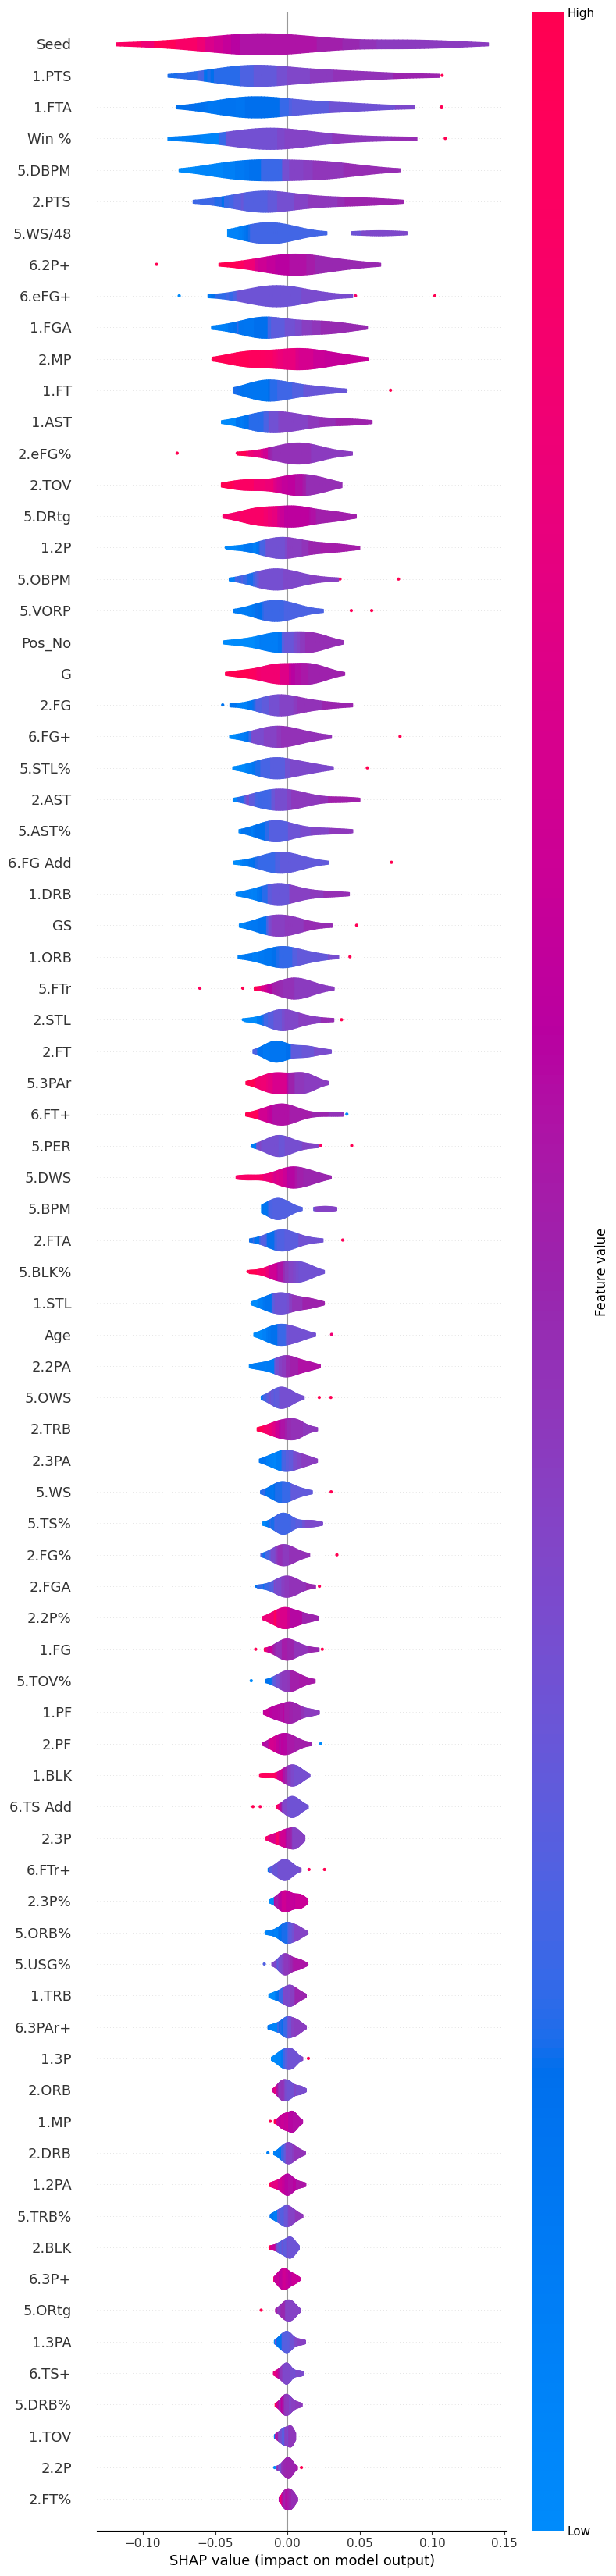

In [90]:
explainer = shap.Explainer(model.predict, normed_test_data)
shap_values = explainer(normed_test_data)
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='violin', max_display=len(test.columns))

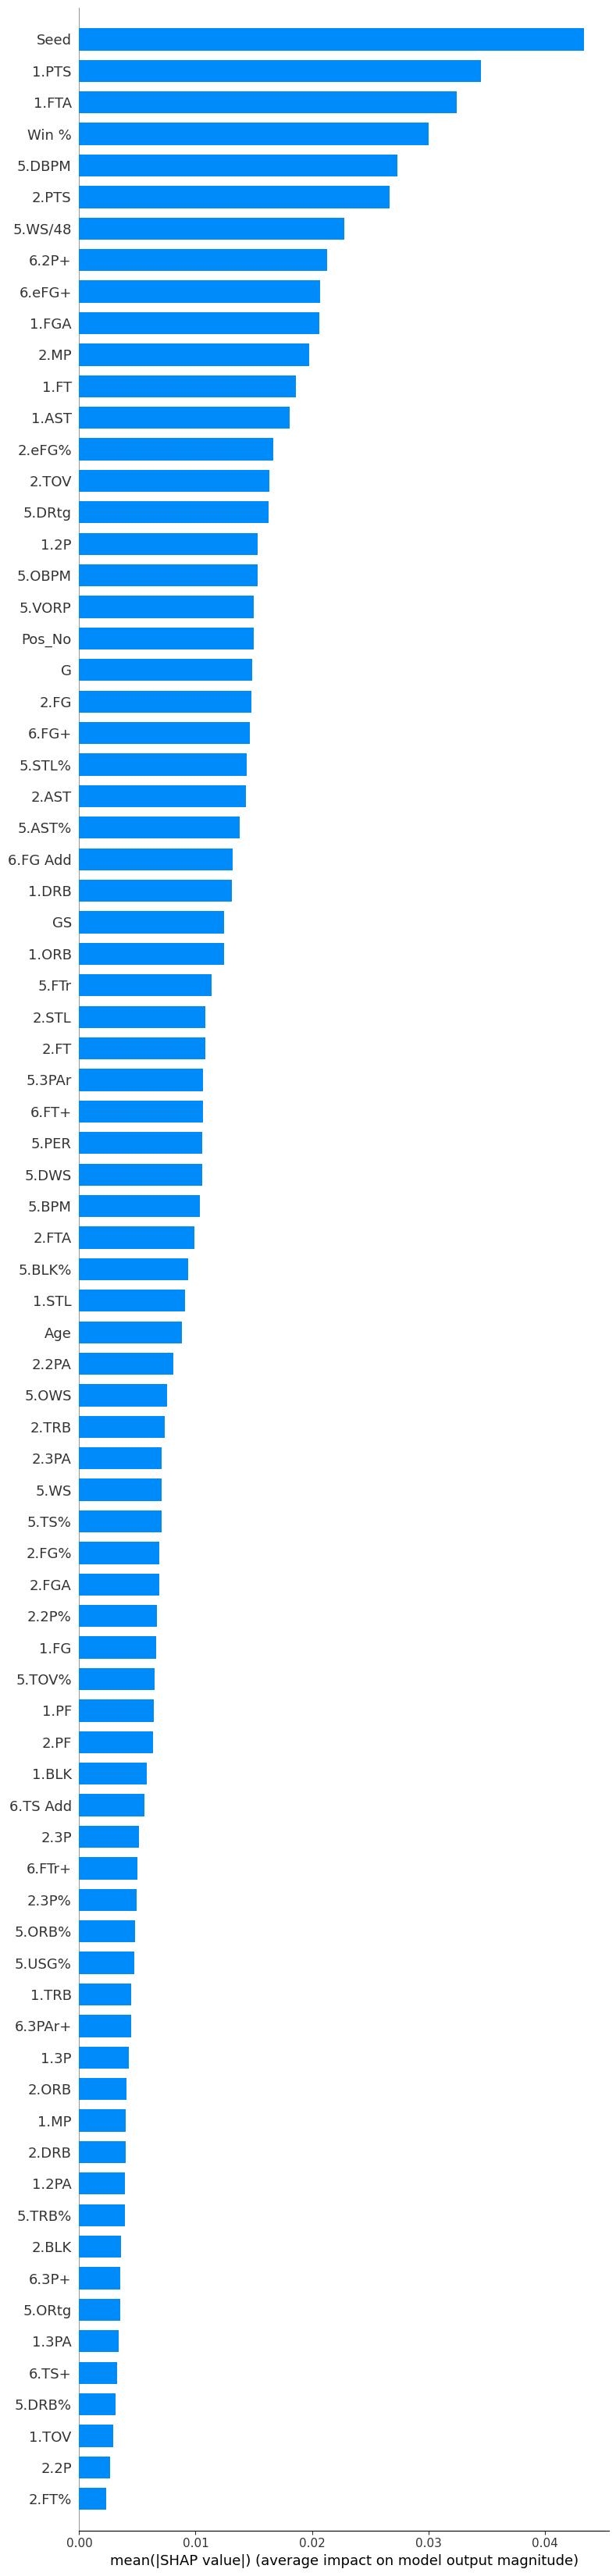

In [91]:
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='bar', max_display=len(test.columns))

In [92]:
leagueavs = pd.read_csv('LeagueAveragesByYear.csv')

In [93]:
histo_test2_1213 = pd.read_csv('HistoTest2-12_13.csv')

In [94]:
histo_test2_1213

,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,24,LeBron James,PF,4,28,MIA,76,76,1,0.804878,...,121,100,120,146,77.0,288.7,336.6,1,0.998,2012-13
1,25,Michael Jordan,SG,2,32,CHI,82,82,1,0.878049,...,105,113,107,108,70.0,97.7,172.3,1,0.986,1995-96
2,26,Hakeem Olajuwon,C,5,31,HOU,80,80,2,0.707317,...,109,97,107,101,10.0,152.0,144.1,1,0.880,1993-94
3,27,Charles Barkley,PF,4,29,PHO,76,76,1,0.756098,...,111,101,111,131,153.0,148.4,193.4,1,0.852,1992-93
4,28,David Robinson,C,5,29,SAS,81,81,1,0.756098,...,106,105,111,171,7.0,95.5,218.9,1,0.858,1994-95
5,29,Karl Malone,PF,4,33,UTA,82,82,2,0.780488,...,112,102,112,137,4.0,179.1,240.9,1,0.857,1996-97


In [95]:
df1 = pd.read_csv('ModernEra.csv')

In [96]:
histo_test2_1213.drop(histo_test2_1213.columns[[0]], axis = 1, inplace=True)

In [97]:
training_data = df1.copy()
train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
train_labels = training_data['MVP Share']

train.fillna(0)

scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train)

In [98]:
test = histo_test2_1213.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Share', 'Year'] + col_to_drop, axis=1)

test.fillna(0)
scaler = StandardScaler()
normed_test_data = scaler.fit_transform(test)

EPOCHS = 80
batch_size = 50

model = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'):
    history = model.fit(
        normed_train_data,
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        callbacks=[tfdocs.modeling.EpochDots(),
                ckpt_callback
                  ],

    )
Y_pred = model.predict(normed_test_data)
initial_results = histo_test2_1213[['Year', 'Player', 'Age', 'MVP']]
results = initial_results.copy()
results['Predicted MVP Share'] = Y_pred

print(results)

Here is a summary of this model: 
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 32)                2560      
                                                                 
 dense_191 (Dense)           (None, 64)                2112      
                                                                 
 dense_192 (Dense)           (None, 64)                4160      
                                                                 
 dense_193 (Dense)           (None, 64)                4160      
                                                                 
 dense_194 (Dense)           (None, 64)                4160      
                                                                 
 dense_195 (Dense)           (None, 64)                4160      
                                                                 
 dense_196 (Dense) 

2/2 [==============================] - 2s 18ms/step - loss: 1.2045 - mae: 0.8297 - mse: 1.2045 - mape: 21102.1152
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0578 - mae: 0.2151 - mse: 0.0578 - mape: 4817.7700.

2/2 [==============================] - 0s 14ms/step - loss: 0.1036 - mae: 0.2131 - mse: 0.1036 - mape: 1954.2168
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0711 - mae: 0.1545 - mse: 0.0711 - mape: 852.3339.

2/2 [==============================] - 0s 15ms/step - loss: 0.1228 - mae: 0.2113 - mse: 0.1228 - mape: 950.8250
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1298 - mae: 0.2226 - mse: 0.1298 - mape: 1210.6110.

2/2 [==============================] - 0s 16ms/step - loss: 0.1031 - mae: 0.2076 - mse: 0.1031 - mape: 2843.4468
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0815 - mae: 0.2397 - mse: 0.0815 - mape: 2575.5054.

2/2 [==============================] - 0s 19ms/step - loss: 0.0690 - mae: 0.2243 - mse: 0.0690 - mape: 2975.7070
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0454 - mae: 0.1765 - mse: 0.0454 - mape: 2597.5659.

2/2 [==============================] - 0s 15ms/step - loss: 0.0433 - mae: 0.1613 - mse: 0.0433 - mape: 2713.8669
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0202 - mae: 0.1063 - mse: 0.0202 - mape: 1516.8911.

2/2 [==============================] - 0s 16ms/step - loss: 0.0269 - mae: 0.1168 - mse: 0.0269 - mape: 1467.8022
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0342 - mae: 0.1319 - mse: 0.0342 - mape: 824.5663.

2/2 [==============================] - 0s 18ms/step - loss: 0.0304 - mae: 0.1201 - mse: 0.0304 - mape: 745.4014
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0142 - mae: 0.0706 - mse: 0.0142 - mape: 719.0876.

2/2 [==============================] - 0s 21ms/step - loss: 0.0265 - mae: 0.1022 - mse: 0.0265 - mape: 1088.0297
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0242 - mae: 0.1080 - mse: 0.0242 - mape: 1471.7954.

2/2 [==============================] - 0s 22ms/step - loss: 0.0396 - mae: 0.1352 - mse: 0.0396 - mape: 1237.7041
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0150 - mae: 0.0927 - mse: 0.0150 - mape: 1970.1289.

2/2 [==============================] - 0s 15ms/step - loss: 0.0180 - mae: 0.1011 - mse: 0.0180 - mape: 1391.2296
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0285 - mae: 0.1303 - mse: 0.0285 - mape: 2688.7478.

2/2 [==============================] - 0s 14ms/step - loss: 0.0223 - mae: 0.1140 - mse: 0.0223 - mape: 2182.5427
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0144 - mae: 0.0947 - mse: 0.0144 - mape: 1572.1017.

2/2 [==============================] - 0s 16ms/step - loss: 0.0243 - mae: 0.1194 - mse: 0.0243 - mape: 1629.8550
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0155 - mae: 0.0957 - mse: 0.0155 - mape: 1262.9657.

2/2 [==============================] - 0s 18ms/step - loss: 0.0133 - mae: 0.0846 - mse: 0.0133 - mape: 918.5022
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0212 - mae: 0.1016 - mse: 0.0212 - mape: 822.7505.

2/2 [==============================] - 0s 24ms/step - loss: 0.0203 - mae: 0.1030 - mse: 0.0203 - mape: 1271.5018
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0096 - mae: 0.0679 - mse: 0.0096 - mape: 1092.1277.

2/2 [==============================] - 0s 15ms/step - loss: 0.0153 - mae: 0.0857 - mse: 0.0153 - mape: 933.8251
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0241 - mae: 0.1067 - mse: 0.0241 - mape: 801.5757.

2/2 [==============================] - 0s 18ms/step - loss: 0.0128 - mae: 0.0780 - mse: 0.0128 - mape: 1201.7072
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0128 - mae: 0.0900 - mse: 0.0128 - mape: 1081.1326.

2/2 [==============================] - 0s 15ms/step - loss: 0.0178 - mae: 0.1042 - mse: 0.0178 - mape: 1263.9502
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0100 - mae: 0.0755 - mse: 0.0100 - mape: 1099.2964.

2/2 [==============================] - 0s 15ms/step - loss: 0.0107 - mae: 0.0726 - mse: 0.0107 - mape: 851.1749
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0119 - mae: 0.0746 - mse: 0.0119 - mape: 613.1622.

2/2 [==============================] - 0s 17ms/step - loss: 0.0116 - mae: 0.0675 - mse: 0.0116 - mape: 528.5254
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0112 - mae: 0.0700 - mse: 0.0112 - mape: 385.6805.

2/2 [==============================] - 0s 17ms/step - loss: 0.0104 - mae: 0.0673 - mse: 0.0104 - mape: 452.8620
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0188 - mae: 0.0936 - mse: 0.0188 - mape: 933.1637.

2/2 [==============================] - 0s 16ms/step - loss: 0.0126 - mae: 0.0755 - mse: 0.0126 - mape: 745.7883
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0680 - mse: 0.0094 - mape: 489.0253.

2/2 [==============================] - 0s 15ms/step - loss: 0.0077 - mae: 0.0588 - mse: 0.0077 - mape: 641.1641
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0578 - mse: 0.0070 - mape: 400.4736.

2/2 [==============================] - 0s 16ms/step - loss: 0.0080 - mae: 0.0623 - mse: 0.0080 - mape: 499.5052
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0647 - mse: 0.0080 - mape: 847.8234.

2/2 [==============================] - 0s 16ms/step - loss: 0.0068 - mae: 0.0581 - mse: 0.0068 - mape: 746.6848
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mae: 0.0621 - mse: 0.0069 - mape: 426.7789.

2/2 [==============================] - 0s 21ms/step - loss: 0.0064 - mae: 0.0566 - mse: 0.0064 - mape: 581.7961
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0537 - mse: 0.0055 - mape: 455.1624.

2/2 [==============================] - 0s 14ms/step - loss: 0.0057 - mae: 0.0544 - mse: 0.0057 - mape: 530.5408
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0438 - mse: 0.0037 - mape: 458.6172.

2/2 [==============================] - 0s 18ms/step - loss: 0.0051 - mae: 0.0506 - mse: 0.0051 - mape: 427.3009
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0560 - mse: 0.0057 - mape: 990.0080.

2/2 [==============================] - 0s 18ms/step - loss: 0.0042 - mae: 0.0463 - mse: 0.0042 - mape: 575.0120
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.0652 - mse: 0.0074 - mape: 1080.6163.

2/2 [==============================] - 0s 19ms/step - loss: 0.0064 - mae: 0.0588 - mse: 0.0064 - mape: 905.9725
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0421 - mse: 0.0032 - mape: 585.1997.

2/2 [==============================] - 0s 16ms/step - loss: 0.0053 - mae: 0.0510 - mse: 0.0053 - mape: 634.5551
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0338 - mse: 0.0023 - mape: 363.8799.

2/2 [==============================] - 0s 16ms/step - loss: 0.0024 - mae: 0.0360 - mse: 0.0024 - mape: 399.3740
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0558 - mse: 0.0049 - mape: 722.1136.

2/2 [==============================] - 0s 19ms/step - loss: 0.0051 - mae: 0.0547 - mse: 0.0051 - mape: 659.5644
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0419 - mse: 0.0035 - mape: 360.4942.

2/2 [==============================] - 0s 17ms/step - loss: 0.0032 - mae: 0.0412 - mse: 0.0032 - mape: 462.5334
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0430 - mse: 0.0034 - mape: 708.8108.

2/2 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0416 - mse: 0.0030 - mape: 597.7757
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0342 - mse: 0.0018 - mape: 583.2747.

2/2 [==============================] - 0s 24ms/step - loss: 0.0026 - mae: 0.0378 - mse: 0.0026 - mape: 536.5281
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0393 - mse: 0.0029 - mape: 591.0476.

2/2 [==============================] - 0s 17ms/step - loss: 0.0031 - mae: 0.0397 - mse: 0.0031 - mape: 493.1911
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0308 - mse: 0.0018 - mape: 398.9292.

2/2 [==============================] - 0s 14ms/step - loss: 0.0030 - mae: 0.0387 - mse: 0.0030 - mape: 341.2301
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0299 - mse: 0.0015 - mape: 694.4713.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0287 - mse: 0.0014 - mape: 539.1658
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0340 - mse: 0.0019 - mape: 662.0089.

2/2 [==============================] - 0s 19ms/step - loss: 0.0022 - mae: 0.0345 - mse: 0.0022 - mape: 571.1024
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9563e-04 - mae: 0.0248 - mse: 9.9563e-04 - mape: 293.4505.

2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0286 - mse: 0.0017 - mape: 229.7357   
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0318 - mse: 0.0018 - mape: 557.4795.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0338 - mse: 0.0020 - mape: 552.4474
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0374 - mse: 0.0032 - mape: 191.4561.

2/2 [==============================] - 0s 22ms/step - loss: 0.0025 - mae: 0.0343 - mse: 0.0025 - mape: 318.3147
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0250 - mse: 0.0012 - mape: 343.3402.

2/2 [==============================] - 0s 19ms/step - loss: 0.0017 - mae: 0.0301 - mse: 0.0017 - mape: 412.3428
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0330 - mse: 0.0023 - mape: 320.8644.

2/2 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0310 - mse: 0.0019 - mape: 332.8546
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0289 - mse: 0.0018 - mape: 338.7963.

2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0300 - mse: 0.0019 - mape: 256.2174
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0342 - mse: 0.0028 - mape: 356.7877.

2/2 [==============================] - 0s 16ms/step - loss: 0.0023 - mae: 0.0335 - mse: 0.0023 - mape: 338.1960
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0320 - mse: 0.0021 - mape: 651.6613.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0328 - mse: 0.0021 - mape: 695.6071
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0263 - mse: 0.0015 - mape: 387.4833.

2/2 [==============================] - 0s 16ms/step - loss: 0.0027 - mae: 0.0342 - mse: 0.0027 - mape: 294.6333
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 5.4936e-04 - mae: 0.0176 - mse: 5.4936e-04 - mape: 278.6186.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0262 - mse: 0.0015 - mape: 398.6912   
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8931e-04 - mae: 0.0221 - mse: 9.8931e-04 - mape: 243.3794.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0283 - mse: 0.0018 - mape: 266.1161   
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0283 - mse: 0.0017 - mape: 398.3330.

2/2 [==============================] - 0s 20ms/step - loss: 0.0024 - mae: 0.0330 - mse: 0.0024 - mape: 339.9514
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0368 - mse: 0.0019 - mape: 819.8873.

2/2 [==============================] - 0s 15ms/step - loss: 0.0028 - mae: 0.0396 - mse: 0.0028 - mape: 707.9003
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0249 - mse: 0.0012 - mape: 570.0248.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0265 - mse: 0.0013 - mape: 419.2464
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0393 - mse: 0.0031 - mape: 287.2850.

2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0358 - mse: 0.0027 - mape: 282.8404
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0229 - mse: 0.0011 - mape: 344.6208.

2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - mae: 0.0292 - mse: 0.0018 - mape: 400.8720
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0422 - mse: 0.0033 - mape: 626.3251.

2/2 [==============================] - 0s 16ms/step - loss: 0.0024 - mae: 0.0349 - mse: 0.0024 - mape: 572.2584
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0345 - mse: 0.0027 - mape: 222.0072.

2/2 [==============================] - 0s 22ms/step - loss: 0.0035 - mae: 0.0379 - mse: 0.0035 - mape: 211.4480
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 8.8064e-04 - mae: 0.0216 - mse: 8.8064e-04 - mape: 559.5305.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0299 - mse: 0.0020 - mape: 471.9251   
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0383 - mse: 0.0027 - mape: 292.9494.

2/2 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0317 - mse: 0.0020 - mape: 282.7651
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0440 - mse: 0.0041 - mape: 180.3553.

2/2 [==============================] - 0s 15ms/step - loss: 0.0029 - mae: 0.0367 - mse: 0.0029 - mape: 216.3289
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0254 - mse: 0.0015 - mape: 355.4361.

2/2 [==============================] - 0s 17ms/step - loss: 0.0024 - mae: 0.0351 - mse: 0.0024 - mape: 393.9100
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0313 - mse: 0.0020 - mape: 540.5532.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0288 - mse: 0.0017 - mape: 502.8158
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0306 - mse: 0.0020 - mape: 319.8696.

2/2 [==============================] - 0s 18ms/step - loss: 0.0026 - mae: 0.0365 - mse: 0.0026 - mape: 210.7770
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1045e-04 - mae: 0.0151 - mse: 3.1045e-04 - mape: 271.2221.

2/2 [==============================] - 0s 17ms/step - loss: 6.0369e-04 - mae: 0.0185 - mse: 6.0369e-04 - mape: 323.8076
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0352 - mse: 0.0027 - mape: 373.2747.

2/2 [==============================] - 0s 22ms/step - loss: 0.0021 - mae: 0.0310 - mse: 0.0021 - mape: 334.7099
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - mse: 0.0011 - mape: 237.0002.

2/2 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0257 - mse: 0.0014 - mape: 246.1296
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0274 - mse: 0.0015 - mape: 177.9215.

2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0249 - mse: 0.0012 - mape: 509.8284
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0409 - mse: 0.0036 - mape: 215.5277.

2/2 [==============================] - 0s 17ms/step - loss: 0.0025 - mae: 0.0331 - mse: 0.0025 - mape: 286.4915
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0344 - mse: 0.0020 - mape: 162.0219.

2/2 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0319 - mse: 0.0020 - mape: 187.6742
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0297 - mse: 0.0020 - mape: 166.3672.

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0266 - mse: 0.0013 - mape: 290.2358
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0361 - mse: 0.0027 - mape: 449.1948.

2/2 [==============================] - 0s 20ms/step - loss: 0.0025 - mae: 0.0345 - mse: 0.0025 - mape: 438.6236
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0229 - mse: 0.0013 - mape: 226.9586.

2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - mae: 0.0271 - mse: 0.0018 - mape: 191.9755
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0299 - mse: 0.0019 - mape: 80.3053.

2/2 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0246 - mse: 0.0013 - mape: 172.6619
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0227 - mse: 0.0010 - mape: 352.4659.

2/2 [==============================] - 0s 23ms/step - loss: 0.0017 - mae: 0.0274 - mse: 0.0017 - mape: 315.4942
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 5.5365e-04 - mae: 0.0159 - mse: 5.5365e-04 - mape: 152.1631.

2/2 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013 - mape: 205.1500   
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0241 - mse: 0.0010 - mape: 127.4224.

2/2 [==============================] - 0s 22ms/step - loss: 8.5252e-04 - mae: 0.0209 - mse: 8.5252e-04 - mape: 125.7949
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.5557e-04 - mae: 0.0181 - mse: 5.5557e-04 - mape: 367.4287.

2/2 [==============================] - 0s 25ms/step - loss: 0.0011 - mae: 0.0233 - mse: 0.0011 - mape: 463.1134   
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 7.6865e-04 - mae: 0.0198 - mse: 7.6865e-04 - mape: 290.9960.

2/2 [==============================] - 0s 19ms/step - loss: 6.0072e-04 - mae: 0.0176 - mse: 6.0072e-04 - mape: 246.4588
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 7.6431e-04 - mae: 0.0197 - mse: 7.6431e-04 - mape: 160.7865.

1/1 [==============================] - 0s 141ms/step
      Year           Player  Age  MVP  Predicted MVP Share
0  2012-13     LeBron James   28    1             0.542118
1  1995-96   Michael Jordan   32    1             0.514956
2  1993-94  Hakeem Olajuwon   31    1             0.007194
3  1992-93  Charles Barkley   29    1             0.007322
4  1994-95   David Robinson   29    1             0.082766
5  1996-97      Karl Malone   33    1                  NaN


In [99]:
results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
results

,Year,Player,Age,MVP,Predicted MVP Share
0,2012-13,LeBron James,28,1,0.542118
1,1995-96,Michael Jordan,32,1,0.514956
2,1994-95,David Robinson,29,1,0.082766
3,1992-93,Charles Barkley,29,1,0.007322
4,1993-94,Hakeem Olajuwon,31,1,0.007194
5,1996-97,Karl Malone,33,1,NaN


HISTORICAL ANALYSIS FOR RECENT SEASONS

In [100]:
histo_test3 = pd.read_csv('HistoTest3.csv')

In [101]:
histo_test3

,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,0,Michael Jordan,SG,2,33,CHI,82,82,1,0.841463,...,105,113,106,95,74.0,85.7,132.8,0,0.832,1996-97
1,1,Hakeem Olajuwon,C,5,34,HOU,78,78,4,0.695122,...,104,107,104,98,5.0,53.1,72.2,0,0.083,1996-97
2,2,Charles Barkley,PF,4,32,PHO,71,71,15,0.500000,...,104,105,108,148,75.0,51.9,121.7,0,0.007,1995-96
3,3,David Robinson,C,5,26,SAS,68,68,10,0.573171,...,113,92,112,171,9.0,139.1,174.2,0,0.351,1991-92
4,4,Karl Malone,PF,4,28,UTA,81,81,5,0.670732,...,108,103,113,187,13.0,122.7,256.3,0,0.273,1991-92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,Stephen Curry,PG,1,33,GSW,64,64,3,0.646341,...,104,119,106,98,153.0,53.4,96.0,0,0.004,2021-22
71,71,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,...,117,105,117,144,55.0,230.9,286.9,1,0.875,2021-22
72,72,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,...,100,105,109,243,47.0,6.5,169.0,0,0.706,2021-22
73,73,Kevin Durant,PF,4,33,BRK,55,55,14,0.536585,...,107,117,112,148,67.0,85.3,177.1,0,0.001,2021-22


In [102]:
df1 = pd.read_csv('ModernEra.csv')

In [103]:
histo_test3.drop(histo_test3.columns[[0]], axis = 1, inplace=True)

In [104]:
histo_test3

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,Michael Jordan,SG,2,33,CHI,82,82,1,0.841463,3106,...,105,113,106,95,74.0,85.7,132.8,0,0.832,1996-97
1,Hakeem Olajuwon,C,5,34,HOU,78,78,4,0.695122,2852,...,104,107,104,98,5.0,53.1,72.2,0,0.083,1996-97
2,Charles Barkley,PF,4,32,PHO,71,71,15,0.500000,2632,...,104,105,108,148,75.0,51.9,121.7,0,0.007,1995-96
3,David Robinson,C,5,26,SAS,68,68,10,0.573171,2564,...,113,92,112,171,9.0,139.1,174.2,0,0.351,1991-92
4,Karl Malone,PF,4,28,UTA,81,81,5,0.670732,3054,...,108,103,113,187,13.0,122.7,256.3,0,0.273,1991-92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Stephen Curry,PG,1,33,GSW,64,64,3,0.646341,2211,...,104,119,106,98,153.0,53.4,96.0,0,0.004,2021-22
71,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,2476,...,117,105,117,144,55.0,230.9,286.9,1,0.875,2021-22
72,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,2297,...,100,105,109,243,47.0,6.5,169.0,0,0.706,2021-22
73,Kevin Durant,PF,4,33,BRK,55,55,14,0.536585,2047,...,107,117,112,148,67.0,85.3,177.1,0,0.001,2021-22


In [105]:
histo_test3[(histo_test3['Player'] == "Shaquille O'Neal")]

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
5,Shaquille O'Neal,C,5,28,LAL,74,74,2,0.682927,2924,...,121,69,111,222,1.0,281.2,209.3,0,0.466,2000-01
16,Shaquille O'Neal,C,5,28,LAL,74,74,2,0.682927,2924,...,121,69,111,222,1.0,281.2,209.3,0,0.466,2000-01
29,Shaquille O'Neal,C,5,29,LAL,67,66,2,0.707317,2422,...,121,74,113,199,NaN,251.2,214.8,0,0.552,2001-02
43,Shaquille O'Neal,C,5,22,ORL,79,79,4,0.695122,2923,...,117,72,108,161,2.0,266.5,176.4,0,0.576,1994-95
54,Shaquille O'Neal,C,5,32,MIA,73,73,2,0.719512,2492,...,125,61,110,215,NaN,259.7,153.2,0,0.813,2004-05
67,Shaquille O'Neal,C,5,27,LAL,79,79,1,0.817073,3163,...,120,70,111,161,NaN,319.7,223.9,1,0.998,1999-00


In [106]:
training_data = df1.copy()
train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
train_labels = training_data['MVP Share']

train.fillna(0)

scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train)

In [107]:
test = histo_test3.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Share', 'Year'] + col_to_drop, axis=1)

test.fillna(0)
scaler = StandardScaler()
normed_test_data = scaler.fit_transform(test)

EPOCHS = 80
batch_size = 50

model = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'):
    history = model.fit(
        normed_train_data,
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        callbacks=[tfdocs.modeling.EpochDots(),
                ckpt_callback
                  ],

    )
Y_pred = model.predict(normed_test_data)
initial_results = histo_test3[['Year', 'Player', 'Age', 'MVP']]
results = initial_results.copy()
results['Predicted MVP Share'] = Y_pred

print(results)

Here is a summary of this model: 
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 32)                2560      
                                                                 
 dense_198 (Dense)           (None, 64)                2112      
                                                                 
 dense_199 (Dense)           (None, 64)                4160      
                                                                 
 dense_200 (Dense)           (None, 64)                4160      
                                                                 
 dense_201 (Dense)           (None, 64)                4160      
                                                                 
 dense_202 (Dense)           (None, 64)                4160      
                                                                 
 dense_203 (Dense) 

2/2 [==============================] - 2s 17ms/step - loss: 0.5602 - mae: 0.6281 - mse: 0.5602 - mape: 11535.1875
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0794 - mae: 0.2370 - mse: 0.0794 - mape: 5225.7378.

2/2 [==============================] - 0s 17ms/step - loss: 0.0885 - mae: 0.2026 - mse: 0.0885 - mape: 2753.6501
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1028 - mae: 0.1919 - mse: 0.1028 - mape: 1276.6459.

2/2 [==============================] - 0s 14ms/step - loss: 0.1103 - mae: 0.1988 - mse: 0.1103 - mape: 1300.5085
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0718 - mae: 0.1744 - mse: 0.0718 - mape: 2531.6797.

2/2 [==============================] - 0s 25ms/step - loss: 0.0749 - mae: 0.1911 - mse: 0.0749 - mape: 2828.3774
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0787 - mae: 0.2419 - mse: 0.0787 - mape: 3779.2107.

2/2 [==============================] - 0s 17ms/step - loss: 0.0682 - mae: 0.2242 - mse: 0.0682 - mape: 4687.1963
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0677 - mae: 0.2208 - mse: 0.0677 - mape: 4943.0386.

2/2 [==============================] - 0s 14ms/step - loss: 0.0547 - mae: 0.1977 - mse: 0.0547 - mape: 4207.0977
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0448 - mae: 0.1512 - mse: 0.0448 - mape: 1107.4205.

2/2 [==============================] - 0s 17ms/step - loss: 0.0340 - mae: 0.1253 - mse: 0.0340 - mape: 1330.1040
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - mae: 0.0928 - mse: 0.0160 - mape: 1063.8381.

2/2 [==============================] - 0s 14ms/step - loss: 0.0245 - mae: 0.1074 - mse: 0.0245 - mape: 1166.4291
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0245 - mae: 0.0958 - mse: 0.0245 - mape: 1023.3214.

2/2 [==============================] - 0s 13ms/step - loss: 0.0231 - mae: 0.0953 - mse: 0.0231 - mape: 717.9418
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0144 - mae: 0.0810 - mse: 0.0144 - mape: 763.0472.

2/2 [==============================] - 0s 15ms/step - loss: 0.0196 - mae: 0.0933 - mse: 0.0196 - mape: 701.8173
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0228 - mae: 0.0948 - mse: 0.0228 - mape: 935.4368.

2/2 [==============================] - 0s 17ms/step - loss: 0.0178 - mae: 0.0944 - mse: 0.0178 - mape: 1238.3966
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - mae: 0.1147 - mse: 0.0209 - mape: 1455.4243.

2/2 [==============================] - 0s 16ms/step - loss: 0.0177 - mae: 0.1026 - mse: 0.0177 - mape: 1543.3549
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0223 - mae: 0.0955 - mse: 0.0223 - mape: 687.2789.

2/2 [==============================] - 0s 13ms/step - loss: 0.0242 - mae: 0.1014 - mse: 0.0242 - mape: 586.1067
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0614 - mse: 0.0087 - mape: 1085.3997.

2/2 [==============================] - 0s 13ms/step - loss: 0.0127 - mae: 0.0810 - mse: 0.0127 - mape: 1186.1600
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - mae: 0.0822 - mse: 0.0160 - mape: 543.9132.

2/2 [==============================] - 0s 13ms/step - loss: 0.0171 - mae: 0.0832 - mse: 0.0171 - mape: 474.2127
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0110 - mae: 0.0736 - mse: 0.0110 - mape: 541.0172.

2/2 [==============================] - 0s 14ms/step - loss: 0.0152 - mae: 0.0789 - mse: 0.0152 - mape: 483.9536
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0086 - mae: 0.0614 - mse: 0.0086 - mape: 557.4350.

2/2 [==============================] - 0s 15ms/step - loss: 0.0126 - mae: 0.0692 - mse: 0.0126 - mape: 437.7291
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0086 - mae: 0.0692 - mse: 0.0086 - mape: 947.9771.

2/2 [==============================] - 0s 17ms/step - loss: 0.0118 - mae: 0.0769 - mse: 0.0118 - mape: 941.8543
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0132 - mae: 0.0831 - mse: 0.0132 - mape: 1096.4053.

2/2 [==============================] - 0s 19ms/step - loss: 0.0122 - mae: 0.0801 - mse: 0.0122 - mape: 1136.7219
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0111 - mae: 0.0824 - mse: 0.0111 - mape: 1181.2135.

2/2 [==============================] - 0s 14ms/step - loss: 0.0114 - mae: 0.0840 - mse: 0.0114 - mape: 996.1766
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.0618 - mse: 0.0074 - mape: 1031.2850.

2/2 [==============================] - 0s 17ms/step - loss: 0.0076 - mae: 0.0615 - mse: 0.0076 - mape: 1082.2845
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0658 - mse: 0.0080 - mape: 1130.7931.

2/2 [==============================] - 0s 16ms/step - loss: 0.0074 - mae: 0.0635 - mse: 0.0074 - mape: 834.0611
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0086 - mae: 0.0679 - mse: 0.0086 - mape: 745.9776.

2/2 [==============================] - 0s 15ms/step - loss: 0.0065 - mae: 0.0574 - mse: 0.0065 - mape: 555.2386
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0593 - mse: 0.0076 - mape: 329.5462.

2/2 [==============================] - 0s 15ms/step - loss: 0.0059 - mae: 0.0506 - mse: 0.0059 - mape: 293.3812
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mae: 0.0505 - mse: 0.0058 - mape: 279.9459.

2/2 [==============================] - 0s 15ms/step - loss: 0.0071 - mae: 0.0545 - mse: 0.0071 - mape: 270.7739
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0356 - mse: 0.0024 - mape: 310.3820.

2/2 [==============================] - 0s 15ms/step - loss: 0.0052 - mae: 0.0485 - mse: 0.0052 - mape: 637.8121
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0458 - mse: 0.0042 - mape: 394.2871.

2/2 [==============================] - 0s 19ms/step - loss: 0.0045 - mae: 0.0479 - mse: 0.0045 - mape: 348.0061
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0517 - mse: 0.0053 - mape: 424.6772.

2/2 [==============================] - 0s 16ms/step - loss: 0.0051 - mae: 0.0515 - mse: 0.0051 - mape: 576.2049
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0454 - mse: 0.0040 - mape: 572.8973.

2/2 [==============================] - 0s 18ms/step - loss: 0.0033 - mae: 0.0428 - mse: 0.0033 - mape: 610.4619
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0365 - mse: 0.0031 - mape: 344.5380.

2/2 [==============================] - 0s 16ms/step - loss: 0.0035 - mae: 0.0391 - mse: 0.0035 - mape: 325.5921
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0386 - mse: 0.0026 - mape: 226.7949.

2/2 [==============================] - 0s 16ms/step - loss: 0.0028 - mae: 0.0382 - mse: 0.0028 - mape: 318.0476
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0434 - mse: 0.0042 - mape: 429.7496.

2/2 [==============================] - 0s 14ms/step - loss: 0.0030 - mae: 0.0369 - mse: 0.0030 - mape: 329.0473
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0358 - mse: 0.0025 - mape: 447.1658.

2/2 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0360 - mse: 0.0026 - mape: 564.9661
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0397 - mse: 0.0031 - mape: 495.3354.

2/2 [==============================] - 0s 18ms/step - loss: 0.0028 - mae: 0.0386 - mse: 0.0028 - mape: 528.7882
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0262 - mse: 0.0014 - mape: 410.9408.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0276 - mse: 0.0016 - mape: 416.0324
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0312 - mse: 0.0020 - mape: 297.4843.

2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - mae: 0.0323 - mse: 0.0025 - mape: 329.2859
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0246 - mse: 0.0012 - mape: 288.8506.

2/2 [==============================] - 0s 18ms/step - loss: 0.0014 - mae: 0.0261 - mse: 0.0014 - mape: 359.6839
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0458 - mse: 0.0042 - mape: 290.1907.

2/2 [==============================] - 0s 18ms/step - loss: 0.0029 - mae: 0.0380 - mse: 0.0029 - mape: 353.9958
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0474 - mse: 0.0049 - mape: 911.8187.

2/2 [==============================] - 0s 21ms/step - loss: 0.0039 - mae: 0.0418 - mse: 0.0039 - mape: 697.2237
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0366 - mse: 0.0028 - mape: 452.3384.

2/2 [==============================] - 0s 23ms/step - loss: 0.0035 - mae: 0.0380 - mse: 0.0035 - mape: 410.7797
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0321 - mse: 0.0023 - mape: 272.1041.

2/2 [==============================] - 0s 14ms/step - loss: 0.0025 - mae: 0.0332 - mse: 0.0025 - mape: 301.6791
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0334 - mse: 0.0023 - mape: 393.5616.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0324 - mse: 0.0021 - mape: 345.5002
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0246 - mse: 0.0012 - mape: 332.7512.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0293 - mse: 0.0020 - mape: 257.0832
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0335 - mse: 0.0027 - mape: 177.1465.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0265 - mse: 0.0016 - mape: 228.2631
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0270 - mse: 0.0015 - mape: 267.8313.

2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0274 - mse: 0.0018 - mape: 269.4533
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0317 - mse: 0.0026 - mape: 312.0676.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0284 - mse: 0.0020 - mape: 320.2810
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5894e-04 - mae: 0.0206 - mse: 8.5894e-04 - mape: 169.6345.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0264 - mse: 0.0017 - mape: 225.5072   
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0183 - mse: 0.0010 - mape: 132.5554.

2/2 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0194 - mse: 0.0011 - mape: 285.1550
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0343 - mse: 0.0024 - mape: 338.3934.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0295 - mse: 0.0020 - mape: 327.8232
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0292 - mse: 0.0019 - mape: 201.3367.

2/2 [==============================] - 0s 18ms/step - loss: 0.0014 - mae: 0.0248 - mse: 0.0014 - mape: 236.4327
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0333 - mse: 0.0028 - mape: 251.1119.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0287 - mse: 0.0021 - mape: 258.8334
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0236 - mse: 0.0011 - mape: 281.9546.

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0251 - mse: 0.0013 - mape: 547.1967
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0299 - mse: 0.0021 - mape: 768.6713.

2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - mae: 0.0290 - mse: 0.0018 - mape: 598.9749
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0384 - mse: 0.0035 - mape: 162.8956.

2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0336 - mse: 0.0027 - mape: 157.6961
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2062e-04 - mae: 0.0171 - mse: 6.2062e-04 - mape: 302.1780.

2/2 [==============================] - 0s 14ms/step - loss: 0.0014 - mae: 0.0231 - mse: 0.0014 - mape: 256.9568   
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0277 - mse: 0.0020 - mape: 373.5966.

2/2 [==============================] - 0s 14ms/step - loss: 9.6193e-04 - mae: 0.0199 - mse: 9.6193e-04 - mape: 371.8618
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0222 - mse: 0.0011 - mape: 160.9803.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0246 - mse: 0.0015 - mape: 177.2966
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4104e-04 - mae: 0.0170 - mse: 6.4104e-04 - mape: 254.1090.

2/2 [==============================] - 0s 18ms/step - loss: 7.0348e-04 - mae: 0.0166 - mse: 7.0348e-04 - mape: 208.6269
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0309 - mse: 0.0018 - mape: 438.1711.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0263 - mse: 0.0015 - mape: 339.6696
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9005e-04 - mae: 0.0177 - mse: 6.9005e-04 - mape: 207.6935.

2/2 [==============================] - 0s 20ms/step - loss: 7.1706e-04 - mae: 0.0190 - mse: 7.1706e-04 - mape: 294.7939
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 8.6530e-04 - mae: 0.0194 - mse: 8.6530e-04 - mape: 290.9237.

2/2 [==============================] - 0s 17ms/step - loss: 6.6338e-04 - mae: 0.0165 - mse: 6.6338e-04 - mape: 235.8970
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0232 - mse: 0.0010 - mape: 230.5836.

2/2 [==============================] - 0s 16ms/step - loss: 7.0144e-04 - mae: 0.0193 - mse: 7.0144e-04 - mape: 182.6844
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5520e-04 - mae: 0.0133 - mse: 4.5520e-04 - mape: 196.8044.

2/2 [==============================] - 0s 18ms/step - loss: 6.6210e-04 - mae: 0.0163 - mse: 6.6210e-04 - mape: 176.5621
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9918e-04 - mae: 0.0169 - mse: 5.9918e-04 - mape: 141.2899.

2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mae: 0.0194 - mse: 0.0010 - mape: 137.7836   
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1135e-04 - mae: 0.0154 - mse: 5.1135e-04 - mape: 316.0439.

2/2 [==============================] - 0s 17ms/step - loss: 9.6931e-04 - mae: 0.0182 - mse: 9.6931e-04 - mape: 270.5860
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0208 - mse: 0.0011 - mape: 133.9150.

2/2 [==============================] - 0s 17ms/step - loss: 9.0766e-04 - mae: 0.0194 - mse: 9.0766e-04 - mape: 119.8422
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0213 - mse: 0.0012 - mape: 157.3719.

2/2 [==============================] - 0s 18ms/step - loss: 0.0015 - mae: 0.0254 - mse: 0.0015 - mape: 145.1335
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 8.3291e-04 - mae: 0.0185 - mse: 8.3291e-04 - mape: 219.3885.

2/2 [==============================] - 0s 19ms/step - loss: 8.8394e-04 - mae: 0.0214 - mse: 8.8394e-04 - mape: 229.7239
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0361 - mse: 0.0027 - mape: 286.5933.

2/2 [==============================] - 0s 19ms/step - loss: 0.0019 - mae: 0.0284 - mse: 0.0019 - mape: 274.5420
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0282 - mse: 0.0020 - mape: 137.8857.

2/2 [==============================] - 0s 17ms/step - loss: 0.0025 - mae: 0.0298 - mse: 0.0025 - mape: 153.4270
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3883e-04 - mae: 0.0195 - mse: 7.3883e-04 - mape: 391.1711.

2/2 [==============================] - 0s 19ms/step - loss: 9.5497e-04 - mae: 0.0217 - mse: 9.5497e-04 - mape: 309.5638
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5230e-04 - mae: 0.0148 - mse: 4.5230e-04 - mape: 177.6375.

2/2 [==============================] - 0s 18ms/step - loss: 8.3953e-04 - mae: 0.0181 - mse: 8.3953e-04 - mape: 158.8764
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7281e-04 - mae: 0.0192 - mse: 6.7281e-04 - mape: 302.3991.

2/2 [==============================] - 0s 17ms/step - loss: 7.7318e-04 - mae: 0.0189 - mse: 7.7318e-04 - mape: 235.7423
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0274 - mse: 0.0016 - mape: 156.7857.

2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mae: 0.0216 - mse: 0.0011 - mape: 187.4961
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6905e-04 - mae: 0.0184 - mse: 5.6905e-04 - mape: 419.1841.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0245 - mse: 0.0012 - mape: 330.9594   
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4948e-04 - mae: 0.0182 - mse: 9.4948e-04 - mape: 146.5634.

2/2 [==============================] - 0s 16ms/step - loss: 8.5337e-04 - mae: 0.0188 - mse: 8.5337e-04 - mape: 184.8385
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0324 - mse: 0.0023 - mape: 294.8223.

2/2 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - mape: 260.7013
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0206 - mse: 0.0011 - mape: 226.9819.

2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0207 - mse: 0.0010 - mape: 202.2808
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9290e-04 - mae: 0.0133 - mse: 3.9290e-04 - mape: 161.6449.

2/2 [==============================] - 0s 17ms/step - loss: 4.7525e-04 - mae: 0.0153 - mse: 4.7525e-04 - mape: 170.4399
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 8.0031e-04 - mae: 0.0197 - mse: 8.0031e-04 - mape: 324.1241.

3/3 [==============================] - 0s 5ms/step
       Year           Player  Age  MVP  Predicted MVP Share
0   1996-97   Michael Jordan   33    0             0.596041
1   1996-97  Hakeem Olajuwon   34    0             0.019653
2   1995-96  Charles Barkley   32    0             0.016009
3   1991-92   David Robinson   26    0             0.032616
4   1991-92      Karl Malone   28    0             0.149350
..      ...              ...  ...  ...                  ...
70  2021-22    Stephen Curry   33    0             0.023680
71  2021-22     Nikola Jokić   26    1             0.673792
72  2021-22      Joel Embiid   27    0             0.518688
73  2021-22     Kevin Durant   33    0             0.002973
74  2021-22     LeBron James   37    0             0.008933

[75 rows x 5 columns]


In [108]:
results[(results['Player'] == "Shaquille O'Neal")]

,Year,Player,Age,MVP,Predicted MVP Share
5,2000-01,Shaquille O'Neal,28,0,NaN
16,2000-01,Shaquille O'Neal,28,0,NaN
29,2001-02,Shaquille O'Neal,29,0,NaN
43,1994-95,Shaquille O'Neal,22,0,NaN
54,2004-05,Shaquille O'Neal,32,0,NaN
67,1999-00,Shaquille O'Neal,27,1,NaN


In [109]:
r1 = results.iloc[0:11]
r1 = r1.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r1

,Year,Player,Age,MVP,Predicted MVP Share
0,2015-16,Stephen Curry,27,1,0.840010
1,1996-97,Michael Jordan,33,0,0.596041
2,2015-16,LeBron James,31,0,0.241257
3,1991-92,Karl Malone,28,0,0.149350
4,2015-16,Kevin Durant,27,0,0.088935
5,2002-03,Allen Iverson,27,0,0.061210
6,2015-16,James Harden,26,0,0.061017
7,1991-92,David Robinson,26,0,0.032616
8,1996-97,Hakeem Olajuwon,34,0,0.019653
9,1995-96,Charles Barkley,32,0,0.016009


In [110]:
r2 = results.iloc[11:24]
r2 = r2.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r2

,Year,Player,Age,MVP,Predicted MVP Share
0,2017-18,LeBron James,33,0,0.700930
1,2017-18,James Harden,28,1,0.673551
2,1996-97,Michael Jordan,33,0,0.596041
3,1991-92,Karl Malone,28,0,0.149350
4,2002-03,Allen Iverson,27,0,0.061210
5,1991-92,David Robinson,26,0,0.032616
6,2017-18,Giannis Antetokounmpo,23,0,0.022591
7,1996-97,Hakeem Olajuwon,34,0,0.019653
8,1995-96,Charles Barkley,32,0,0.016009
9,2017-18,Kevin Durant,29,0,0.013689


In [111]:
r3 = results.iloc[24:38]
r3 = r3.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r3

,Year,Player,Age,MVP,Predicted MVP Share
0,1990-91,Michael Jordan,27,1,1.002766
1,2018-19,James Harden,29,0,0.732968
2,2018-19,Giannis Antetokounmpo,24,1,0.524249
3,1990-91,David Robinson,25,0,0.294147
4,1999-00,Allen Iverson,24,0,0.145415
5,2018-19,Nikola Jokić,23,0,0.059323
6,1994-95,Hakeem Olajuwon,32,0,0.040342
7,1994-95,Karl Malone,31,0,0.038533
8,1991-92,Charles Barkley,28,0,0.035145
9,2018-19,Kevin Durant,30,0,0.023876


In [112]:
r4 = results.iloc[38:49]
r4 = r4.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r4

,Year,Player,Age,MVP,Predicted MVP Share
0,2019-20,Giannis Antetokounmpo,25,1,0.660128
1,2019-20,James Harden,30,0,0.332980
2,1997-98,Michael Jordan,34,1,0.318106
3,1995-96,David Robinson,30,0,0.275687
4,2019-20,LeBron James,35,0,0.126140
5,2004-05,Allen Iverson,29,0,0.062454
6,2019-20,Nikola Jokić,24,0,0.042773
7,1994-95,Charles Barkley,31,0,0.031883
8,1995-96,Hakeem Olajuwon,33,0,0.024672
9,1998-99,Karl Malone,35,1,NaN


In [113]:
r5 = results.iloc[49:62]
r5 = r5.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r5

,Year,Player,Age,MVP,Predicted MVP Share
0,2020-21,Nikola Jokić,25,1,0.673613
1,1991-92,Michael Jordan,28,1,0.622164
2,1993-94,David Robinson,28,0,0.621934
3,2020-21,Joel Embiid,26,0,0.320107
4,1997-98,Karl Malone,34,0,0.244337
5,1990-91,Charles Barkley,27,0,0.185768
6,2020-21,Stephen Curry,32,0,0.128170
7,2020-21,Giannis Antetokounmpo,26,0,0.034801
8,2020-21,LeBron James,36,0,0.022556
9,2020-21,James Harden,31,0,0.019190


In [114]:
r6 = results.iloc[62:]
r6 = r6.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r6

,Year,Player,Age,MVP,Predicted MVP Share
0,1995-96,Michael Jordan,32,1,0.756158
1,2021-22,Nikola Jokić,26,1,0.673792
2,2021-22,Joel Embiid,27,0,0.518688
3,1994-95,David Robinson,29,1,0.428150
4,2021-22,Giannis Antetokounmpo,27,0,0.407766
5,2000-01,Allen Iverson,25,1,0.283783
6,1993-94,Hakeem Olajuwon,31,1,0.097621
7,1992-93,Charles Barkley,29,1,0.043796
8,2021-22,Stephen Curry,33,0,0.023680
9,2021-22,LeBron James,37,0,0.008933


In [135]:
bestseason = pd.read_csv('MVP_Candidates.csv')

In [136]:
bestseason = bestseason.sort_values('MVP Share', ascending=False).reset_index(drop=True)

In [137]:
bestseason = bestseason.iloc[0:20].reset_index(drop=True)

In [138]:
bestseason.drop(bestseason.columns[[0,1]], axis = 1, inplace=True)
bestseason.drop(['MVP Rank'], axis = 1, inplace = True)

In [139]:
bestseason

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,Stephen Curry,PG,1,27,GSW,79,79,1,0.890244,2700,...,125,120,124,91,195,406.1,454.7,1,1.000,2015-16
1,LeBron James,PF,4,28,MIA,76,76,1,0.804878,2877,...,121,100,120,146,77,288.7,336.6,1,0.998,2012-13
2,Shaquille O'Neal,C,5,27,LAL,79,79,1,0.817073,3163,...,120,70,111,161,0,319.7,223.9,1,0.998,1999-00
3,Kevin Garnett,PF,4,27,MIN,82,82,2,0.707317,3231,...,107,105,106,95,14,101.1,112.6,1,0.991,2003-04
4,Michael Jordan,SG,2,32,CHI,82,82,1,0.878049,3090,...,105,113,107,108,70,97.7,172.3,1,0.986,1995-96
5,Kevin Durant,SF,3,25,OKC,81,81,2,0.719512,3122,...,112,116,117,168,112,198.4,383.9,1,0.986,2013-14
6,LeBron James,SF,3,25,CLE,76,76,1,0.743902,2966,...,109,101,111,168,114,134.8,229.4,1,0.980,2009-10
7,Derrick Rose,PG,1,22,CHI,81,81,1,0.756098,3026,...,97,112,102,116,109,-41.8,32.3,1,0.977,2010-11
8,LeBron James,SF,3,24,CLE,81,81,1,0.804878,3054,...,106,101,109,155,106,97.7,182.8,1,0.969,2008-09
9,Nikola Jokić,C,5,25,DEN,72,72,5,0.652778,2488,...,112,112,113,123,47,164.9,221.1,1,0.961,2020-21


In [140]:
# Modern Era Average Pace = 96.7
season = '2015-16'
yearavs = leagueavs[(leagueavs['Season'] == season)].reset_index(drop=True)
#possper48 = yearavs['Pace']
possper48 = 96.7
mult_factor = possper48 / (48 * 100)

In [141]:
for i in bestseason.index:
  mf = bestseason['2.MP'][i] * mult_factor
  bestseason['2.FG'][i] = mf * bestseason['4.FG'][i]
  bestseason['2.FGA'][i] = mf * bestseason['4.FGA'][i]
  bestseason['2.3P'][i] = mf * bestseason['4.3P'][i]
  bestseason['2.3PA'][i] = mf * bestseason['4.3PA'][i]
  bestseason['2.2P'][i] = mf * bestseason['4.2P'][i]
  bestseason['2.2PA'][i] = mf * bestseason['4.2PA'][i]
  bestseason['2.FT'][i] = mf * bestseason['4.FT'][i]
  bestseason['2.FTA'][i] = mf * bestseason['4.FTA'][i]
  bestseason['2.ORB'][i] = mf * bestseason['4.ORB'][i]
  bestseason['2.DRB'][i] = mf * bestseason['4.DRB'][i]
  bestseason['2.TRB'][i] = mf * bestseason['4.TRB'][i]
  bestseason['2.AST'][i] = mf * bestseason['4.AST'][i]
  bestseason['2.STL'][i] = mf * bestseason['4.STL'][i]
  bestseason['2.BLK'][i] = mf * bestseason['4.BLK'][i]
  bestseason['2.TOV'][i] = mf * bestseason['4.TOV'][i]
  bestseason['2.PF'][i] = mf * bestseason['4.PF'][i]
  bestseason['2.PTS'][i] = mf * bestseason['4.PTS'][i]

  bestseason['1.FG'][i] = bestseason['G'][i] * bestseason['2.FG'][i]
  bestseason['1.FGA'][i] = bestseason['G'][i] * bestseason['2.FGA'][i]
  bestseason['1.3P'][i] = bestseason['G'][i] * bestseason['2.3P'][i]
  bestseason['1.3PA'][i] = bestseason['G'][i] * bestseason['2.3PA'][i]
  bestseason['1.2P'][i] = bestseason['G'][i] * bestseason['2.2P'][i]
  bestseason['1.2PA'][i] = bestseason['G'][i] * bestseason['2.2PA'][i]
  bestseason['1.FT'][i] = bestseason['G'][i] * bestseason['2.FT'][i]
  bestseason['1.FTA'][i] = bestseason['G'][i] * bestseason['2.FTA'][i]
  bestseason['1.ORB'][i] = bestseason['G'][i] * bestseason['2.ORB'][i]
  bestseason['1.DRB'][i] = bestseason['G'][i] * bestseason['2.DRB'][i]
  bestseason['1.TRB'][i] = bestseason['G'][i] * bestseason['2.TRB'][i]
  bestseason['1.AST'][i] = bestseason['G'][i] * bestseason['2.AST'][i]
  bestseason['1.STL'][i] = bestseason['G'][i] * bestseason['2.STL'][i]
  bestseason['1.BLK'][i] = bestseason['G'][i] * bestseason['2.BLK'][i]
  bestseason['1.TOV'][i] = bestseason['G'][i] * bestseason['2.TOV'][i]
  bestseason['1.PF'][i] = bestseason['G'][i] * bestseason['2.PF'][i]
  bestseason['1.PTS'][i] = bestseason['G'][i] * bestseason['2.PTS'][i]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [142]:
bestseason.to_csv('BestSeasonModern.csv')

In [143]:
training_data = df1.copy()
train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
train_labels = training_data['MVP Share']

train.fillna(0)

scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train)

In [144]:
test = bestseason.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Share', 'Year'] + col_to_drop, axis=1)

test.fillna(0)
scaler = StandardScaler()
normed_test_data = scaler.fit_transform(test)

EPOCHS = 80
batch_size = 50

model = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'):
    history = model.fit(
        normed_train_data,
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        callbacks=[tfdocs.modeling.EpochDots(),
                ckpt_callback
                  ],

    )
Y_pred = model.predict(normed_test_data)
initial_results = bestseason[['Year', 'Player', 'Age', 'MVP']]
results = initial_results.copy()
results['Predicted MVP Share'] = Y_pred

print(results)

Here is a summary of this model: 
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_225 (Dense)           (None, 32)                2560      
                                                                 
 dense_226 (Dense)           (None, 64)                2112      
                                                                 
 dense_227 (Dense)           (None, 64)                4160      
                                                                 
 dense_228 (Dense)           (None, 64)                4160      
                                                                 
 dense_229 (Dense)           (None, 64)                4160      
                                                                 
 dense_230 (Dense)           (None, 64)                4160      
                                                                 
 dense_231 (Dense) 

2/2 [==============================] - 2s 21ms/step - loss: 0.2313 - mae: 0.3833 - mse: 0.2313 - mape: 6884.6045
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1292 - mae: 0.2894 - mse: 0.1292 - mape: 2718.5083.

2/2 [==============================] - 0s 16ms/step - loss: 0.0691 - mae: 0.2036 - mse: 0.0691 - mape: 2924.5510
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0581 - mae: 0.1659 - mse: 0.0581 - mape: 2217.6992.

2/2 [==============================] - 0s 20ms/step - loss: 0.0580 - mae: 0.1742 - mse: 0.0580 - mape: 2373.7954
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0350 - mae: 0.1599 - mse: 0.0350 - mape: 2741.7200.

2/2 [==============================] - 0s 26ms/step - loss: 0.0580 - mae: 0.1895 - mse: 0.0580 - mape: 3300.7920
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0114 - mae: 0.0676 - mse: 0.0114 - mape: 1312.2487.

2/2 [==============================] - 0s 17ms/step - loss: 0.0314 - mae: 0.1152 - mse: 0.0314 - mape: 1174.5236
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0299 - mae: 0.1112 - mse: 0.0299 - mape: 1170.7189.

2/2 [==============================] - 0s 22ms/step - loss: 0.0334 - mae: 0.1217 - mse: 0.0334 - mape: 1080.7997
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0185 - mae: 0.0960 - mse: 0.0185 - mape: 1457.1743.

2/2 [==============================] - 0s 27ms/step - loss: 0.0229 - mae: 0.1150 - mse: 0.0229 - mape: 1745.4075
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0540 - mae: 0.1688 - mse: 0.0540 - mape: 1343.7015.

2/2 [==============================] - 0s 19ms/step - loss: 0.0270 - mae: 0.1149 - mse: 0.0270 - mape: 1587.8800
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0232 - mae: 0.1073 - mse: 0.0232 - mape: 1499.2930.

2/2 [==============================] - 0s 21ms/step - loss: 0.0316 - mae: 0.1191 - mse: 0.0316 - mape: 1228.8309
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0308 - mae: 0.1126 - mse: 0.0308 - mape: 725.9371.

2/2 [==============================] - 0s 19ms/step - loss: 0.0265 - mae: 0.1051 - mse: 0.0265 - mape: 799.9838
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0280 - mae: 0.1040 - mse: 0.0280 - mape: 974.1512.

2/2 [==============================] - 0s 21ms/step - loss: 0.0238 - mae: 0.0985 - mse: 0.0238 - mape: 1186.5315
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0206 - mae: 0.1006 - mse: 0.0206 - mape: 1255.5386.

2/2 [==============================] - 0s 18ms/step - loss: 0.0189 - mae: 0.0968 - mse: 0.0189 - mape: 954.1223
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0156 - mae: 0.0860 - mse: 0.0156 - mape: 929.2564.

2/2 [==============================] - 0s 17ms/step - loss: 0.0108 - mae: 0.0690 - mse: 0.0108 - mape: 690.4567
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0182 - mae: 0.0895 - mse: 0.0182 - mape: 363.2173.

2/2 [==============================] - 0s 16ms/step - loss: 0.0161 - mae: 0.0848 - mse: 0.0161 - mape: 373.7511
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0129 - mae: 0.0632 - mse: 0.0129 - mape: 377.5805.

2/2 [==============================] - 0s 16ms/step - loss: 0.0119 - mae: 0.0645 - mse: 0.0119 - mape: 453.5069
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0125 - mae: 0.0747 - mse: 0.0125 - mape: 649.4747.

2/2 [==============================] - 0s 16ms/step - loss: 0.0110 - mae: 0.0715 - mse: 0.0110 - mape: 916.5023
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0127 - mae: 0.0839 - mse: 0.0127 - mape: 622.4702.

2/2 [==============================] - 0s 17ms/step - loss: 0.0106 - mae: 0.0751 - mse: 0.0106 - mape: 709.1310
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0617 - mse: 0.0068 - mape: 782.5293.

2/2 [==============================] - 0s 17ms/step - loss: 0.0087 - mae: 0.0638 - mse: 0.0087 - mape: 797.1320
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0434 - mse: 0.0034 - mape: 590.7847.

2/2 [==============================] - 0s 16ms/step - loss: 0.0074 - mae: 0.0568 - mse: 0.0074 - mape: 627.2078
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - mae: 0.0781 - mse: 0.0123 - mape: 317.3403.

2/2 [==============================] - 0s 17ms/step - loss: 0.0096 - mae: 0.0679 - mse: 0.0096 - mape: 523.6528
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0088 - mae: 0.0697 - mse: 0.0088 - mape: 390.3462.

2/2 [==============================] - 0s 19ms/step - loss: 0.0078 - mae: 0.0641 - mse: 0.0078 - mape: 564.5788
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0078 - mae: 0.0620 - mse: 0.0078 - mape: 348.1391.

2/2 [==============================] - 0s 20ms/step - loss: 0.0066 - mae: 0.0553 - mse: 0.0066 - mape: 425.9773
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0476 - mse: 0.0042 - mape: 649.5490.

2/2 [==============================] - 0s 25ms/step - loss: 0.0061 - mae: 0.0554 - mse: 0.0061 - mape: 480.3032
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0381 - mse: 0.0034 - mape: 472.1698.

2/2 [==============================] - 0s 22ms/step - loss: 0.0044 - mae: 0.0436 - mse: 0.0044 - mape: 444.1070
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0484 - mse: 0.0045 - mape: 474.9232.

2/2 [==============================] - 0s 20ms/step - loss: 0.0045 - mae: 0.0461 - mse: 0.0045 - mape: 426.6418
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0517 - mse: 0.0050 - mape: 388.3105.

2/2 [==============================] - 0s 21ms/step - loss: 0.0033 - mae: 0.0421 - mse: 0.0033 - mape: 483.1133
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0411 - mse: 0.0037 - mape: 309.6255.

2/2 [==============================] - 0s 20ms/step - loss: 0.0049 - mae: 0.0465 - mse: 0.0049 - mape: 303.4212
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0416 - mse: 0.0033 - mape: 462.0309.

2/2 [==============================] - 0s 18ms/step - loss: 0.0033 - mae: 0.0426 - mse: 0.0033 - mape: 569.4601
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - mae: 0.0454 - mse: 0.0038 - mape: 458.8217.

2/2 [==============================] - 0s 19ms/step - loss: 0.0032 - mae: 0.0386 - mse: 0.0032 - mape: 372.1261
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0408 - mse: 0.0033 - mape: 358.1586.

2/2 [==============================] - 0s 23ms/step - loss: 0.0027 - mae: 0.0359 - mse: 0.0027 - mape: 387.0995
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0303 - mse: 0.0021 - mape: 262.6972.

2/2 [==============================] - 0s 22ms/step - loss: 0.0022 - mae: 0.0325 - mse: 0.0022 - mape: 266.2640
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0304 - mse: 0.0023 - mape: 328.8931.

2/2 [==============================] - 0s 23ms/step - loss: 0.0024 - mae: 0.0328 - mse: 0.0024 - mape: 391.4703
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - mape: 532.8491.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0293 - mse: 0.0016 - mape: 378.8860
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0275 - mse: 0.0014 - mape: 303.2110.

2/2 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0268 - mse: 0.0015 - mape: 309.4688
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0359 - mse: 0.0025 - mape: 439.6649.

2/2 [==============================] - 0s 21ms/step - loss: 0.0014 - mae: 0.0270 - mse: 0.0014 - mape: 411.9212
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0356 - mse: 0.0027 - mape: 356.7625.

2/2 [==============================] - 0s 22ms/step - loss: 0.0020 - mae: 0.0314 - mse: 0.0020 - mape: 406.7722
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9398e-04 - mae: 0.0230 - mse: 9.9398e-04 - mape: 377.3966.

2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mae: 0.0244 - mse: 0.0011 - mape: 319.9576   
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6804e-04 - mae: 0.0166 - mse: 4.6804e-04 - mape: 356.7065.

2/2 [==============================] - 0s 19ms/step - loss: 4.9099e-04 - mae: 0.0170 - mse: 4.9099e-04 - mape: 279.2137
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0226 - mse: 0.0011 - mape: 286.4794.

2/2 [==============================] - 0s 21ms/step - loss: 9.7443e-04 - mae: 0.0220 - mse: 9.7443e-04 - mape: 326.1209
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5615e-04 - mae: 0.0217 - mse: 9.5615e-04 - mape: 202.4904.

2/2 [==============================] - 0s 20ms/step - loss: 8.4548e-04 - mae: 0.0214 - mse: 8.4548e-04 - mape: 275.8816
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7797e-04 - mae: 0.0194 - mse: 7.7797e-04 - mape: 147.6465.

2/2 [==============================] - 0s 22ms/step - loss: 7.0923e-04 - mae: 0.0187 - mse: 7.0923e-04 - mape: 257.4841
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7337e-04 - mae: 0.0156 - mse: 4.7337e-04 - mape: 353.5016.

2/2 [==============================] - 0s 21ms/step - loss: 5.0562e-04 - mae: 0.0161 - mse: 5.0562e-04 - mape: 267.5439
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3916e-04 - mae: 0.0160 - mse: 4.3916e-04 - mape: 294.5939.

2/2 [==============================] - 0s 15ms/step - loss: 4.7611e-04 - mae: 0.0167 - mse: 4.7611e-04 - mape: 321.6345
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5592e-04 - mae: 0.0175 - mse: 6.5592e-04 - mape: 276.6451.

2/2 [==============================] - 0s 20ms/step - loss: 3.9893e-04 - mae: 0.0140 - mse: 3.9893e-04 - mape: 275.0845
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 6.3059e-04 - mae: 0.0157 - mse: 6.3059e-04 - mape: 138.9711.

2/2 [==============================] - 0s 20ms/step - loss: 5.7228e-04 - mae: 0.0159 - mse: 5.7228e-04 - mape: 143.1714
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1928e-04 - mae: 0.0107 - mse: 2.1928e-04 - mape: 183.8282.

2/2 [==============================] - 0s 20ms/step - loss: 3.5519e-04 - mae: 0.0128 - mse: 3.5519e-04 - mape: 165.0738
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9502e-04 - mae: 0.0161 - mse: 4.9502e-04 - mape: 376.4208.

2/2 [==============================] - 0s 19ms/step - loss: 3.9224e-04 - mae: 0.0148 - mse: 3.9224e-04 - mape: 323.2607
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1138e-04 - mae: 0.0157 - mse: 5.1138e-04 - mape: 145.6006.

2/2 [==============================] - 0s 18ms/step - loss: 3.8974e-04 - mae: 0.0141 - mse: 3.8974e-04 - mape: 150.7995
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2712e-04 - mae: 0.0118 - mse: 2.2712e-04 - mape: 196.2989.

2/2 [==============================] - 0s 18ms/step - loss: 3.4216e-04 - mae: 0.0126 - mse: 3.4216e-04 - mape: 186.6907
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9597e-04 - mae: 0.0118 - mse: 1.9597e-04 - mape: 121.9370.

2/2 [==============================] - 0s 19ms/step - loss: 1.5591e-04 - mae: 0.0098 - mse: 1.5591e-04 - mape: 141.5629
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0711e-04 - mae: 0.0121 - mse: 3.0711e-04 - mape: 206.6413.

2/2 [==============================] - 0s 17ms/step - loss: 3.7411e-04 - mae: 0.0130 - mse: 3.7411e-04 - mape: 156.3746
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5408e-04 - mae: 0.0118 - mse: 2.5408e-04 - mape: 271.6835.

2/2 [==============================] - 0s 17ms/step - loss: 2.6200e-04 - mae: 0.0124 - mse: 2.6200e-04 - mape: 281.8871
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1830e-04 - mae: 0.0180 - mse: 7.1830e-04 - mape: 469.5742.

2/2 [==============================] - 0s 17ms/step - loss: 4.5946e-04 - mae: 0.0143 - mse: 4.5946e-04 - mape: 300.6415
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5550e-04 - mae: 0.0138 - mse: 3.5550e-04 - mape: 505.3044.

2/2 [==============================] - 0s 19ms/step - loss: 5.6055e-04 - mae: 0.0149 - mse: 5.6055e-04 - mape: 482.1838
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6784e-04 - mae: 0.0141 - mse: 3.6784e-04 - mape: 319.9095.

2/2 [==============================] - 0s 20ms/step - loss: 3.5698e-04 - mae: 0.0142 - mse: 3.5698e-04 - mape: 369.6443
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0717e-04 - mae: 0.0125 - mse: 4.0717e-04 - mape: 275.4192.

2/2 [==============================] - 0s 21ms/step - loss: 4.3265e-04 - mae: 0.0139 - mse: 4.3265e-04 - mape: 283.5768
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4410e-04 - mae: 0.0192 - mse: 7.4410e-04 - mape: 452.2411.

2/2 [==============================] - 0s 19ms/step - loss: 6.1384e-04 - mae: 0.0172 - mse: 6.1384e-04 - mape: 454.1946
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8827e-04 - mae: 0.0124 - mse: 3.8827e-04 - mape: 180.7591.

2/2 [==============================] - 0s 19ms/step - loss: 3.3075e-04 - mae: 0.0119 - mse: 3.3075e-04 - mape: 170.7734
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6236e-04 - mae: 0.0149 - mse: 3.6236e-04 - mape: 349.4697.

2/2 [==============================] - 0s 21ms/step - loss: 3.4674e-04 - mae: 0.0139 - mse: 3.4674e-04 - mape: 365.0875
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0474e-04 - mae: 0.0133 - mse: 4.0474e-04 - mape: 321.7771.

2/2 [==============================] - 0s 23ms/step - loss: 3.0641e-04 - mae: 0.0117 - mse: 3.0641e-04 - mape: 274.9412
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5783e-04 - mae: 0.0092 - mse: 1.5783e-04 - mape: 183.5242.

2/2 [==============================] - 0s 21ms/step - loss: 2.1238e-04 - mae: 0.0102 - mse: 2.1238e-04 - mape: 208.0753
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8678e-04 - mae: 0.0130 - mse: 2.8678e-04 - mape: 322.4702.

2/2 [==============================] - 0s 20ms/step - loss: 2.6393e-04 - mae: 0.0124 - mse: 2.6393e-04 - mape: 220.4857
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8944e-04 - mae: 0.0131 - mse: 3.8944e-04 - mape: 452.1600.

2/2 [==============================] - 0s 23ms/step - loss: 3.0856e-04 - mae: 0.0122 - mse: 3.0856e-04 - mape: 327.3552
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6801e-04 - mae: 0.0094 - mse: 1.6801e-04 - mape: 111.2769.

2/2 [==============================] - 0s 23ms/step - loss: 2.4851e-04 - mae: 0.0111 - mse: 2.4851e-04 - mape: 177.2351
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1130e-04 - mae: 0.0113 - mse: 3.1130e-04 - mape: 246.9548.

2/2 [==============================] - 0s 21ms/step - loss: 1.8979e-04 - mae: 0.0097 - mse: 1.8979e-04 - mape: 213.8000
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2767e-04 - mae: 0.0087 - mse: 1.2767e-04 - mape: 111.9467.

2/2 [==============================] - 0s 21ms/step - loss: 2.4955e-04 - mae: 0.0102 - mse: 2.4955e-04 - mape: 195.2147
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4093e-04 - mae: 0.0113 - mse: 2.4093e-04 - mape: 237.4773.

2/2 [==============================] - 0s 23ms/step - loss: 2.1422e-04 - mae: 0.0104 - mse: 2.1422e-04 - mape: 156.2461
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1221e-04 - mae: 0.0084 - mse: 1.1221e-04 - mape: 205.9270.

2/2 [==============================] - 0s 22ms/step - loss: 1.3117e-04 - mae: 0.0091 - mse: 1.3117e-04 - mape: 175.1105
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1953e-04 - mae: 0.0103 - mse: 3.1953e-04 - mape: 178.4653.

2/2 [==============================] - 0s 20ms/step - loss: 2.7884e-04 - mae: 0.0105 - mse: 2.7884e-04 - mape: 160.5574
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5775e-05 - mae: 0.0076 - mse: 9.5775e-05 - mape: 126.7933.

2/2 [==============================] - 0s 23ms/step - loss: 1.1451e-04 - mae: 0.0083 - mse: 1.1451e-04 - mape: 138.7398
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1829e-04 - mae: 0.0118 - mse: 3.1829e-04 - mape: 125.8615.

2/2 [==============================] - 0s 26ms/step - loss: 2.2154e-04 - mae: 0.0104 - mse: 2.2154e-04 - mape: 167.7478
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3880e-04 - mae: 0.0137 - mse: 3.3880e-04 - mape: 122.9735.

2/2 [==============================] - 0s 23ms/step - loss: 2.4706e-04 - mae: 0.0112 - mse: 2.4706e-04 - mape: 106.4414
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9061e-04 - mae: 0.0120 - mse: 3.9061e-04 - mape: 172.2477.

2/2 [==============================] - 0s 19ms/step - loss: 3.3754e-04 - mae: 0.0113 - mse: 3.3754e-04 - mape: 139.8182
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8985e-05 - mae: 0.0060 - mse: 7.8985e-05 - mape: 75.7604.

2/2 [==============================] - 0s 21ms/step - loss: 1.5581e-04 - mae: 0.0091 - mse: 1.5581e-04 - mape: 241.1783
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6779e-04 - mae: 0.0122 - mse: 2.6779e-04 - mape: 219.8613.

2/2 [==============================] - 0s 21ms/step - loss: 3.0974e-04 - mae: 0.0128 - mse: 3.0974e-04 - mape: 188.9822
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7936e-04 - mae: 0.0101 - mse: 1.7936e-04 - mape: 110.0595.

2/2 [==============================] - 0s 19ms/step - loss: 2.1060e-04 - mae: 0.0112 - mse: 2.1060e-04 - mape: 124.5820
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2566e-04 - mae: 0.0117 - mse: 2.2566e-04 - mape: 165.4383.

2/2 [==============================] - 0s 20ms/step - loss: 2.7526e-04 - mae: 0.0118 - mse: 2.7526e-04 - mape: 135.9836
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.3294e-04 - mae: 0.0184 - mse: 5.3294e-04 - mape: 264.6254.

2/2 [==============================] - 0s 21ms/step - loss: 3.9491e-04 - mae: 0.0150 - mse: 3.9491e-04 - mape: 230.7395
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2287e-04 - mae: 0.0129 - mse: 3.2287e-04 - mape: 126.2585.

2/2 [==============================] - 0s 19ms/step - loss: 3.2431e-04 - mae: 0.0131 - mse: 3.2431e-04 - mape: 132.0000
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0812e-04 - mae: 0.0087 - mse: 1.0812e-04 - mape: 186.7826.

1/1 [==============================] - 0s 91ms/step
       Year                 Player  Age  MVP  Predicted MVP Share
0   2015-16          Stephen Curry   27    1             0.231376
1   2012-13           LeBron James   28    1             0.345593
2   1999-00       Shaquille O'Neal   27    1             0.125206
3   2003-04          Kevin Garnett   27    1             0.057466
4   1995-96         Michael Jordan   32    1             0.544221
5   2013-14           Kevin Durant   25    1             0.088336
6   2009-10           LeBron James   25    1             0.482640
7   2010-11           Derrick Rose   22    1             0.016983
8   2008-09           LeBron James   24    1             0.696014
9   2020-21           Nikola Jokić   25    1             0.015694
10  2017-18           James Harden   28    1             0.281000
11  2019-20  Giannis Antetokounmpo   25    1             0.153321
12  1991-92         Michael Jordan   28    1             0.083778
13  1997-98         Mich

In [145]:
results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

In [146]:
results

,Year,Player,Age,MVP,Predicted MVP Share
0,2008-09,LeBron James,24,1,0.696014
1,1995-96,Michael Jordan,32,1,0.544221
2,2009-10,LeBron James,25,1,0.482640
3,1990-91,Michael Jordan,27,1,0.461328
4,2012-13,LeBron James,28,1,0.345593
5,2017-18,James Harden,28,1,0.281000
6,2015-16,Stephen Curry,27,1,0.231376
7,2019-20,Giannis Antetokounmpo,25,1,0.153321
8,1999-00,Shaquille O'Neal,27,1,0.125206
9,2018-19,Giannis Antetokounmpo,24,1,0.116139
